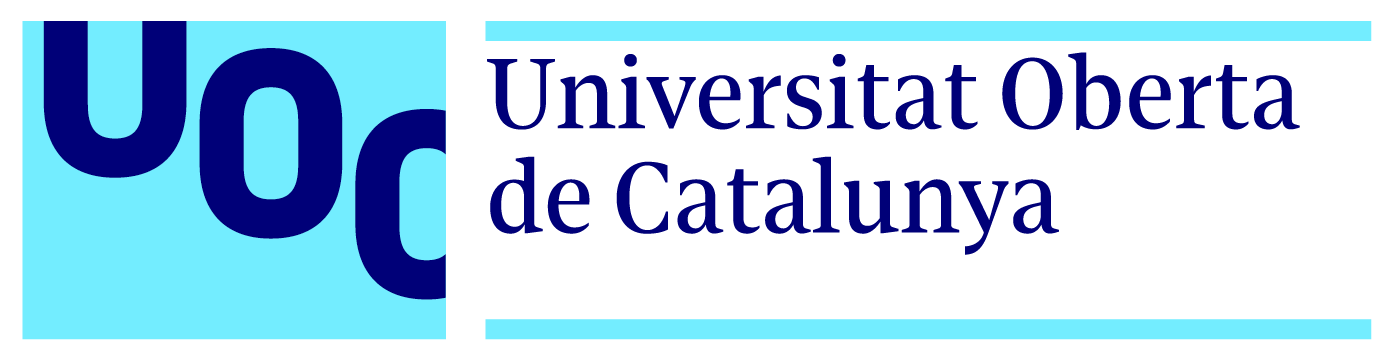

# TFM: 02_ Modelado

Este es el Notebook número 2 de la entrega de la PEC3. En este notebook se explica todos los pasos realizados para realizar el proceso de modelado de la solución con sus correspondientes soluciones.

Este Notebook se han utilizado los datos generados en el Notebook 1, mientras que en el Notebook 03_Modelado Filtrado se usarán los datos filtrados ventas distintas de 0

### Indice

* 1.Carga de Datos
* 2. Exploración de los datos
* 3. Establecer periodo de entrenamiento y test
 * Estudio elimnando periodo Covid
 * Definición de periodos
* 4. Feature Engineering Final
* 5. Escalado de los datos
* 6. Creación de modelo de solución
* 7. Estructura de la solución
* 8. Indicadores de precisión
* 9. Selección de modelos
 * Sarimax
 * XGBoost
 * SVR
 * Stacking XGBoost
 * Stacking 2 LightGBM, XGB, CatBoost, MLPRegressor.
 * LSTM básica.
* 10. Conclusiones
  * Conclusiones  Generales.
  * Mejores Modelos
  * Comparación de todos los modelos con Previsión de empresa
* 11. Cálculo de Costes
 * Conclusión del modelo vs Previsión de empresa
 * Conclusión de Costes
 * Redución de Costes


### Salidas:

Debido a la complejidad de la solución y el tiempo de entrenamiento se crean ficheros de salida para  ver las soluciones sin ejecutar el modelo:




- Metricas_pred: Fichero de métricas que contiene todas las métricas de todos los productos por modelo. Estas métricas son generadas con el conjunto test que son los datos que el modelo no a usado para entrenar ni validar.
- prediciones_fin: Fichero que contiene todas las prediciones por modelo y producto de los diferentes modelo con el conjunto de test.

- Metricas_val: Fichero de métricas que contiene lás metricas de los productos por modelo. Estás metricas son generadas con el conjunto de validación que son los datos que usa el modelo para extraer la mejor solución.

- prediciones_val: Fichero que contiene las prediciones realizadas con el conjunto de validación por los diferentes modelos.
- costes:  Fichero que contiene los costes diarios por producto del modelo que predice mejor la demanda y los costes diaros de la empresa tradicional

-  Gráfico dinámico donde se expone la solución del Coste del modelo vs Coste de la predición tradicional( 11 Calculo de Costes)

### Librerias

In [1]:
import pandas as pd
from datetime import timedelta 
import numpy as np
ruta ="/content/gdrive/MyDrive/TFM/3/"
#ruta = 'C:/Users/alfonso/Desktop/TFM/'
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.metrics import BinaryAccuracy,AUC
import seaborn as sns


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1 Carga de los datos

In [ ]:
df=pd.read_csv(ruta+"MODELAR_FINAL.csv")


# 2 Exploración de los datos

In [ ]:
df.head()

producto       fecha  promocion  ...  rsi_cat_3  categorias  udsPrevisionEmpresa
0         1  2015-06-29        0.0  ...          0          18                  NaN
1         1  2015-06-30        0.0  ...          0          18                  NaN
2         1  2015-07-01        0.0  ...          0          18                  NaN
3         1  2015-07-02        0.0  ...          0          18                  NaN
4         1  2015-07-03        0.0  ...          0          18                  NaN

[5 rows x 29 columns]

In [ ]:
## Se elimina MAX_2M variable altamente correlacionada con otras variables

In [ ]:
df = df.drop(["MAX_2M"], axis = 1)


In [ ]:
df[["fecha","producto"]].duplicated().sum()

0

In [ ]:
df[["fecha","producto"]].isna().sum()

fecha       0
producto    0
dtype: int64

# 3 Establecer periodo de entrenamiento y Test

Se estudia los posibles periodos de entramiento, validación y test

In [ ]:
Total_Ventas=df[["fecha","udsVenta"]]

In [ ]:
Total_prev=df[["fecha","udsPrevisionEmpresa"]]

In [ ]:
Total_Ventas_año=Total_Ventas.groupby('fecha').mean('udsVenta')

In [ ]:
Total_Ventas_año2=Total_Ventas.groupby('fecha').sum('udsVenta')

In [ ]:
df_ventas = Total_Ventas_año.loc[(Total_Ventas_año.index >'2015-09-01') & (Total_Ventas_año.index<'2021-03-31')]

In [ ]:
df_ventas2 = Total_Ventas_año2.loc[(Total_Ventas_año2.index >'2015-09-01') & (Total_Ventas_año2.index<'2021-02-31')]

In [ ]:
plot2=df_ventas
plot2["fecha"]=df_ventas.index

<Figure size 1440x720 with 0 Axes>

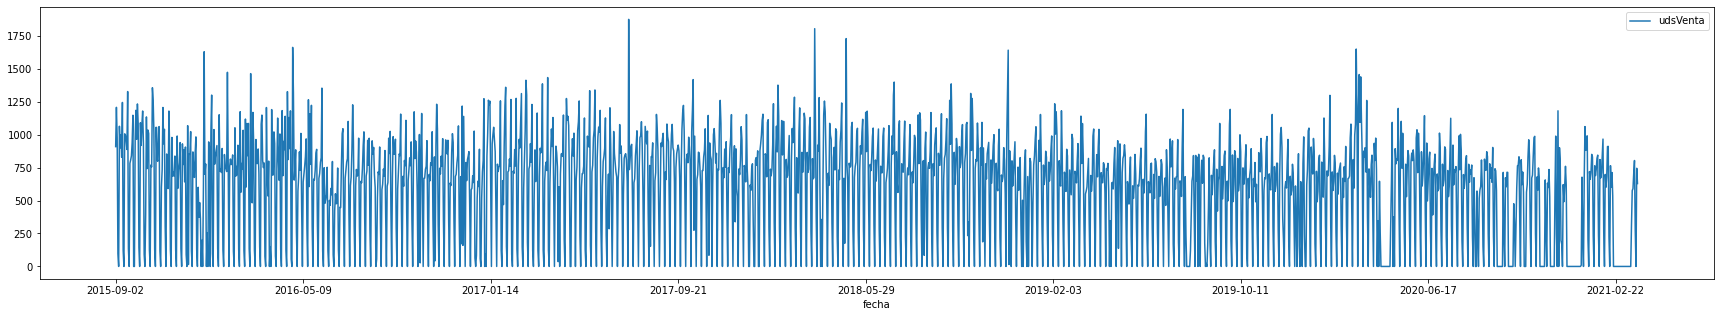

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
plot2.plot(x="fecha", y='udsVenta', figsize=(30, 5))
plt.show()

 El estallido de la pandemia del coronavirus y las medidas sanitarias encaminadas a su mitigación han dado lugar al escenario no común en el tiempo y por tanto será eliminado y no usado ni para entrenamiento ni test. Porque no tenemos historia de escenarios similares a la pandemia mundial

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


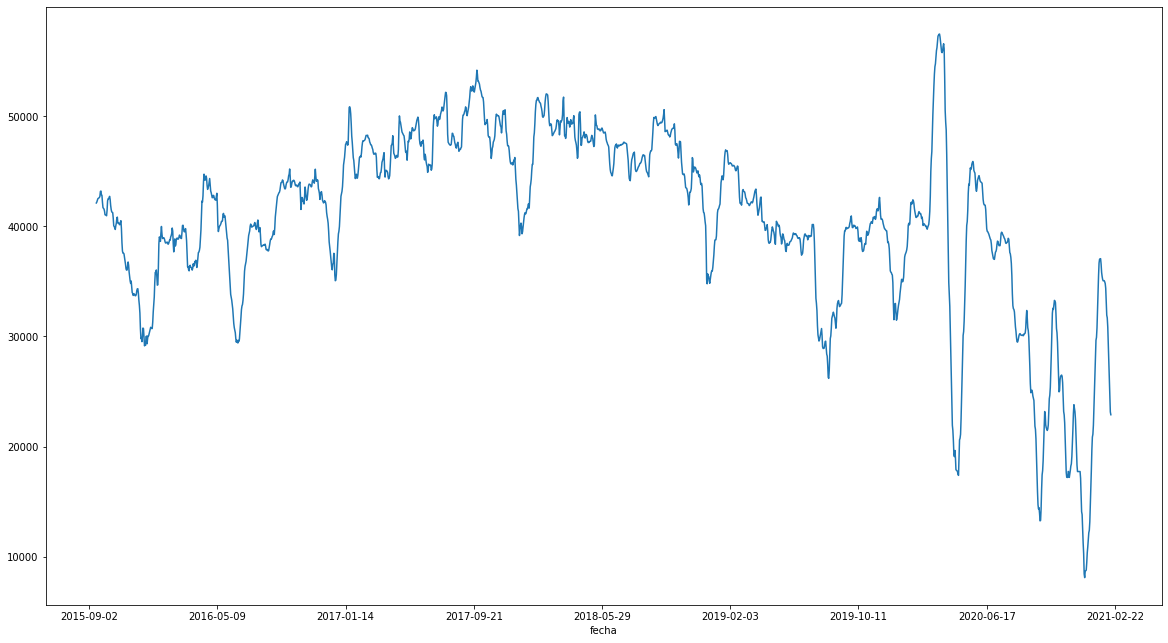

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20,11)
res = seasonal_decompose(df_ventas2['udsVenta'],model='additive', freq=28)
res.trend.plot()
plt.show()


### Estudio Eliminando periodo Covid

Observamos periodos temporales similares. Seleccionamos periodos similares para validación y test.

Lo que se busca es que las prediciones finales del modelo no conozcan   los  datos dando una mayor seguridad y respaldoa la decisión de elegir el modelo correcto  

In [ ]:
df_ventas=df_ventas.loc[df_ventas.index<"2020-02-29"]

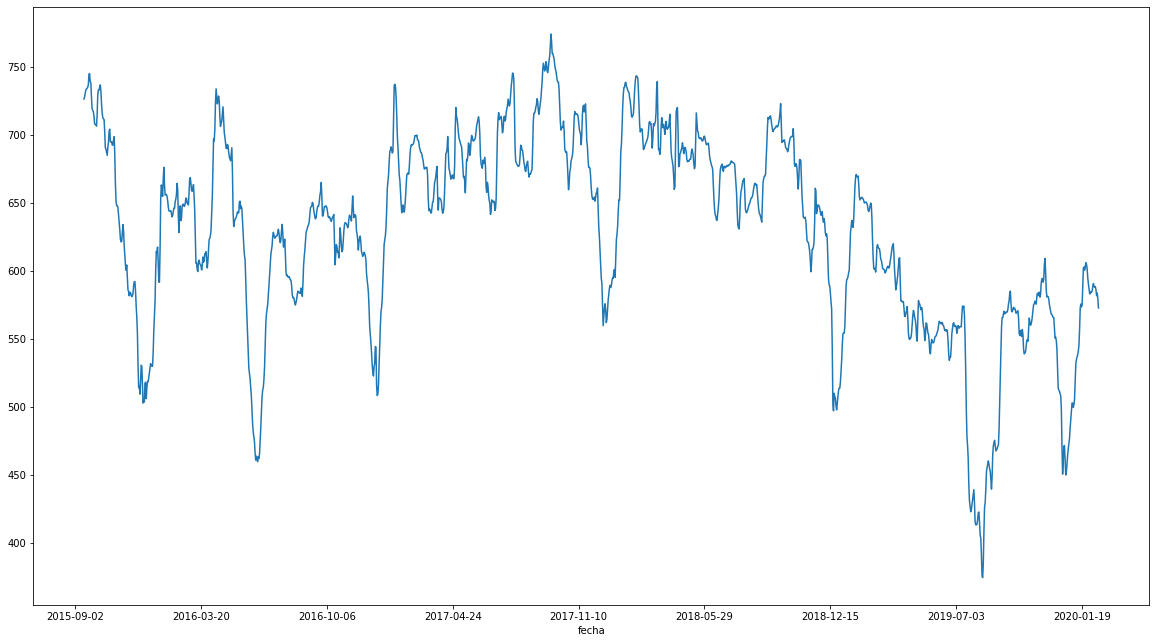

In [ ]:
plt.rcParams["figure.figsize"] = (20,11)
res = seasonal_decompose(df_ventas['udsVenta'],model='additive', freq=28)
res.trend.plot()
plt.show()

Observamos que puede ser epocas similares y definimos el cuadrado negro como conjunto de validación y el cuadrado rojo como conjunto de Test. Serán 64 días de validación y 65 de test

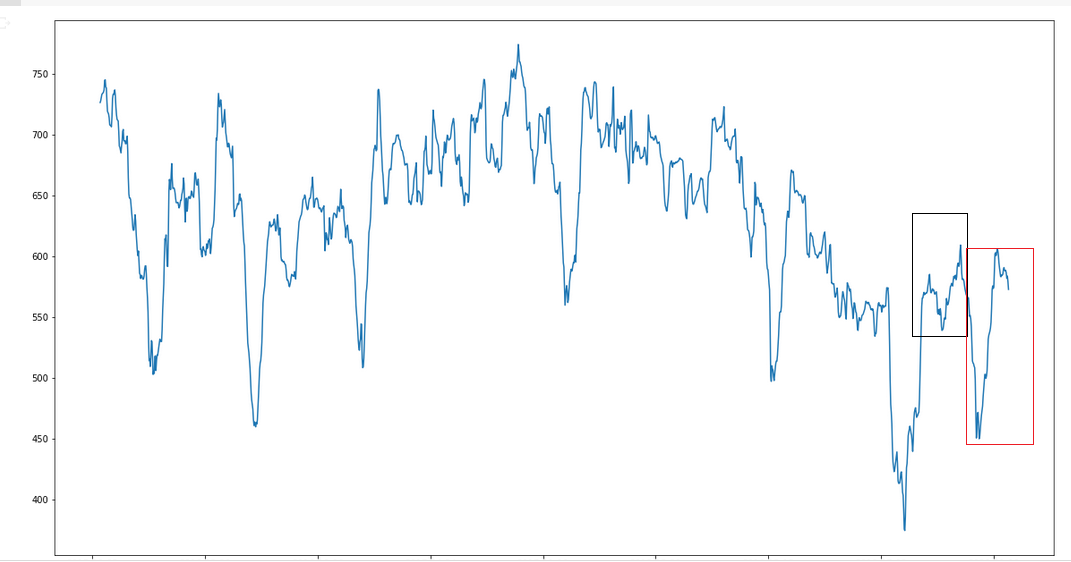

Se hace zoom y se observa se indican que serán los periodos de Validacion y Test

In [ ]:
fechaA="2019-08-31"
FechaB="2019-11-15"
FechaFin="2020-01-30"

In [ ]:
A=df_ventas.loc[(df_ventas.index>fechaA)&(df_ventas.index<FechaB)]

In [ ]:
A.shape

(75, 2)

In [ ]:
B=df_ventas.loc[(df_ventas.index>FechaB)&(df_ventas.index<FechaFin)]

In [ ]:
B.shape

(75, 2)

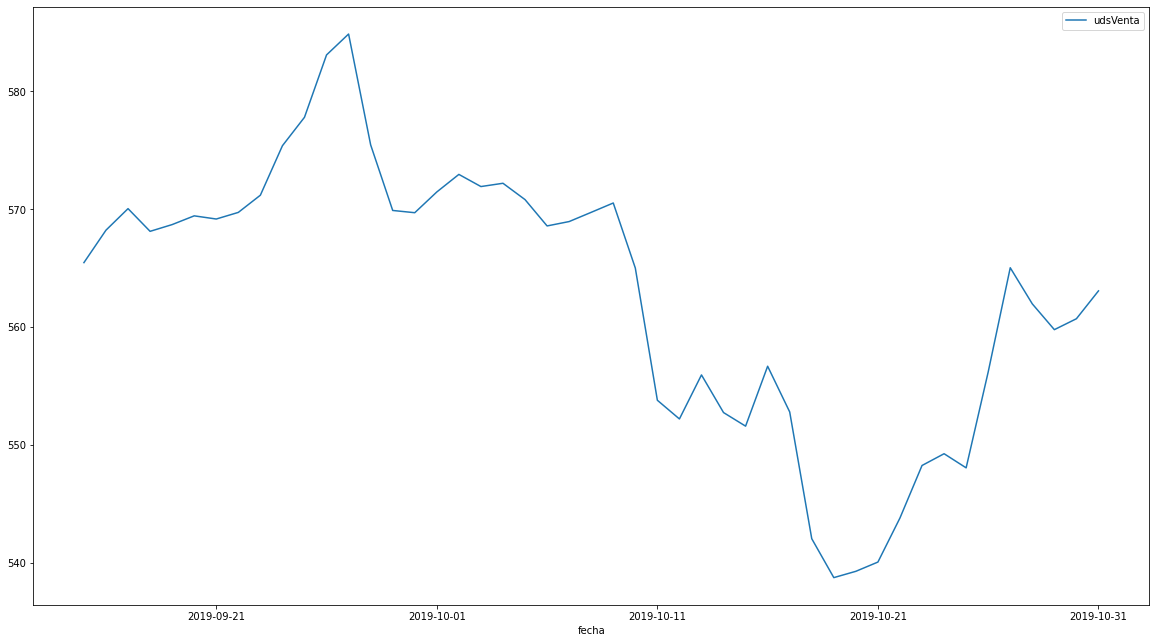

In [ ]:
plt.rcParams["figure.figsize"] = (20,11)
res = seasonal_decompose(A['udsVenta'],model='additive', freq=28)

res.trend.plot()
plt.legend()
plt.show()

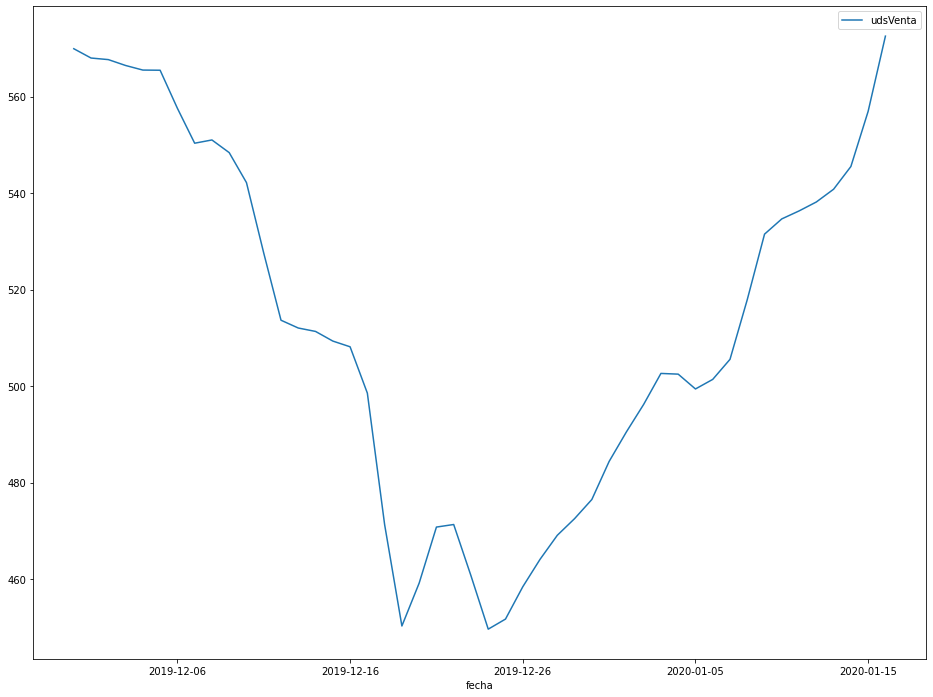

In [ ]:


plt.rcParams['figure.figsize'] = [16, 12]
res = seasonal_decompose(B['udsVenta'],model='additive', freq=28)

res.trend.plot()
plt.legend()
plt.show()

### Definición de los periodos

Visualizamos los diferentes periodos.
 - Azul: Conjunto de entrenamiento
 - Naranja: Conjunto de validación con lo que trabajará el modelo.
 - Verde: Conjunto de Test: Para evaluar la solución. Este conjunto de datos no será utilizado por el modelo y servirá para evitar overfitting

- Las fechas serán de entrenamiento desde 2015-08-31 hasta 2019-08-31
- Fecha de validación desde 2019-08-31 hasta 2019-11-15
- Fecha del conjunto de test desde 2019-11-15 hasta 2020-01-30

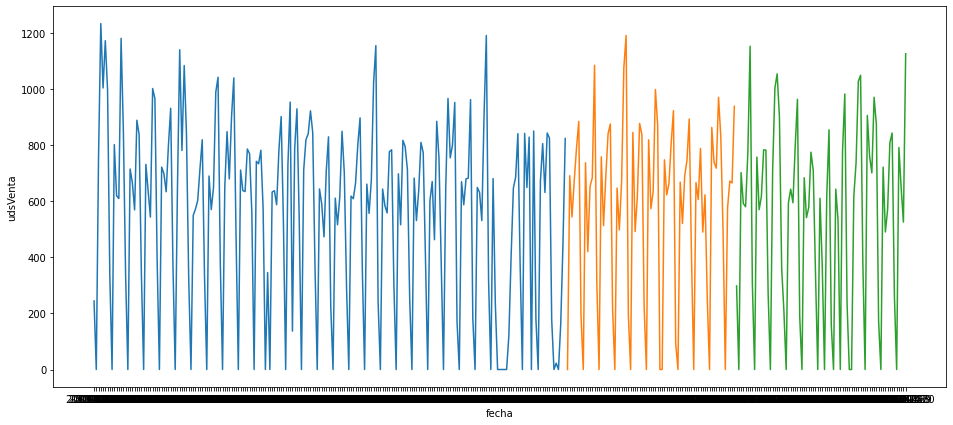

In [ ]:

sns.lineplot(x = "fecha", y = "udsVenta", data = df_ventas.loc[(df_ventas.index>"2019-02-01")&(df_ventas.index<fechaA)])
sns.lineplot(x = "fecha", y = "udsVenta", data = df_ventas.loc[(df_ventas.index>fechaA)&(df_ventas.index<FechaB)])
sns.lineplot(x = "fecha", y = "udsVenta",data=df_ventas.loc[(df_ventas.index>FechaB)&(df_ventas.index<FechaFin)])



#4 Feature Engineering Final

- Se seleccionan las fechas.
- Eliminación de variables no necesarias.
- Inputación de nulos.
    - UpperBand_monthly se sustituye los nulos por el UpperBand_weekly
    - Media_W4 se sustituye por Media_W2.
    - Se elimina la variable Media_W2
    

In [ ]:
df=df.loc[(df["fecha"]>'2015-08-31')&(df["fecha"]<'2020-02-01')]

In [ ]:
df = df.drop(["udsPrevisionEmpresa"], axis = 1)


In [ ]:
df = df.drop(["categorias"], axis = 1)


In [ ]:
df.isna().sum()

producto               0
fecha                  0
promocion              0
festivo                0
precio                 0
pre_promocion          0
Media_W4             252
Media_W2              12
Mediana_7D            72
UpperBand_weekly      72
UpperBand_monthly    324
udsVenta               0
weekday_Friday         0
weekday_Monday         0
weekday_Saturday       0
weekday_Sunday         0
weekday_Thursday       0
weekday_Tuesday        0
weekday_Wednesday      0
w_1                    0
w_2                    0
w_3                    0
w_4                    0
rsi_cat_1              0
rsi_cat_2              0
rsi_cat_3              0
dtype: int64

In [ ]:
df.loc[df["Media_W4"].isna(),"producto"].drop_duplicates()

1891       2
14253     11
42955     31
50977     37
61034     45
70908     52
76491     58
94287     69
112617    83
116346    85
126094    92
127703    93
Name: producto, dtype: int64

In [ ]:
df.loc[df["UpperBand_monthly"].isna(),"UpperBand_monthly"]=df.loc[df["UpperBand_monthly"].isna(),"UpperBand_weekly"]

In [ ]:
df.loc[df["Media_W4"].isna(),"Media_W4"]=df.loc[df["Media_W4"].isna(),"Media_W2"]

In [ ]:
df.fillna(method="ffill",inplace=True)

In [ ]:
df = df.drop(["Media_W2"], axis = 1)


In [ ]:
df.columns

Index(['producto', 'fecha', 'promocion', 'festivo', 'precio', 'pre_promocion',
       'Media_W4', 'Mediana_7D', 'UpperBand_weekly', 'UpperBand_monthly',
       'udsVenta', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'w_1', 'w_2', 'w_3', 'w_4', 'rsi_cat_1',
       'rsi_cat_2', 'rsi_cat_3'],
      dtype='object')

In [ ]:
fechaA="2019-08-31"
FechaB="2019-11-15"
FechaFin="2020-01-30"

In [ ]:
df_train_ohe=df.loc[(df["fecha"]<=fechaA)]

In [ ]:
df_train_ohe.shape

(98589, 25)

In [ ]:
df_val=df.loc[(df["fecha"]>fechaA)&(df["fecha"]<FechaB)]

In [ ]:
df_val.shape

(5250, 25)

In [ ]:
df_estim=df.loc[(df["fecha"]>=FechaB)&(df["fecha"]<FechaFin)]

In [ ]:
df_estim.shape

(5320, 25)

# 5 Escalado de los datos
### Método Elegido : Estandarización del modelo

Se descarta Min_Max Scaler debido a que es sensible a los valores atípicos, como en este caso hay valores atípicos, por ejemplo, en los datos en promociones y son útiles para el modelo se descarta esta opción. Mediante la estandarización todas las características estarán  en la misma escala en relación con las demás.


In [ ]:
scaler=StandardScaler()

# 6 CREACION MODELO SOLUCIÓN

In [ ]:
import math
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import lightgbm


In [ ]:
!pip install catboost


     |████████████████████████████████| 67.3MB 77kB/s 


In [ ]:
from catboost import CatBoostRegressor
import catboost as cgb

In [ ]:
### Definición de metricas para validar el modelo

In [ ]:

def mean_absolute_percentage_error2(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
def smape(A, F):
    return 100./len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

Eliminación de los Domingos en el modelo

In [ ]:
df_entrenar = df_train_ohe[df_train_ohe['weekday_Sunday']!= 1]
df_validacion = df_val[df_val['weekday_Sunday']!= 1]
df_estim=df_estim[df_estim['weekday_Sunday']!= 1]

In [ ]:
df_entrenar = df_entrenar.drop(["weekday_Sunday"], axis = 1)
df_validacion = df_validacion.drop(["weekday_Sunday"], axis = 1)
df_estim=df_estim.drop(["weekday_Sunday"], axis = 1)

In [ ]:
df_estim.shape

(4550, 24)

In [ ]:
df_validacion.shape

(4480, 24)

In [ ]:
df_entrenar.shape

(84552, 24)

In [ ]:
products_id = df_train_ohe['producto'].drop_duplicates()

In [ ]:
col_names = ['precio', 'Media_W4','Mediana_7D',"UpperBand_weekly","UpperBand_monthly","udsVenta"]

In [ ]:
feature_columns=['promocion', 'festivo', 'precio', 'pre_promocion',
       'Media_W4', 'Mediana_7D', 'UpperBand_weekly', 'UpperBand_monthly',
       'udsVenta', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
     'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'w_1', 'w_2', 'w_3', 'w_4', 'rsi_cat_1',
       'rsi_cat_2', 'rsi_cat_3']

In [ ]:
cat_columns=['promocion', 'festivo','pre_promocion',
       'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
     'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'w_1', 'w_2', 'w_3', 'w_4', 'rsi_cat_1',
       'rsi_cat_2', 'rsi_cat_3']

Función Maestra que contiene todas las metricas

In [ ]:
def final_metric2(test_y, pred_y):
    metrics = {}
    preds =np.ceil(pred_y)
    metrics['RMSE'] = mean_squared_error(test_y, preds, squared=False)
    metrics['rRMSE'] = metrics['RMSE']/np.mean(test_y)
    metrics['MAE'] =mean_absolute_error(test_y, preds)
    metrics['MAPE'] =mean_absolute_percentage_error2(test_y, preds)
    metrics['sMAPE'] =smape(test_y, preds)

    print("RMSE: {}\nrRMSE: {}\nMAE: {}\nMAPE: {}\nsMAPE: {}".format(
        metrics['RMSE'], metrics['rRMSE'],metrics['MAE'],metrics['MAPE'],metrics['sMAPE'])
    )
    return metrics

Función que inverte el escalado generado

In [ ]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

### Creacion de Dataframes para guardar preciciones y guardar métricas

In [ ]:
a=np.zeros((df_estim.shape[0],))


In [ ]:
df_validaciones = pd.DataFrame(index=df_validacion.index, data=np.zeros((df_validacion.shape[0],)), columns= ['predictions'])


In [ ]:
df_validaciones

predictions  producto
1526            0.0         1
1527            0.0         1
1528            0.0         1
1529            0.0         1
1530            0.0         1
...             ...       ...
139322          0.0        99
139324          0.0        99
139325          0.0        99
139326          0.0        99
139327          0.0        99

[4480 rows x 2 columns]

In [ ]:
df_predictions = pd.DataFrame(index=df_estim.index, data=np.zeros((df_estim.shape[0],)), columns= ['predictions'])


In [ ]:
df_predictions

predictions  producto
1600            0.0         1
1601            0.0         1
1603            0.0         1
1604            0.0         1
1605            0.0         1
...             ...       ...
139398          0.0        99
139399          0.0        99
139401          0.0        99
139402          0.0        99
139403          0.0        99

[4550 rows x 2 columns]

In [ ]:
df_predictions["producto"]=df_estim[["producto"]]

In [ ]:
df_validaciones["producto"]=df_validacion[["producto"]]

In [ ]:
df_metricas_val = pd.DataFrame(columns=['producto','modelo','RMSE', 'rRMSE','MAE','MAPE','sMAPE'])

In [ ]:
df_metricas_pred= pd.DataFrame(columns=['producto','modelo','RMSE', 'rRMSE','MAE','MAPE','sMAPE'])

In [ ]:
df_metricas_pred


Empty DataFrame
Columns: [producto, modelo, RMSE, rRMSE, MAE, MAPE, sMAPE]
Index: []

In [ ]:
def metricas_totales_val(diccionario,cadena):
  for i in diccionario:
    row = [i, cadena, diccionario[i]['metrics']['RMSE'],diccionario[i]['metrics']['rRMSE'],diccionario[i]['metrics']['MAE'],diccionario[i]['metrics']['MAPE'],diccionario[i]['metrics']['sMAPE']]
    df_metricas_val.loc[len(df_metricas_val)] = row

In [ ]:
def metricas_totales_pred(diccionario,cadena):
  for i in diccionario:
    row = [i, cadena, diccionario[i]['metrics']['RMSE'],diccionario[i]['metrics']['rRMSE'],diccionario[i]['metrics']['MAE'],diccionario[i]['metrics']['MAPE'],diccionario[i]['metrics']['sMAPE']]
    df_metricas_pred.loc[len(df_metricas_pred)] = row

# 7 Estructura de la solución

A continuación, se comenta como se estructura  cada ejecución del modelo. Será un modelo por producto y por tipología de modelo:

 

1.   Se define la función del modelo 
2.  Se crea un bucle donde cada iteración se ejecuta desde el paso 3 hasta el final una vez por producto.
3. Se define el conjunto de entrenamiento por producto, escalando las variables númericas y posteriormente se concatena con las variables categoricas. 
4. El paso 3 se realiza para conjunto de validación y test.
5. Se ejecuta el modelo llamando a la función definida en el paso 1. En este paso se entrena se elige el mejor modelo para cada producto con el conjunto de entrenamiento y validación. Esta función devuelve el modelo, las métricas de validación y las prediciones de validación.
6. Este modelo y metricas de validación se guardan en un diccionario y las prediciones se guardan en un dataset.
7. Se realiza la predicción con el conjunto de test, este conjunto de datos el modelo no lo conoce y se observa que tan bueno es el modelo con el conjunto de validación.
8. Las métricas, modelo y validación se guardan para su futura evaluación con los distintos modelos por producto
9. Cada Salida del modelo nos irá indicando las diferentes métricas tanto de validación como test




# 8 Selección de Indicadores de precisión.

Debido que en este estudio existen valores a 0s, en periodos donde la gente no compra, no se pueden utilizar la métricas MAE y MAPE ya que darían valores nulos. Por tanto, para este estudio, se usan las metricas siguientes:

 $$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}} $$
$$ rRMSE = \frac{\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}}{\overline{n}}\$$




#9 Selección de modelos

 Los modelos seleccionados son:

 - SARIMAX
 - XGBoost
 -Support Vector Regression
 - Stacking 2 XGBoost
 - Stacking LightGBM- XGBoost - CatBoostRegressor - Perceptrón multicapa 
 - Vanilla LSTM


# 9.1  SARIMAX con variables exógenas

Nuestro modelo tiene un componente estacional (como se comprobó en el análisis estadistico), Se utiliza un modelo ARIMA estacional (SARIMA). En ese caso tenemos otro conjunto de parámetros: P,D, y Q que describen las mismas asociaciones que p,d, y q, pero se corresponden con los componentes estacionales del modelo. 


En este caso, se crea un modelo multivariante que hace uso de las variables exógenas del conjunto de datos. 

Una variable exógena es aquella cuyo valor se determina fuera del modelo y se impone a éste. Es decir, variables que afectan a un modelo sin ser afectadas por él.

Utilizamos el modelo autoarima para definir los parametros estableciendo los periodos con m=6 (se eliminó el domingo) y la estimador de calidad para definir el mejor modelo sarimax, para el estimador de calidad se usa AIC.

Según Peterson, T. (2014) el AIC (criterio de información de Akaike) es un estimador de la calidad relativa de los modelos estadísticos para un conjunto dado de datos. Dado un conjunto de modelos para los datos, el AIC estima la calidad de cada modelo, en relación con cada uno de los otros modelos. Cuanto más bajo sea el valor del AIC, mejor. 

SARIMAX, si se ajusta bien, puede predecir pequeños altibajos, pero siempre que la tendencia general no haya cambiado. Si hay un crecimiento o una desaceleración inusual en la serie, SARIMAX falla terriblemente, mientras que otros modelos son capaces de ajustarse a eso.

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 4.9MB/s 
     |████████████████████████████████| 9.5MB 17.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pmdarima as pm


In [ ]:

def funcion_Sarimax(X, y, X_val, y_val):


  # SARIMAX Model
  sxmodel = pm.auto_arima(y, exogenous=X,
                            start_p=1, start_q=1,
                            test='adf',
                            max_p=3, max_q=2, max_d=2, m=6, seasonal=True,
                            d=None,max_P=3, D=1, trace=False,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
  n_periods = 64
  fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=X_val, 
                                  return_conf_int=True)


  inversed = scaler.inverse_transform(fitted)
  inversed[inversed < 0] = 0
  y_val = scaler.inverse_transform(y_val)


  metrics = final_metric2(y_val, inversed)


  return sxmodel, metrics,inversed

In [ ]:
model_dict_arimax_val = {}
model_dict_arimax_test = {}

# For product p id in all products id
for p in products_id:
      ## Generate model for product p
      print("Generando modelo para producto: {}".format(p))
      #train
      temp_df = df_entrenar[df_entrenar['producto']==1].drop(['fecha', 'producto'], axis=1)
      features = temp_df[["udsVenta"]]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])

      fetures_train=np.concatenate([features2,features], axis=1)

      temp_labels_model = fetures_train[:, -1]
      temp_features_model =fetures_train[:, :-1]
      temp_features_model =fetures_train[:, :-1]
      # validacion
      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_Val_Y = Val_df_Y[["udsVenta"]]
      features_Y = scaler.transform(feat_Val_Y.values)
      features2_val=np.array(Val_df_Y[cat_columns])
      fetures_val=np.concatenate([features2_val,features_Y], axis=1)
      val_labels_model_Y = fetures_val[:, -1]
      val_features_model_Y =fetures_val[:, :-1]


      # Estimar

      Estimar_df = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[["udsVenta"]]
      feat_test = scaler.transform(feat_test_Y.values)
      features2_estim=np.array(Estimar_df[cat_columns])
      feat_test_Y=np.concatenate([features2_estim,feat_test], axis=1)
      test_labels_model_Y = feat_test_Y[:, -1]
      test_features_model_Y =feat_test_Y[:, :-1]



      print("Shape del dataframe para el producto es: {}".format(temp_df.shape))
      clf, metrics,pred_val= funcion_Sarimax(temp_features_model, temp_labels_model, val_features_model_Y,val_labels_model_Y)


      df_validaciones.loc[Val_df_Y.index, 'predictions_SMAX'] = np.ceil(pred_val)
      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics}
      model_dict_arimax_val[p] = model_product_dict


      #Predicion final
      print("### Validaciones Finales###")
      pred_estim = clf.predict(n_periods=Estimar_df.shape[0], 
                                  exogenous=test_features_model_Y, 
                                  return_conf_int=False) 
       
      inversed = scaler.inverse_transform(pred_estim)
      inversed[inversed < 0] = 0
      y_test = scaler.inverse_transform(test_labels_model_Y)

      metrics_test=final_metric2(y_test,inversed )

      


      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics_test}
      model_dict_arimax_test[p] = model_product_dict

      print("-----------------------------------------------------")

     #Guardar prediciones
      df_predictions.loc[Estimar_df.index, 'predictions_SMAX'] = np.ceil(inversed)



Generando modelo para producto: 1
Shape del dataframe para el producto es: (1253, 22)
RMSE: 2494.6378118877296
rRMSE: 0.8583607701036263
MAE: 1583.1875
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 3618.7346258475063
rRMSE: 1.2520306739275129
MAE: 2668.1692307692306
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 2
Shape del dataframe para el producto es: (1253, 22)
RMSE: 15547.355364438192
rRMSE: 8.390794388241819
MAE: 15472.265625
MAPE: inf
sMAPE: 162.79764085574914
### Validaciones Finales###
RMSE: 15592.474029775736
rRMSE: 9.332082426549633
MAE: 15433.076923076924
MAPE: inf
sMAPE: 165.00616167583453
-----------------------------------------------------
Generando modelo para producto: 3
Shape del dataframe para el producto es: (1253, 22)
RMSE: 15396.117408294858
rRMSE: 6.642028123375447
MAE: 15275.65625
MAPE: inf
sMAPE: 156.70633277475918
### Validaciones Finales###
RMSE: 15414.683541750304
rRMSE: 8.346420790478398


In [ ]:
metricas_totales_val(model_dict_arimax_val,"SARIMAX")

In [ ]:
metricas_totales_pred(model_dict_arimax_test,"SARIMAX")

**Conclusiones del modelo:** Viendo tanto las métricas que extrae el modelo se puede indicar que no es un modelo bueno para este tipo de escenarios, dado que el sautoarimax con multiples valores tarda mucho tiempo en entrenar y no aporta mejores soluciones que los modelos básicos de machine learning

# 9.2 XGBoost 

El XGBoost es un popular modelo de aprendizaje automático con características buenas carácteristicas como velocidad de cálculo, paralelización y rendimiento.
Su principal ventaja es que en cada iteración este modelo se ajusta
empleando únicamente una fracción del set de entrenamiento, extraída de forma aleatoria y sin reemplazo (no con bootstrapping). 
A este resultado de de las posibles modificaciones se llama Stochastic Gradient Boosting y proporciona dos ventajas: mejora la predicción y permite estimar el out-of-bag-error de forma que cada modelo aprende de los errores del anterior.


Además se  usa este modelo por la capacidad de extraer las caracteristicas de manera individualizada de la serie temporal



En esta sección, utilizaremos XGBRegressor y Grid Search para afinar y recuperar los parámetros óptimos para reducir el rmse.

Buscamos los mejores hiperparametrós ya que una vez seleccionado el mejor modelo de manera invidual se usará en los siguientes modelos.

Destacamos la búsqueda de hyperparametros en:
- learning_rate: reduce la contribución de cada árbol multiplicando su influencia original por este valor.
- max_depth: profundidad máxima que pueden alcanzar los árboles.

- subsample: proporción de observaciones utilizadas para el ajsute de cada árbol. Si su valor es inferior a 1, se está aplicando Stochastic Gradient Boosting.
- n_estimators: número de árboles incluidos en el modelo.
- Destacar el parametro Alpha para prevenir el overfitting y hacer el modelo más conservativo



In [ ]:
def get_clf_xgb(X, y, X_val, y_val):
    tscv = TimeSeriesSplit(n_splits=2)
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 250],
        'alpha': [10],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = tscv,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X,y)
    print(gsearch.best_params_)
    xlf_1=  gsearch.best_estimator_        

    #xlf_1 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.01, max_depth = 13, alpha = 10, n_estimators = 240, echo=False)
    xlf_1.fit(X, y, eval_metric="rmse", eval_set = [(X_val, y_val)],verbose=0)
    preds = xlf_1.predict(X_val)
    
    return xlf_1,preds

In [ ]:
model_dict_val_XGB = {}
model_dict2= {}

# For product p id in all products id
for p in products_id:
      ## Generate model for product p
      print("Generando modelo para producto: {}".format(p))
      #train
      temp_df = df_entrenar[df_entrenar['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])

      fetures_train=np.concatenate([features2,features], axis=1)

      temp_labels_model = fetures_train[:, -1]
      temp_features_model =fetures_train[:, :-1]
      # validacion
      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_Val_Y = Val_df_Y[col_names]
      features_Y = scaler.transform(feat_Val_Y.values)
      features2_val=np.array(Val_df_Y[cat_columns])
      fetures_val=np.concatenate([features2_val,features_Y], axis=1)
      val_labels_model_Y = fetures_val[:, -1]
      val_features_model_Y =fetures_val[:, :-1]

      # Estimar

      Estimar_df = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[col_names]
      feat_test = scaler.transform(feat_test_Y.values)
      features2_estim=np.array(Estimar_df[cat_columns])
      feat_test_Y_FIN=np.concatenate([features2_estim,feat_test], axis=1)
      test_labels_model_Y = feat_test_Y_FIN[:, -1]
      test_features_model_Y =feat_test_Y_FIN[:, :-1]

      print("Shape del dataframe para el producto es: {}".format(temp_df.shape))
      clf, pred_val= get_clf_xgb(temp_features_model, temp_labels_model, val_features_model_Y,val_labels_model_Y)


      val_pred=invTransform(scaler,pred_val,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0
      Y_VAL=invTransform(scaler,features_Y[:, -1],"udsVenta",col_names)
      metricas=final_metric2(Y_VAL,val_pred )



      df_validaciones.loc[Val_df_Y.index, 'predictions_XGB'] = np.ceil(val_pred)

      
      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metricas}
      model_dict_val_XGB[p] = model_product_dict


      #Predicion final
      print("### Validaciones Finales###")
      predictions = clf.predict(test_features_model_Y)


      TEST_Y=invTransform(scaler,feat_test[:, -1],"udsVenta",col_names)
      prediciones=invTransform(scaler,predictions,"udsVenta",col_names)
      prediciones[prediciones < 0] = 0
      metrics2=final_metric2(TEST_Y,prediciones )
      print("-----------------------------------------------------")

     #Guardar prediciones
      df_predictions.loc[Estimar_df.index, 'predictions_XGB'] = np.ceil(prediciones)

      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics2}
      model_dict2[p] = model_product_dict

Generando modelo para producto: 1
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   13.9s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 2089.2398999097736
rRMSE: 0.7188705153397572
MAE: 1276.953125
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 2122.929565120223
rRMSE: 0.7345034131911837
MAE: 1299.8461538461538
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 2
Shape del dataframe para el producto es: (1132, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    9.8s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 485.61192067328824
rRMSE: 0.2620812146719718
MAE: 387.3125
MAPE: inf
sMAPE: 27.944528110197943
### Validaciones Finales###
RMSE: 491.5369302973621
rRMSE: 0.2941844341358919
MAE: 371.7846153846154
MAPE: inf
sMAPE: 35.70474798770531
-----------------------------------------------------
Generando modelo para producto: 3
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 977.3649443145584
rRMSE: 0.42164431945946934
MAE: 650.640625
MAPE: inf
sMAPE: 33.81881426286744
### Validaciones Finales###
RMSE: 615.4888863584534
rRMSE: 0.33326206298668404
MAE: 520.0153846153846
MAPE: inf
sMAPE: 40.897673796512386
-----------------------------------------------------
Generando modelo para producto: 4
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 979.9979113498151
rRMSE: 0.3001496268526726
MAE: 767.40625
MAPE: inf
sMAPE: 28.334618390561907
### Validaciones Finales###
RMSE: 1093.7061481319095
rRMSE: 0.33550376665852155
MAE: 899.1692307692308
MAPE: inf
sMAPE: 37.21937314354472
-----------------------------------------------------
Generando modelo para producto: 5
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 309.1744552028838
rRMSE: 0.15673498671628855
MAE: 238.4375
MAPE: 4576717150617614.0
sMAPE: 17.88552358457799
### Validaciones Finales###
RMSE: 393.7376518210298
rRMSE: 0.20150975047137093
MAE: 303.0
MAPE: 6657965795271305.0
sMAPE: 27.032481513362892
-----------------------------------------------------
Generando modelo para producto: 9
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 450.0840199340563
rRMSE: 0.35506085785153835
MAE: 343.03125
MAPE: inf
sMAPE: 38.64399535165344
### Validaciones Finales###
RMSE: 2099.6425629872556
rRMSE: 1.2842696446171153
MAE: 963.3538461538461
MAPE: inf
sMAPE: 66.60580862922062
-----------------------------------------------------
Generando modelo para producto: 10
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 293.96401778108833
rRMSE: 0.19774749987376133
MAE: 210.125
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 539.1270294152889
rRMSE: 0.3564095573974938
MAE: 388.26153846153846
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 11
Shape del dataframe para el producto es: (903, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    8.2s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 1097.384774703021
rRMSE: 0.630426153054112
MAE: 728.0
MAPE: inf
sMAPE: 58.265197236483715
### Validaciones Finales###
RMSE: 1046.7794492559622
rRMSE: 0.6555482522895555
MAE: 666.723076923077
MAPE: inf
sMAPE: 48.02076464256415
-----------------------------------------------------
Generando modelo para producto: 12
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 247.3564609020755
rRMSE: 0.32035156925213654
MAE: 200.5
MAPE: inf
sMAPE: 34.70360800347141
### Validaciones Finales###
RMSE: 224.07289335941894
rRMSE: 0.3754088735820355
MAE: 164.96923076923076
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 13
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.6s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 259.83693804961604
rRMSE: 0.20896925112373146
MAE: 170.140625
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 422.0326637012463
rRMSE: 0.36070219245491253
MAE: 293.4769230769231
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 14
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.8s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 513.6756028857124
rRMSE: 0.4242349448941916
MAE: 385.59375
MAPE: inf
sMAPE: 51.515839066471145
### Validaciones Finales###
RMSE: 655.434700144756
rRMSE: 0.589680759459212
MAE: 522.0615384615385
MAPE: inf
sMAPE: 72.66115010187258
-----------------------------------------------------
Generando modelo para producto: 15
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 249.1158427820278
rRMSE: 0.545372304099671
MAE: 192.515625
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 190.90259296300823
rRMSE: 0.6045341782420118
MAE: 146.75384615384615
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 17
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 249.1439405745201
rRMSE: 0.17404396826721627
MAE: 187.484375
MAPE: inf
sMAPE: 16.964978112651735
### Validaciones Finales###
RMSE: 260.31785304773973
rRMSE: 0.19181812506351836
MAE: 176.98461538461538
MAPE: inf
sMAPE: 22.721376519516383
-----------------------------------------------------
Generando modelo para producto: 18
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 410.037174381787
rRMSE: 0.36725228336926735
MAE: 314.453125
MAPE: inf
sMAPE: 42.25038219573992
### Validaciones Finales###
RMSE: 504.5819747382671
rRMSE: 0.4524025595264267
MAE: 404.04615384615386
MAPE: inf
sMAPE: 59.22307837806796
-----------------------------------------------------
Generando modelo para producto: 19
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 400.662010770924
rRMSE: 0.35691733045681107
MAE: 311.171875
MAPE: inf
sMAPE: 39.938870207293064
### Validaciones Finales###
RMSE: 454.2285937549676
rRMSE: 0.45369114424563045
MAE: 360.1384615384615
MAPE: inf
sMAPE: 52.4885506485482
-----------------------------------------------------
Generando modelo para producto: 20
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 307.6823138401036
rRMSE: 0.29151248091438386
MAE: 186.59375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 248.415316014873
rRMSE: 0.2332875177485624
MAE: 174.13846153846154
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 21
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.6s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 167.49841417159746
rRMSE: 0.18825995762323483
MAE: 100.53125
MAPE: inf
sMAPE: 15.451599138657784
### Validaciones Finales###
RMSE: 147.25989584091428
rRMSE: 0.18197515645740356
MAE: 101.16923076923077
MAPE: inf
sMAPE: 22.353135829863568
-----------------------------------------------------
Generando modelo para producto: 23
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 242.92987028152797
rRMSE: 0.23983450618606408
MAE: 146.453125
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 432.84914764313055
rRMSE: 0.40876948084097525
MAE: 302.5692307692308
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 24
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 296.25957263015147
rRMSE: 0.19560130652839217
MAE: 222.671875
MAPE: inf
sMAPE: 18.48355141227624
### Validaciones Finales###
RMSE: 353.0688536031115
rRMSE: 0.26132104490044805
MAE: 247.73846153846154
MAPE: inf
sMAPE: 25.711686830179808
-----------------------------------------------------
Generando modelo para producto: 26
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 123.60003539643506
rRMSE: 0.19110944784914582
MAE: 96.5
MAPE: inf
sMAPE: 21.343731691593078
### Validaciones Finales###
RMSE: 138.95289738723585
rRMSE: 0.21472406462140908
MAE: 109.1076923076923
MAPE: inf
sMAPE: 28.535475510459822
-----------------------------------------------------
Generando modelo para producto: 30
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 115.43274557074349
rRMSE: 0.3015016821012767
MAE: 88.75
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 124.86922389813704
rRMSE: 0.37032894800287025
MAE: 90.44615384615385
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 31
Shape del dataframe para el producto es: (1033, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   10.0s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 161.1632518597214
rRMSE: 0.3220246056516444
MAE: 122.8125
MAPE: inf
sMAPE: 30.15246717068655
### Validaciones Finales###
RMSE: 274.553091404923
rRMSE: 0.6310226279594072
MAE: 153.8923076923077
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 32
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 101.41198462213428
rRMSE: 0.2744805470615154
MAE: 72.546875
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 139.9873071169174
rRMSE: 0.4140882389460103
MAE: 101.43076923076923
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 35
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 138.11775999124805
rRMSE: 0.2504898591470395
MAE: 106.359375
MAPE: inf
sMAPE: 26.53058419997786
### Validaciones Finales###
RMSE: 167.62347917052304
rRMSE: 0.3314228485500836
MAE: 138.64615384615385
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 36
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.6s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 93.82588595371749
rRMSE: 0.20285307415167622
MAE: 71.390625
MAPE: inf
sMAPE: 26.318210527254337
### Validaciones Finales###
RMSE: 119.24996371552423
rRMSE: 0.2765043927338877
MAE: 101.96923076923076
MAPE: inf
sMAPE: 41.73685850494139
-----------------------------------------------------
Generando modelo para producto: 37
Shape del dataframe para el producto es: (951, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    8.9s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 42.72184745537112
rRMSE: 0.3218218264058088
MAE: 34.5625
MAPE: inf
sMAPE: 46.51672551340748
### Validaciones Finales###
RMSE: 56.01510785218848
rRMSE: 0.5092994838987622
MAE: 46.98461538461538
MAPE: inf
sMAPE: 65.48329693275257
-----------------------------------------------------
Generando modelo para producto: 38
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 93.88581828476546
rRMSE: 0.20204076564307297
MAE: 68.859375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 101.74697122689281
rRMSE: 0.22226695109218728
MAE: 75.36923076923077
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 40
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 78.24890174948145
rRMSE: 0.275660797708307
MAE: 55.765625
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 97.84328128342636
rRMSE: 0.4148606186185723
MAE: 73.86153846153846
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 42
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 97.1640847998889
rRMSE: 0.283406317892302
MAE: 76.328125
MAPE: inf
sMAPE: 30.39628764066921
### Validaciones Finales###
RMSE: 116.8727776423841
rRMSE: 0.3732303501402656
MAE: 90.87692307692308
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 43
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   12.0s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 199.6746963813893
rRMSE: 0.3934113403444545
MAE: 155.265625
MAPE: inf
sMAPE: 44.96190951666765
### Validaciones Finales###
RMSE: 290.1878966887065
rRMSE: 0.5436893115258387
MAE: 225.6
MAPE: inf
sMAPE: 61.880687734314286
-----------------------------------------------------
Generando modelo para producto: 45
Shape del dataframe para el producto es: (1026, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 211.1170809645681
rRMSE: 0.39595279515098925
MAE: 162.421875
MAPE: inf
sMAPE: 44.44346701062685
### Validaciones Finales###
RMSE: 229.05004491796782
rRMSE: 0.461350838823337
MAE: 176.8153846153846
MAPE: inf
sMAPE: 56.39170311380167
-----------------------------------------------------
Generando modelo para producto: 46
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 262.933481369338
rRMSE: 0.3432411946240287
MAE: 160.953125
MAPE: inf
sMAPE: 26.47222144728818
### Validaciones Finales###
RMSE: 279.42413309133866
rRMSE: 0.3672098956943251
MAE: 206.03076923076924
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 48
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 104.18770620855419
rRMSE: 0.27993338359980974
MAE: 79.515625
MAPE: inf
sMAPE: 30.465909315665563
### Validaciones Finales###
RMSE: 132.7358858207357
rRMSE: 0.3752863235470996
MAE: 99.18461538461538
MAPE: inf
sMAPE: 37.032273958224
-----------------------------------------------------
Generando modelo para producto: 49
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 145.7873022591474
rRMSE: 0.18116905195210642
MAE: 109.78125
MAPE: inf
sMAPE: 16.855788733036526
### Validaciones Finales###
RMSE: 167.67867622789268
rRMSE: 0.23944624005477008
MAE: 124.35384615384615
MAPE: inf
sMAPE: 25.889892652821683
-----------------------------------------------------
Generando modelo para producto: 50
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 102.41986196534342
rRMSE: 0.24274603435847789
MAE: 69.359375
MAPE: 2006608720691221.0
sMAPE: 24.045375280048603
### Validaciones Finales###
RMSE: 107.5892473895331
rRMSE: 0.2567856752706048
MAE: 77.66153846153846
MAPE: 8173600285252006.0
sMAPE: 34.79447217959111
-----------------------------------------------------
Generando modelo para producto: 52
Shape del dataframe para el producto es: (951, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    8.8s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 91.87482993181538
rRMSE: 0.19156178907431778
MAE: 72.140625
MAPE: inf
sMAPE: 23.86483473628371
### Validaciones Finales###
RMSE: 129.20097641926824
rRMSE: 0.28244924720857084
MAE: 95.9076923076923
MAPE: inf
sMAPE: 33.466259298715165
-----------------------------------------------------
Generando modelo para producto: 53
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 75.4811648691248
rRMSE: 0.19474298764911663
MAE: 60.53125
MAPE: inf
sMAPE: 21.493025163994208
### Validaciones Finales###
RMSE: 153.17491258738764
rRMSE: 0.3011241627806737
MAE: 100.24615384615385
MAPE: inf
sMAPE: 31.036726378381005
-----------------------------------------------------
Generando modelo para producto: 55
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 304.5191906924751
rRMSE: 0.40041148489549455
MAE: 195.65625
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 189.5014917741161
rRMSE: 0.3576641878485887
MAE: 142.6
MAPE: inf
sMAPE: 37.31972357519244
-----------------------------------------------------
Generando modelo para producto: 58
Shape del dataframe para el producto es: (951, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    9.0s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 27.356443482294992
rRMSE: 1.9496797136602226
MAE: 26.218750000000004
MAPE: inf
sMAPE: 105.55045814053065
### Validaciones Finales###
RMSE: 27.697264513638554
rRMSE: 1.9871105887268279
MAE: 26.123076923076923
MAPE: inf
sMAPE: 108.67229237720285
-----------------------------------------------------
Generando modelo para producto: 59
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 55.97920931024303
rRMSE: 0.2560512718593163
MAE: 40.796875
MAPE: inf
sMAPE: 22.679647881965057
### Validaciones Finales###
RMSE: 83.13806866615595
rRMSE: 0.3992887884808731
MAE: 54.276923076923076
MAPE: inf
sMAPE: 36.01278912937563
-----------------------------------------------------
Generando modelo para producto: 60
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 39.80793733666692
rRMSE: 0.22504266315225535
MAE: 27.734375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 44.78718910237957
rRMSE: 0.26069376660290783
MAE: 33.55384615384615
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 61
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 219.819243925549
rRMSE: 0.4170648526987767
MAE: 142.625
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 123.44160874369213
rRMSE: 0.30330780102593136
MAE: 85.18461538461538
MAPE: inf
sMAPE: 52.83124699637251
-----------------------------------------------------
Generando modelo para producto: 62
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 64.84621230264726
rRMSE: 0.3038850104246485
MAE: 49.75
MAPE: inf
sMAPE: 31.39439538576547
### Validaciones Finales###
RMSE: 97.51276050619458
rRMSE: 0.676160596639924
MAE: 70.92307692307692
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 63
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 61.78541494560023
rRMSE: 0.28162285852278435
MAE: 48.53125
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 83.74237049059822
rRMSE: 0.416947842350738
MAE: 64.81538461538462
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 64
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   12.0s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 252.17940662353854
rRMSE: 0.49541046178115494
MAE: 182.046875
MAPE: inf
sMAPE: 60.41192497857731
### Validaciones Finales###
RMSE: 333.39952932457203
rRMSE: 0.620038608511836
MAE: 257.0
MAPE: inf
sMAPE: 72.70226373784068
-----------------------------------------------------
Generando modelo para producto: 66
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 66.53570470055908
rRMSE: 0.305297182451662
MAE: 53.34375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 72.69715897527855
rRMSE: 0.3930229837306085
MAE: 53.215384615384615
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 67
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.6s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 156.9209594031339
rRMSE: 0.3236422094615246
MAE: 102.875
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 166.54040858694833
rRMSE: 0.381502257556005
MAE: 113.27692307692308
MAPE: inf
sMAPE: 50.71038408224592
-----------------------------------------------------
Generando modelo para producto: 69
Shape del dataframe para el producto es: (1065, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    9.5s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 122.68028824957985
rRMSE: 0.28043211829320347
MAE: 91.109375
MAPE: inf
sMAPE: 25.67275034650129
### Validaciones Finales###
RMSE: 232.14375519691043
rRMSE: 0.36842816895690933
MAE: 188.47692307692307
MAPE: inf
sMAPE: 39.230166017964095
-----------------------------------------------------
Generando modelo para producto: 72
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.2s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 84.0906319098626
rRMSE: 0.21756075685132417
MAE: 62.671875
MAPE: inf
sMAPE: 20.738940376229888
### Validaciones Finales###
RMSE: 65.08479675954108
rRMSE: 0.1782318751841157
MAE: 45.84615384615385
MAPE: inf
sMAPE: 22.5090108255513
-----------------------------------------------------
Generando modelo para producto: 73
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 71.2736802754004
rRMSE: 0.2557906991322618
MAE: 49.65625
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 65.80285240485692
rRMSE: 0.29870699115271315
MAE: 48.753846153846155
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 74
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 131.79108704688645
rRMSE: 0.3348802783579121
MAE: 101.890625
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 242.63340501828932
rRMSE: 0.4229556781320748
MAE: 153.58461538461538
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 75
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 65.22065911197157
rRMSE: 0.28218781660128317
MAE: 51.421875
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 53.6170179643051
rRMSE: 0.29059502773950063
MAE: 40.753846153846155
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 78
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 137.3427509918161
rRMSE: 0.5223399134464126
MAE: 91.59375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 76.97761912500182
rRMSE: 0.40102149900818457
MAE: 52.56923076923077
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 79
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 115.47463195438209
rRMSE: 0.3905912184916471
MAE: 85.265625
MAPE: inf
sMAPE: 45.57607425584539
### Validaciones Finales###
RMSE: 128.0155038687472
rRMSE: 0.4396833686377051
MAE: 101.72307692307692
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 80
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 157.6852581093109
rRMSE: 0.921883303096364
MAE: 120.046875
MAPE: 1.8856624416358406e+17
sMAPE: 139.7118359921659
### Validaciones Finales###
RMSE: 144.39742166886285
rRMSE: 1.3444825108832668
MAE: 105.53846153846153
MAPE: 1.505349827369875e+17
sMAPE: 149.36760562840237
-----------------------------------------------------
Generando modelo para producto: 81
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 181.1897744769279
rRMSE: 0.427302880334711
MAE: 105.390625
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 374.19599964971053
rRMSE: 1.0778012131533294
MAE: 239.44615384615383
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 83
Shape del dataframe para el producto es: (948, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 506.95793094693767
rRMSE: 1.7041497757552397
MAE: 293.09375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 338.64887647600654
rRMSE: 1.6876621153829965
MAE: 164.72307692307692
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 84
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.9s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 62.44334932560873
rRMSE: 0.39626914792652046
MAE: 45.890625
MAPE: inf
sMAPE: 34.66084130980983
### Validaciones Finales###
RMSE: 82.74622928894381
rRMSE: 0.5462074645863052
MAE: 59.246153846153845
MAPE: inf
sMAPE: 47.993142962444914
-----------------------------------------------------
Generando modelo para producto: 85
Shape del dataframe para el producto es: (733, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 110.22902294767925
rRMSE: 0.41510193990299926
MAE: 76.59375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 84.35301280470526
rRMSE: 0.4049443007611404
MAE: 65.86153846153846
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 87
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 56.44964570305114
rRMSE: 0.2188766100203122
MAE: 38.75
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 49.8301731267929
rRMSE: 0.20924874043811217
MAE: 34.58461538461538
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 88
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.3s finished


{'alpha': 10, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 77.67691500696974
rRMSE: 0.5220880655792967
MAE: 51.296875
MAPE: 6926923254989152.0
sMAPE: 66.4268237661941
### Validaciones Finales###
RMSE: 64.93902465449356
rRMSE: 0.4719405861518428
MAE: 46.73846153846154
MAPE: 2.4845579675036828e+16
sMAPE: 78.09467265578512
-----------------------------------------------------
Generando modelo para producto: 89
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 132.67141035279604
rRMSE: 0.6035662683095641
MAE: 87.109375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 56.489481662177944
rRMSE: 0.33238130787015174
MAE: 41.09230769230769
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 91
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.0s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 116.53613978075643
rRMSE: 0.49278579094604635
MAE: 76.796875
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 110.81766035318489
rRMSE: 0.4560397545398555
MAE: 72.24615384615385
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 92
Shape del dataframe para el producto es: (1052, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 216.8055003914799
rRMSE: 2.0620526118375264
MAE: 42.71875
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 41.45674297941818
rRMSE: inf
MAE: 13.584615384615384
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 93
Shape del dataframe para el producto es: (1133, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    8.2s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 224.29685268634512
rRMSE: 1.2955774884409825
MAE: 57.796875
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 93.73768637081804
rRMSE: 0.5498555738744854
MAE: 17.953846153846154
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 94
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 57.60357519286455
rRMSE: 0.2867186819367966
MAE: 41.421875
MAPE: 2034096511385632.0
sMAPE: 48.81512016136682
### Validaciones Finales###
RMSE: 54.35410960331547
rRMSE: 0.2977679834989891
MAE: 41.04615384615385
MAPE: 4167994847446292.0
sMAPE: 64.72605259475222
-----------------------------------------------------
Generando modelo para producto: 96
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 74.18347187884913
rRMSE: 0.2932153038689689
MAE: 52.21875
MAPE: inf
sMAPE: 34.47869867831069
### Validaciones Finales###
RMSE: 77.6566407086596
rRMSE: 0.3679604640663999
MAE: 51.93846153846154
MAPE: inf
sMAPE: 46.02030403694153
-----------------------------------------------------
Generando modelo para producto: 97
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 105.79948605735285
rRMSE: 0.3797625971772621
MAE: 75.84375
MAPE: inf
sMAPE: 50.57283997018091
### Validaciones Finales###
RMSE: 109.75483167917064
rRMSE: 0.4769397017747086
MAE: 79.56923076923077
MAPE: inf
sMAPE: 63.41782565259632
-----------------------------------------------------
Generando modelo para producto: 98
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 62.73443532064348
rRMSE: 0.2860911971299118
MAE: 44.703125
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 50.32708400667959
rRMSE: 0.29322879709879646
MAE: 35.46153846153846
MAPE: inf
sMAPE: 50.09095318387985
-----------------------------------------------------
Generando modelo para producto: 99
Shape del dataframe para el producto es: (1253, 22)
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   10.3s finished


{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 318.0728837467916
rRMSE: 1.82097366131091
MAE: 167.203125
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 210.67872003817348
rRMSE: 1.3387542088651165
MAE: 143.15384615384616
MAPE: nan
sMAPE: nan
-----------------------------------------------------


In [ ]:
metricas_totales_val(model_dict_val_XGB,"XGB")

In [ ]:
metricas_totales_pred(model_dict2,"XGB")

**Conclusiones Modelo:** Este modelo se adapta bien en estimar la demanda en algunos productos, se queda un poco corto en otros pero podría ser una buena solución comparandose con la previsión de la demana que usa la empresa

# 9.3 SVR

Este algoritmo reconoce la presencia de no linealidad en los datos y proporciona un modelo de predicción competente. Ademas es robusto ante outliers.

 La diferencia de otros modelos de regresión que tratan de minimizar el error entre el valor real y el predicho, el SVR trata de ajustar la mejor línea dentro de un valor umbral. El valor del umbral es la distancia entre el hiperplano y la línea límite.

En este caso pra la busqueda de mejores hiperparametros se usa RandomizedSearch,  definiendo  de manera discreta los valores del hiperparámetros. Este proceso es más lento que el GridSearch pero da patrones poco conocidos.

In [ ]:
def get_SVR(X, y, X_test, y_test):
    tscv = TimeSeriesSplit(n_splits=2)
    kernel = ['poly','sigmoid','rbf']
    C = [0.01,0.1,1,10]
    gamma = [0.01,0.1,1]
    epsilon = [0.01,0.1,1]
    shrinking = [True,False]
    svm_grid = {'kernel':kernel,'C':C,'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}
    SVM = SVR()
    svm_search = RandomizedSearchCV(SVM,svm_grid,cv=tscv)
    svm_search.fit(X,y)
    regressor=  svm_search.best_estimator_        

    
    preds = regressor.predict(X_test)
    return regressor,preds

In [ ]:
model_dict_val_SVR = {}
model_dict_test_SVR= {}


# For product p id in all products id
for p in products_id:
      ## Generate model for product p
      print("Generando modelo para producto: {}".format(p))
      #train
      temp_df = df_entrenar[df_entrenar['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])

      fetures_train=np.concatenate([features2,features], axis=1)

      temp_labels_model = fetures_train[:, -1]
      temp_features_model =fetures_train[:, :-1]
      # validacion
      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_Val_Y = Val_df_Y[col_names]
      features_Y = scaler.transform(feat_Val_Y.values)
      features2_val=np.array(Val_df_Y[cat_columns])
      fetures_val=np.concatenate([features2_val,features_Y], axis=1)
      val_labels_model_Y = fetures_val[:, -1]
      val_features_model_Y =fetures_val[:, :-1]

      # Estimar

      Estimar_df = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[col_names]
      feat_test = scaler.transform(feat_test_Y.values)
      features2_estim=np.array(Estimar_df[cat_columns])
      feat_test_Y=np.concatenate([features2_estim,feat_test], axis=1)
      test_labels_model_Y = feat_test_Y[:, -1]
      test_features_model_Y =feat_test_Y[:, :-1]

      print("Shape del dataframe para el producto es: {}".format(temp_df.shape))
      clf,pred_val= get_SVR(temp_features_model, temp_labels_model, val_features_model_Y,val_labels_model_Y)
      


      val_pred=invTransform(scaler,pred_val,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0

      y_val=invTransform(scaler,features_Y[:, -1],"udsVenta",col_names)
      metrics = final_metric2(y_val, val_pred)

      df_validaciones.loc[Val_df_Y.index, 'predictions_SVR'] = np.ceil(val_pred)

      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics}
      model_dict_val_SVR[p] = model_product_dict


      #Predicion final
      print("### Validaciones Finales###")
      predictions = clf.predict(test_features_model_Y)
      predictions[predictions < 0] = 0
      TEST_Y=invTransform(scaler,feat_test[:, -1],"udsVenta",col_names)
      prediciones=invTransform(scaler,predictions,"udsVenta",col_names)
      metricas2=final_metric2(TEST_Y,prediciones )
      print("-----------------------------------------------------")

     #Guardar prediciones
      df_predictions.loc[Estimar_df.index, 'predictions_SVR'] = np.ceil(prediciones)

      model_product_dict = {'clf': clf, 'metrics': metricas2}
      model_dict_test_SVR[p] = model_product_dict

Generando modelo para producto: 1
Shape del dataframe para el producto es: (1253, 22)
RMSE: 2223.2823461326275
rRMSE: 0.7649921514418563
MAE: 1608.109375
MAPE: nan
sMAPE: nan
### Validaciones Finales###
RMSE: 4058.2242687392986
rRMSE: 1.4040878349704018
MAE: 3556.7384615384617
MAPE: inf
sMAPE: 101.59739166673383
-----------------------------------------------------
Generando modelo para producto: 2
Shape del dataframe para el producto es: (1132, 22)
RMSE: 526.0142286573624
rRMSE: 0.2838860458576155
MAE: 424.5
MAPE: inf
sMAPE: 31.291428578150278
### Validaciones Finales###
RMSE: 1074.0718927377397
rRMSE: 0.6428311130054148
MAE: 837.2923076923076
MAPE: inf
sMAPE: 55.087797026538695
-----------------------------------------------------
Generando modelo para producto: 3
Shape del dataframe para el producto es: (1253, 22)
RMSE: 1753.2962527764666
rRMSE: 0.7563882965244175
MAE: 978.0
MAPE: inf
sMAPE: 42.49712496240318
### Validaciones Finales###
RMSE: 1390.1366341257472
rRMSE: 0.752702140997

In [ ]:
metricas_totales_val(model_dict_val_SVR,"SVR")

In [ ]:
metricas_totales_pred(model_dict_test_SVR,"SVR")

**Conclusiones del modelo**: Existe una gran diferencia entre la validiación del conjunto de validación y test. Puede ser que exista overfitting ya que los resultados entre los diferentes datos nos notables. No obstante se comporta un poco peor que XGboost pero también sería una posible solución valida contra la previsión tradicional de la empresa

# 9.4 STACKING XGBOOST

Las tecnicas de Stacking  combinar mejor las predicciones de dos o más algoritmos de aprendizaje automático básicos

El beneficio del apilamiento es que puede aprovechar las capacidades de una serie de modelos de buen rendimiento en una tarea de regresión y hacer predicciones que tienen un mejor rendimiento que cualquier modelo individual en el conjunto.

Por ello se decide usar un stacking de dos XGBoost básicos apilados. Estos modelos XGBoost serán el mejor modelo XGBoostbásico de cada producto. 

In [ ]:
def get_stacked_clf( p):
  
    estimators = [
        ('xgb_1', model_dict2[p]['clf']),
        ('xgb_2', model_dict2[p]['clf'])
        
    ]
    sclf = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(n_estimators=20),
        cv=5)
    return sclf

In [ ]:
def get_clf2(X, y, X_test, y_test,p):
    #test_x, val_x, test_y, val_y = train_test_split(X_test, y_test, test_size = 0.5)

    xlf = get_stacked_clf(p)
    xlf.fit(X, y)

    # calculate the auc score
    preds = xlf.predict(X_test)

    return xlf,preds

In [ ]:
model_dict_val_XGB2 = {}
model_dict_test_XGB2 = {}
# For product p id in all products id
for p in products_id:
      ## Generate model for product p
      print("Generando modelo para producto: {}".format(p))
      #train
      temp_df = df_entrenar[df_entrenar['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])

      fetures_train=np.concatenate([features2,features], axis=1)

      temp_labels_model = fetures_train[:, -1]
      temp_features_model =fetures_train[:, :-1]
      # validacion
      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_Val_Y = Val_df_Y[col_names]
      features_Y = scaler.transform(feat_Val_Y.values)
      features2_val=np.array(Val_df_Y[cat_columns])
      fetures_val=np.concatenate([features2_val,features_Y], axis=1)
      val_labels_model_Y = fetures_val[:, -1]
      val_features_model_Y =fetures_val[:, :-1]

      # Estimar

      Estimar_df = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[col_names]
      feat_test = scaler.transform(feat_test_Y.values)
      features2_estim=np.array(Estimar_df[cat_columns])
      feat_test_Y=np.concatenate([features2_estim,feat_test], axis=1)
      test_labels_model_Y = feat_test_Y[:, -1]
      test_features_model_Y =feat_test_Y[:, :-1]

      print("Shape del dataframe para el producto es: {}".format(temp_df.shape))
      clf,pred_val= get_clf2(temp_features_model, temp_labels_model, val_features_model_Y,val_labels_model_Y,p)
      

      val_pred=invTransform(scaler,pred_val,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0

      y_val=invTransform(scaler,features_Y[:, -1],"udsVenta",col_names)
      metrics = final_metric2(y_val, val_pred)
      df_validaciones.loc[Val_df_Y.index, 'predictions_XGB2'] = np.ceil(val_pred)


      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics}
      model_dict_val_XGB2[p] = model_product_dict


      #Predicion final
      print("### Validaciones Finales###")
      predictions = clf.predict(test_features_model_Y)
      TEST_Y=invTransform(scaler,feat_test_Y[:, -1],"udsVenta",col_names)

      prediciones=invTransform(scaler,predictions,"udsVenta",col_names)
      prediciones[prediciones < 0] = 0

      metricas=final_metric2(TEST_Y,prediciones )
      print("-----------------------------------------------------")

     #Guardar prediciones
      df_predictions.loc[Estimar_df.index, 'predictions_XG2'] = np.ceil(prediciones)
      model_product_dict = {'clf': clf, 'metrics': metricas}
      model_dict_test_XGB2[p] = model_product_dict



Generando modelo para producto: 1
Shape del dataframe para el producto es: (1253, 22)
RMSE: 2800.536857015097
rRMSE: 0.9636152237554769
MAE: 1746.34375
MAPE: inf
sMAPE: 82.43632118632927
### Validaciones Finales###
RMSE: 2363.3005147625477
rRMSE: 0.817668340490265
MAE: 1707.323076923077
MAPE: inf
sMAPE: 87.6530438552795
-----------------------------------------------------
Generando modelo para producto: 2
Shape del dataframe para el producto es: (1132, 22)
RMSE: 712.3315041994142
rRMSE: 0.38444012167340585
MAE: 584.828125
MAPE: inf
sMAPE: 40.42912539001981
### Validaciones Finales###
RMSE: 683.0067462218916
rRMSE: 0.4087789558899034
MAE: 543.3846153846154
MAPE: inf
sMAPE: 45.24570768385384
-----------------------------------------------------
Generando modelo para producto: 3
Shape del dataframe para el producto es: (1253, 22)
RMSE: 1354.5282965851986
rRMSE: 0.5843560945423537
MAE: 945.40625
MAPE: inf
sMAPE: 57.82068769986479
### Validaciones Finales###
RMSE: 784.0965894189704
rRMSE: 

In [ ]:
metricas_totales_val(model_dict_val_XGB2,"XGB2")

In [ ]:
metricas_totales_pred(model_dict_test_XGB2,"XGB2")

**Conclusiones del modelo** En esta caso en particular. Dos niveles de dos modelos XGBoost similares no indican mejoría respecto el XGBoost normal. Seguiría siendo una buena solución pero es mejor el XGBoost básico

# 9.5 STACKING 2 LightGBM, XGB, CatBoost + MLPRegressor

Dado que los resultados no varían mucho del Stacking XGBoost con el modelo básico se decide realizar un stacking más complejo basandose en Gradient Boosting


Se introducen los modelos LightGBM y CatBoost.
Se introduce como primer modelo el LightGBM debido a que tiene una ligera diminución de rendimiento predictivo para dar un aumento de la velocidad de entrenamiento mucho mayor. Esto significa una mayor oportunidad para la ingeniería de características y esto, produce mayores incrementos en el rendimiento predictivo con los otros modelos

En la segunda capa del ensamblado tenemos el mejor modelo básico XGBoost y en en el siguiente nivel usamos CatBoost ya que tiene gran capacidad de predección con variables categoricas como ocurre en nuestro caso mediante codificación one-hot. [Publicación](https://arxiv.org/pdf/1706.09516.pdf//)

Por último, se usa una Red neuronal sencilla ANN que consiste en una capa de entrada una capa oculta y a capa de salida llamada MLP


In [ ]:
def get_clf_light(X, y, X_val, y_val):
    tscv = TimeSeriesSplit(n_splits=4)
    param_tuning = {'num_iterations': [5000],
        'learning_rate': [0.03,0.1,0.2],
        'depth': [ 4, 6, 7],
        'l2_leaf_reg': [0.2, 0.5, 1, 1.35],
         'num_leaves':[46],
         'min_split_gain': [0.04],
        
              'bagging_temperature': [0.32],
              'application':['regression'],
                  'metric':[ 'rmse']}



    cgb_model = lightgbm.LGBMRegressor()

    gsearch = GridSearchCV(estimator = cgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 3,
                           n_jobs = -1,
                           verbose = False)

    gsearch.fit(X,y)
    print(gsearch.best_params_)
    xlf_1=  gsearch.best_estimator_        

    xlf_1.fit(X, y, eval_metric="rmse", eval_set = [(X_val, y_val)],verbose=0)
    preds = xlf_1.predict(X_val)
    
    return xlf_1

In [ ]:
def get_clf_catboost(X, y, X_val, y_val):
    tscv = TimeSeriesSplit(n_splits=4)

    param_tuning = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1,0.2],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 1.35],
              'bagging_temperature': [0.32],
                  'loss_function': ['RMSE']}

    cgb_model = cgb.CatBoostRegressor()

    gsearch = GridSearchCV(estimator = cgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = tscv,
                           n_jobs = -1,
                           verbose = 0)

    gsearch.fit(X,y)
    print(gsearch.best_params_)
    xlf_1=  gsearch.best_estimator_        

    xlf_1.fit(X, y,  eval_set = [(X_val, y_val)],verbose=0)
    preds = xlf_1.predict(X_val)
    
    return xlf_1

In [ ]:
def get_clf3(X, y, X_test, y_test,p):
    #test_x, val_x, test_y, val_y = train_test_split(X_test, y_test, test_size = 0.5)


    bost_cat=get_clf_catboost(X, y, X_test, y_test)
    debilGbm=get_clf_light(X, y, X_test, y_test)

    xlf = get_stacked_clf2(p,debilGbm,bost_cat)
    xlf.fit(X, y)

    preds = xlf.predict(X_test)
  
    return xlf,preds

In [ ]:
def get_stacked_clf2(p,debilGbm,bost_cat):
  RANDOM_SEED=10


  estimators = [
          ('lgbm', debilGbm),
          ('xgbr', model_dict2[p]['clf']),
          ('cat', bost_cat),
          ('mlp', MLPRegressor()) 
  ]

  sclf = StackingRegressor(
      estimators=estimators,
      final_estimator=LinearRegression(),
      n_jobs=-1,
      cv=5
  )

  return sclf

In [ ]:
'''  param_lgbm = {
      'feature_fraction': 0.3,
      'learning_rate': 0.03,
      'max_depth': 7,
      'min_child_weight': 41,
      'min_split_gain': 0.04,
      'num_leaves':46,
      'application':'regression',
      'num_iterations': 5000,
      'metric': 'rmse'
  }'''

'''  param_cat = {
      'bagging_temperature': 0.32,
      'depth': 8,
      'l2_leaf_reg': 1.35,
      'learning_rate': 0.2,
      'iterations': 100,
      'loss_function': 'RMSE',
      'verbose': False
  }'''

In [ ]:
model_dict_val_STCK2 = {}
model_dict_test_STCK2 = {}
# For product p id in all products id
for p in products_id:
      ## Generate model for product p
      print("Generando modelo para producto: {}".format(p))
      #train
      temp_df = df_entrenar[df_entrenar['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])

      fetures_train=np.concatenate([features2,features], axis=1)

      temp_labels_model = fetures_train[:, -1]
      temp_features_model =fetures_train[:, :-1]
      # validacion
      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_Val_Y = Val_df_Y[col_names]
      features_Y = scaler.transform(feat_Val_Y.values)
      features2_val=np.array(Val_df_Y[cat_columns])
      fetures_val=np.concatenate([features2_val,features_Y], axis=1)
      val_labels_model_Y = fetures_val[:, -1]
      val_features_model_Y =fetures_val[:, :-1]

      # Estimar

      Estimar_df = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[col_names]
      feat_test = scaler.transform(feat_test_Y.values)
      features2_estim=np.array(Estimar_df[cat_columns])
      feat_test_Y=np.concatenate([features2_estim,feat_test], axis=1)
      test_labels_model_Y = feat_test_Y[:, -1]
      test_features_model_Y =feat_test_Y[:, :-1]

      print("Shape del dataframe para el producto es: {}".format(temp_df.shape))
      clf,pred_val= get_clf3(temp_features_model, temp_labels_model, val_features_model_Y,val_labels_model_Y,p)
      

      val_pred=invTransform(scaler,pred_val,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0

      y_val=invTransform(scaler,features_Y[:, -1],"udsVenta",col_names)
      metrics = final_metric2(y_val, val_pred)
      df_validaciones.loc[Val_df_Y.index, 'predictions_STCK2'] = np.ceil(val_pred)
      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics}
      model_dict_val_STCK2[p] = model_product_dict


      #Predicion final
      print("### Validaciones Finales###")
      predictions = clf.predict(test_features_model_Y)
      TEST_Y=invTransform(scaler,feat_test_Y[:, -1],"udsVenta",col_names)
      prediciones=invTransform(scaler,predictions,"udsVenta",col_names)
      prediciones[prediciones < 0] = 0
      metricas=final_metric2(TEST_Y,prediciones )
      print("-----------------------------------------------------")

     #Guardar prediciones
      df_predictions.loc[Estimar_df.index, 'predictions_STCK2'] = np.ceil(prediciones)

      model_product_dict = {'clf': clf, 'metrics': metricas}
      model_dict_test_STCK2[p] = model_product_dict

Generando modelo para producto: 1
Shape del dataframe para el producto es: (1253, 22)
Fitting 4 folds for each of 144 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.2min finished


0:	learn: 0.9415006	total: 596us	remaining: 59ms
1:	learn: 0.8886787	total: 1.51ms	remaining: 74.3ms
2:	learn: 0.8407328	total: 2.21ms	remaining: 71.3ms
3:	learn: 0.7978948	total: 2.75ms	remaining: 66ms
4:	learn: 0.7614279	total: 3.32ms	remaining: 63.2ms
5:	learn: 0.7261546	total: 3.87ms	remaining: 60.6ms
6:	learn: 0.6987759	total: 4.39ms	remaining: 58.4ms
7:	learn: 0.6758481	total: 5.01ms	remaining: 57.6ms
8:	learn: 0.6538933	total: 5.59ms	remaining: 56.5ms
9:	learn: 0.6355126	total: 6.14ms	remaining: 55.2ms
10:	learn: 0.6143319	total: 6.72ms	remaining: 54.4ms
11:	learn: 0.5979188	total: 7.28ms	remaining: 53.4ms
12:	learn: 0.5843544	total: 7.81ms	remaining: 52.3ms
13:	learn: 0.5677587	total: 8.38ms	remaining: 51.5ms
14:	learn: 0.5581218	total: 8.91ms	remaining: 50.5ms
15:	learn: 0.5445482	total: 9.48ms	remaining: 49.8ms
16:	learn: 0.5335865	total: 9.97ms	remaining: 48.7ms
17:	learn: 0.5234654	total: 10.5ms	remaining: 48ms
18:	learn: 0.5160361	total: 11.2ms	remaining: 47.7ms
19:	learn:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.0min finished


0:	learn: 0.9188161	total: 437us	remaining: 87ms
1:	learn: 0.8558190	total: 1.17ms	remaining: 116ms
2:	learn: 0.8024662	total: 1.57ms	remaining: 103ms
3:	learn: 0.7616342	total: 1.95ms	remaining: 95.7ms
4:	learn: 0.7216014	total: 2.35ms	remaining: 91.7ms
5:	learn: 0.6945835	total: 2.74ms	remaining: 88.5ms
6:	learn: 0.6692584	total: 3.08ms	remaining: 85.1ms
7:	learn: 0.6496013	total: 3.39ms	remaining: 81.5ms
8:	learn: 0.6364574	total: 3.75ms	remaining: 79.5ms
9:	learn: 0.6181481	total: 4.16ms	remaining: 79ms
10:	learn: 0.5863664	total: 4.56ms	remaining: 78.4ms
11:	learn: 0.5695087	total: 4.98ms	remaining: 78ms
12:	learn: 0.5615089	total: 5.41ms	remaining: 77.8ms
13:	learn: 0.5544151	total: 5.78ms	remaining: 76.8ms
14:	learn: 0.5472582	total: 6.17ms	remaining: 76.1ms
15:	learn: 0.5345863	total: 6.55ms	remaining: 75.4ms
16:	learn: 0.5274422	total: 6.91ms	remaining: 74.4ms
17:	learn: 0.5223959	total: 7.31ms	remaining: 73.9ms
18:	learn: 0.5071947	total: 7.7ms	remaining: 73.3ms
19:	learn: 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.1min finished


0:	learn: 0.9491424	total: 1.08ms	remaining: 107ms
1:	learn: 0.8977422	total: 2.27ms	remaining: 111ms
2:	learn: 0.8556648	total: 3.26ms	remaining: 105ms
3:	learn: 0.8122020	total: 4.26ms	remaining: 102ms
4:	learn: 0.7746935	total: 5.33ms	remaining: 101ms
5:	learn: 0.7363405	total: 6.33ms	remaining: 99.3ms
6:	learn: 0.7072273	total: 7.38ms	remaining: 98.1ms
7:	learn: 0.6796133	total: 8.48ms	remaining: 97.6ms
8:	learn: 0.6522350	total: 9.51ms	remaining: 96.2ms
9:	learn: 0.6290249	total: 10.5ms	remaining: 94.5ms
10:	learn: 0.6090560	total: 11.5ms	remaining: 93.1ms
11:	learn: 0.5914350	total: 12.6ms	remaining: 92.1ms
12:	learn: 0.5746061	total: 13.6ms	remaining: 91.3ms
13:	learn: 0.5581710	total: 14.7ms	remaining: 90.4ms
14:	learn: 0.5461583	total: 15.8ms	remaining: 89.8ms
15:	learn: 0.5334886	total: 16.9ms	remaining: 88.7ms
16:	learn: 0.5215599	total: 18ms	remaining: 87.7ms
17:	learn: 0.5126209	total: 19ms	remaining: 86.5ms
18:	learn: 0.5042978	total: 20ms	remaining: 85.4ms
19:	learn: 0.4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.1min finished


0:	learn: 0.9545545	total: 1.04ms	remaining: 155ms
1:	learn: 0.9120249	total: 2.28ms	remaining: 169ms
2:	learn: 0.8683129	total: 3.22ms	remaining: 158ms
3:	learn: 0.8309683	total: 4.15ms	remaining: 151ms
4:	learn: 0.7954280	total: 5.06ms	remaining: 147ms
5:	learn: 0.7716606	total: 5.99ms	remaining: 144ms
6:	learn: 0.7439195	total: 6.98ms	remaining: 143ms
7:	learn: 0.7192271	total: 7.91ms	remaining: 140ms
8:	learn: 0.6945523	total: 8.87ms	remaining: 139ms
9:	learn: 0.6749689	total: 9.79ms	remaining: 137ms
10:	learn: 0.6554420	total: 10.9ms	remaining: 137ms
11:	learn: 0.6345661	total: 11.8ms	remaining: 135ms
12:	learn: 0.6191592	total: 12.7ms	remaining: 134ms
13:	learn: 0.6046736	total: 13.6ms	remaining: 132ms
14:	learn: 0.5941687	total: 14.5ms	remaining: 131ms
15:	learn: 0.5802714	total: 15.4ms	remaining: 129ms
16:	learn: 0.5706996	total: 16.3ms	remaining: 128ms
17:	learn: 0.5608897	total: 17.2ms	remaining: 126ms
18:	learn: 0.5516072	total: 18.1ms	remaining: 125ms
19:	learn: 0.5420814	t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9465111	total: 617us	remaining: 61.2ms
1:	learn: 0.9051907	total: 1.55ms	remaining: 75.8ms
2:	learn: 0.8627083	total: 2.07ms	remaining: 67.1ms
3:	learn: 0.8284169	total: 2.79ms	remaining: 67.1ms
4:	learn: 0.7994105	total: 3.42ms	remaining: 65ms
5:	learn: 0.7694011	total: 4.08ms	remaining: 63.9ms
6:	learn: 0.7426355	total: 4.73ms	remaining: 62.9ms
7:	learn: 0.7221895	total: 5.33ms	remaining: 61.3ms
8:	learn: 0.7020263	total: 5.98ms	remaining: 60.4ms
9:	learn: 0.6843063	total: 6.63ms	remaining: 59.7ms
10:	learn: 0.6711441	total: 7.33ms	remaining: 59.3ms
11:	learn: 0.6589466	total: 7.95ms	remaining: 58.3ms
12:	learn: 0.6444932	total: 8.62ms	remaining: 57.7ms
13:	learn: 0.6322367	total: 9.39ms	remaining: 57.7ms
14:	learn: 0.6211642	total: 9.96ms	remaining: 56.4ms
15:	learn: 0.6140402	total: 10.6ms	remaining: 55.7ms
16:	learn: 0.6062876	total: 11.4ms	remaining: 55.8ms
17:	learn: 0.5992452	total: 12.1ms	remaining: 55.2ms
18:	learn: 0.5937778	total: 12.8ms	remaining: 54.5ms
19:	le

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.1min finished


0:	learn: 0.8877549	total: 1.06ms	remaining: 159ms
1:	learn: 0.8003725	total: 2.19ms	remaining: 162ms
2:	learn: 0.7373361	total: 4.18ms	remaining: 205ms
3:	learn: 0.6824677	total: 5.15ms	remaining: 188ms
4:	learn: 0.6305381	total: 6.07ms	remaining: 176ms
5:	learn: 0.5894630	total: 7ms	remaining: 168ms
6:	learn: 0.5558227	total: 7.89ms	remaining: 161ms
7:	learn: 0.5294057	total: 8.77ms	remaining: 156ms
8:	learn: 0.5074612	total: 9.67ms	remaining: 151ms
9:	learn: 0.4894492	total: 10.6ms	remaining: 148ms
10:	learn: 0.4697191	total: 11.5ms	remaining: 145ms
11:	learn: 0.4594934	total: 12.3ms	remaining: 142ms
12:	learn: 0.4453309	total: 13.3ms	remaining: 141ms
13:	learn: 0.4359496	total: 14.3ms	remaining: 139ms
14:	learn: 0.4303923	total: 15.2ms	remaining: 137ms
15:	learn: 0.4181360	total: 16.1ms	remaining: 135ms
16:	learn: 0.4105505	total: 17ms	remaining: 133ms
17:	learn: 0.4071998	total: 17.7ms	remaining: 130ms
18:	learn: 0.3994864	total: 18.5ms	remaining: 128ms
19:	learn: 0.3958334	total:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9474878	total: 1.1ms	remaining: 219ms
1:	learn: 0.8950486	total: 2.38ms	remaining: 236ms
2:	learn: 0.8488446	total: 3.57ms	remaining: 234ms
3:	learn: 0.8019946	total: 4.55ms	remaining: 223ms
4:	learn: 0.7599174	total: 5.5ms	remaining: 215ms
5:	learn: 0.7214794	total: 6.45ms	remaining: 209ms
6:	learn: 0.6877434	total: 7.46ms	remaining: 206ms
7:	learn: 0.6546747	total: 8.5ms	remaining: 204ms
8:	learn: 0.6263061	total: 9.4ms	remaining: 200ms
9:	learn: 0.6049463	total: 10.4ms	remaining: 198ms
10:	learn: 0.5790704	total: 11.4ms	remaining: 196ms
11:	learn: 0.5570274	total: 12.5ms	remaining: 195ms
12:	learn: 0.5382992	total: 13.4ms	remaining: 193ms
13:	learn: 0.5212383	total: 14.3ms	remaining: 191ms
14:	learn: 0.5064076	total: 15.3ms	remaining: 189ms
15:	learn: 0.4914176	total: 16.2ms	remaining: 186ms
16:	learn: 0.4792526	total: 17.2ms	remaining: 185ms
17:	learn: 0.4683509	total: 18.1ms	remaining: 183ms
18:	learn: 0.4579657	total: 19.1ms	remaining: 182ms
19:	learn: 0.4469262	total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:   49.1s finished


0:	learn: 0.9625873	total: 337us	remaining: 50.3ms
1:	learn: 0.9272912	total: 1.03ms	remaining: 76ms
2:	learn: 0.8970119	total: 1.39ms	remaining: 67.9ms
3:	learn: 0.8690930	total: 1.77ms	remaining: 64.6ms
4:	learn: 0.8451695	total: 2.13ms	remaining: 61.6ms
5:	learn: 0.8241176	total: 2.48ms	remaining: 59.5ms
6:	learn: 0.8026918	total: 2.82ms	remaining: 57.7ms
7:	learn: 0.7854701	total: 3.16ms	remaining: 56.1ms
8:	learn: 0.7667515	total: 3.5ms	remaining: 54.8ms
9:	learn: 0.7475903	total: 3.88ms	remaining: 54.3ms
10:	learn: 0.7322991	total: 4.21ms	remaining: 53.2ms
11:	learn: 0.7100274	total: 4.57ms	remaining: 52.6ms
12:	learn: 0.6951489	total: 4.93ms	remaining: 52ms
13:	learn: 0.6789661	total: 5.28ms	remaining: 51.3ms
14:	learn: 0.6611173	total: 5.62ms	remaining: 50.6ms
15:	learn: 0.6476748	total: 5.95ms	remaining: 49.9ms
16:	learn: 0.6356762	total: 6.29ms	remaining: 49.2ms
17:	learn: 0.6221528	total: 6.62ms	remaining: 48.6ms
18:	learn: 0.6127355	total: 6.95ms	remaining: 47.9ms
19:	learn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9813040	total: 1.22ms	remaining: 243ms
1:	learn: 0.9666022	total: 2.17ms	remaining: 215ms
2:	learn: 0.9508992	total: 3.12ms	remaining: 205ms
3:	learn: 0.9353216	total: 4.14ms	remaining: 203ms
4:	learn: 0.9196156	total: 5.15ms	remaining: 201ms
5:	learn: 0.9057865	total: 6.01ms	remaining: 194ms
6:	learn: 0.8899038	total: 7.01ms	remaining: 193ms
7:	learn: 0.8758234	total: 8.01ms	remaining: 192ms
8:	learn: 0.8615597	total: 9.03ms	remaining: 192ms
9:	learn: 0.8484893	total: 10.1ms	remaining: 193ms
10:	learn: 0.8341790	total: 11.2ms	remaining: 192ms
11:	learn: 0.8219748	total: 12.1ms	remaining: 190ms
12:	learn: 0.8097394	total: 13.2ms	remaining: 190ms
13:	learn: 0.7988798	total: 14ms	remaining: 186ms
14:	learn: 0.7867433	total: 15ms	remaining: 185ms
15:	learn: 0.7748371	total: 16ms	remaining: 184ms
16:	learn: 0.7634845	total: 16.9ms	remaining: 182ms
17:	learn: 0.7535840	total: 17.9ms	remaining: 181ms
18:	learn: 0.7444693	total: 19ms	remaining: 181ms
19:	learn: 0.7352715	total: 20

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9244455	total: 965us	remaining: 95.6ms
1:	learn: 0.8739985	total: 1.83ms	remaining: 89.7ms
2:	learn: 0.8128140	total: 2.77ms	remaining: 89.5ms
3:	learn: 0.7641832	total: 3.81ms	remaining: 91.5ms
4:	learn: 0.7154989	total: 4.85ms	remaining: 92.2ms
5:	learn: 0.6748982	total: 5.78ms	remaining: 90.6ms
6:	learn: 0.6391082	total: 6.8ms	remaining: 90.4ms
7:	learn: 0.6053849	total: 7.8ms	remaining: 89.7ms
8:	learn: 0.5767769	total: 8.77ms	remaining: 88.7ms
9:	learn: 0.5547208	total: 9.69ms	remaining: 87.2ms
10:	learn: 0.5276273	total: 10.6ms	remaining: 85.9ms
11:	learn: 0.5073958	total: 11.5ms	remaining: 84.5ms
12:	learn: 0.4895620	total: 12.4ms	remaining: 83.2ms
13:	learn: 0.4756411	total: 13.4ms	remaining: 82.2ms
14:	learn: 0.4596212	total: 14.3ms	remaining: 81.1ms
15:	learn: 0.4485885	total: 15.3ms	remaining: 80.2ms
16:	learn: 0.4374243	total: 16.3ms	remaining: 79.5ms
17:	learn: 0.4297981	total: 17.3ms	remaining: 78.6ms
18:	learn: 0.4211623	total: 18.2ms	remaining: 77.7ms
19:	le

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9529418	total: 1.09ms	remaining: 108ms
1:	learn: 0.9173335	total: 3.1ms	remaining: 152ms
2:	learn: 0.8834209	total: 6.63ms	remaining: 214ms
3:	learn: 0.8486648	total: 7.71ms	remaining: 185ms
4:	learn: 0.8204609	total: 8.7ms	remaining: 165ms
5:	learn: 0.7981111	total: 9.65ms	remaining: 151ms
6:	learn: 0.7775743	total: 10.7ms	remaining: 142ms
7:	learn: 0.7591572	total: 11.7ms	remaining: 134ms
8:	learn: 0.7402683	total: 12.6ms	remaining: 127ms
9:	learn: 0.7253265	total: 13.6ms	remaining: 122ms
10:	learn: 0.7120129	total: 14.5ms	remaining: 118ms
11:	learn: 0.6999979	total: 15.8ms	remaining: 116ms
12:	learn: 0.6915997	total: 16.8ms	remaining: 112ms
13:	learn: 0.6826583	total: 17.8ms	remaining: 110ms
14:	learn: 0.6729702	total: 18.7ms	remaining: 106ms
15:	learn: 0.6657237	total: 19.7ms	remaining: 104ms
16:	learn: 0.6594633	total: 20.7ms	remaining: 101ms
17:	learn: 0.6515206	total: 21.7ms	remaining: 98.7ms
18:	learn: 0.6436932	total: 22.7ms	remaining: 96.8ms
19:	learn: 0.6383767	t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.1min finished


0:	learn: 0.9218415	total: 358us	remaining: 35.5ms
1:	learn: 0.8588050	total: 1.04ms	remaining: 51.1ms
2:	learn: 0.8236503	total: 1.51ms	remaining: 48.8ms
3:	learn: 0.7555684	total: 1.92ms	remaining: 46.2ms
4:	learn: 0.7246460	total: 2.53ms	remaining: 48.1ms
5:	learn: 0.6945375	total: 2.93ms	remaining: 45.9ms
6:	learn: 0.6723246	total: 3.31ms	remaining: 44ms
7:	learn: 0.6416226	total: 3.7ms	remaining: 42.5ms
8:	learn: 0.6189315	total: 4.09ms	remaining: 41.3ms
9:	learn: 0.5987968	total: 4.48ms	remaining: 40.3ms
10:	learn: 0.5758578	total: 4.89ms	remaining: 39.6ms
11:	learn: 0.5592418	total: 5.28ms	remaining: 38.7ms
12:	learn: 0.5453098	total: 5.72ms	remaining: 38.3ms
13:	learn: 0.5379156	total: 6.12ms	remaining: 37.6ms
14:	learn: 0.5270689	total: 6.55ms	remaining: 37.1ms
15:	learn: 0.5105907	total: 6.94ms	remaining: 36.4ms
16:	learn: 0.5049831	total: 7.37ms	remaining: 36ms
17:	learn: 0.4981397	total: 7.75ms	remaining: 35.3ms
18:	learn: 0.4920557	total: 8.16ms	remaining: 34.8ms
19:	learn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.8921438	total: 462us	remaining: 69ms
1:	learn: 0.8099944	total: 1.17ms	remaining: 86.5ms
2:	learn: 0.7411059	total: 1.64ms	remaining: 80.5ms
3:	learn: 0.6842776	total: 2.03ms	remaining: 74.1ms
4:	learn: 0.6468724	total: 2.41ms	remaining: 69.8ms
5:	learn: 0.6123519	total: 2.76ms	remaining: 66.3ms
6:	learn: 0.5872710	total: 3.13ms	remaining: 64ms
7:	learn: 0.5661819	total: 3.5ms	remaining: 62.1ms
8:	learn: 0.5503094	total: 3.94ms	remaining: 61.7ms
9:	learn: 0.5315940	total: 4.35ms	remaining: 60.9ms
10:	learn: 0.5211061	total: 4.79ms	remaining: 60.6ms
11:	learn: 0.5080818	total: 5.17ms	remaining: 59.5ms
12:	learn: 0.4968153	total: 5.59ms	remaining: 59ms
13:	learn: 0.4877794	total: 5.98ms	remaining: 58.1ms
14:	learn: 0.4806644	total: 6.39ms	remaining: 57.5ms
15:	learn: 0.4729842	total: 6.8ms	remaining: 56.9ms
16:	learn: 0.4690587	total: 7.22ms	remaining: 56.5ms
17:	learn: 0.4644600	total: 7.63ms	remaining: 56ms
18:	learn: 0.4599083	total: 8.05ms	remaining: 55.5ms
19:	learn: 0.4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9873159	total: 645us	remaining: 128ms
1:	learn: 0.9748971	total: 1.53ms	remaining: 151ms
2:	learn: 0.9634924	total: 2.16ms	remaining: 142ms
3:	learn: 0.9524026	total: 2.73ms	remaining: 134ms
4:	learn: 0.9432066	total: 3.37ms	remaining: 131ms
5:	learn: 0.9334506	total: 4ms	remaining: 129ms
6:	learn: 0.9223514	total: 4.6ms	remaining: 127ms
7:	learn: 0.9137294	total: 5.18ms	remaining: 124ms
8:	learn: 0.9047593	total: 5.79ms	remaining: 123ms
9:	learn: 0.8957058	total: 6.42ms	remaining: 122ms
10:	learn: 0.8887706	total: 6.99ms	remaining: 120ms
11:	learn: 0.8806515	total: 7.58ms	remaining: 119ms
12:	learn: 0.8735502	total: 8.24ms	remaining: 118ms
13:	learn: 0.8657039	total: 8.94ms	remaining: 119ms
14:	learn: 0.8575658	total: 9.53ms	remaining: 118ms
15:	learn: 0.8502850	total: 10.1ms	remaining: 116ms
16:	learn: 0.8432985	total: 10.8ms	remaining: 116ms
17:	learn: 0.8366976	total: 11.4ms	remaining: 115ms
18:	learn: 0.8306651	total: 12.1ms	remaining: 115ms
19:	learn: 0.8244135	total:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9853385	total: 1.08ms	remaining: 216ms
1:	learn: 0.9729424	total: 2.46ms	remaining: 244ms
2:	learn: 0.9605123	total: 3.58ms	remaining: 235ms
3:	learn: 0.9486559	total: 4.59ms	remaining: 225ms
4:	learn: 0.9365130	total: 5.51ms	remaining: 215ms
5:	learn: 0.9256658	total: 6.52ms	remaining: 211ms
6:	learn: 0.9141699	total: 7.59ms	remaining: 209ms
7:	learn: 0.9037357	total: 8.62ms	remaining: 207ms
8:	learn: 0.8934828	total: 9.64ms	remaining: 205ms
9:	learn: 0.8828814	total: 10.6ms	remaining: 201ms
10:	learn: 0.8727879	total: 11.6ms	remaining: 199ms
11:	learn: 0.8627772	total: 12.6ms	remaining: 198ms
12:	learn: 0.8544679	total: 13.7ms	remaining: 197ms
13:	learn: 0.8462740	total: 14.7ms	remaining: 195ms
14:	learn: 0.8379639	total: 15.6ms	remaining: 192ms
15:	learn: 0.8299598	total: 16.7ms	remaining: 192ms
16:	learn: 0.8222465	total: 17.7ms	remaining: 190ms
17:	learn: 0.8152560	total: 18.6ms	remaining: 188ms
18:	learn: 0.8083068	total: 19.7ms	remaining: 188ms
19:	learn: 0.8008145	t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9205189	total: 1.13ms	remaining: 169ms
1:	learn: 0.8502890	total: 2.61ms	remaining: 193ms
2:	learn: 0.7840767	total: 3.69ms	remaining: 181ms
3:	learn: 0.7260572	total: 4.7ms	remaining: 172ms
4:	learn: 0.6735301	total: 7.25ms	remaining: 210ms
5:	learn: 0.6323167	total: 8.24ms	remaining: 198ms
6:	learn: 0.5921684	total: 9.32ms	remaining: 190ms
7:	learn: 0.5540992	total: 10.3ms	remaining: 183ms
8:	learn: 0.5204280	total: 11.4ms	remaining: 179ms
9:	learn: 0.4942515	total: 12.5ms	remaining: 175ms
10:	learn: 0.4674687	total: 13.5ms	remaining: 171ms
11:	learn: 0.4447294	total: 14.6ms	remaining: 168ms
12:	learn: 0.4272064	total: 16ms	remaining: 168ms
13:	learn: 0.4086809	total: 17.1ms	remaining: 166ms
14:	learn: 0.3949652	total: 18.1ms	remaining: 163ms
15:	learn: 0.3841728	total: 19.2ms	remaining: 161ms
16:	learn: 0.3699644	total: 20.3ms	remaining: 159ms
17:	learn: 0.3589819	total: 21.4ms	remaining: 157ms
18:	learn: 0.3488351	total: 22.5ms	remaining: 155ms
19:	learn: 0.3400447	tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9846204	total: 1.03ms	remaining: 153ms
1:	learn: 0.9723124	total: 1.92ms	remaining: 142ms
2:	learn: 0.9590143	total: 2.87ms	remaining: 141ms
3:	learn: 0.9459683	total: 3.8ms	remaining: 139ms
4:	learn: 0.9324746	total: 4.72ms	remaining: 137ms
5:	learn: 0.9200903	total: 5.83ms	remaining: 140ms
6:	learn: 0.9072752	total: 7.32ms	remaining: 150ms
7:	learn: 0.8953398	total: 9.09ms	remaining: 161ms
8:	learn: 0.8843954	total: 10.1ms	remaining: 158ms
9:	learn: 0.8742812	total: 11.4ms	remaining: 159ms
10:	learn: 0.8625818	total: 12.7ms	remaining: 160ms
11:	learn: 0.8514084	total: 13.8ms	remaining: 158ms
12:	learn: 0.8414022	total: 14.9ms	remaining: 157ms
13:	learn: 0.8321981	total: 16ms	remaining: 156ms
14:	learn: 0.8225408	total: 17ms	remaining: 153ms
15:	learn: 0.8138353	total: 18ms	remaining: 151ms
16:	learn: 0.8040721	total: 19.4ms	remaining: 151ms
17:	learn: 0.7953204	total: 20.4ms	remaining: 150ms
18:	learn: 0.7863437	total: 21.4ms	remaining: 147ms
19:	learn: 0.7780434	total: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9241579	total: 635us	remaining: 62.9ms
1:	learn: 0.8555477	total: 1.58ms	remaining: 77.5ms
2:	learn: 0.7902492	total: 2.22ms	remaining: 71.9ms
3:	learn: 0.7330369	total: 2.87ms	remaining: 68.9ms
4:	learn: 0.6845477	total: 3.54ms	remaining: 67.3ms
5:	learn: 0.6374161	total: 4.2ms	remaining: 65.9ms
6:	learn: 0.6001764	total: 4.79ms	remaining: 63.6ms
7:	learn: 0.5639009	total: 5.41ms	remaining: 62.2ms
8:	learn: 0.5369353	total: 5.95ms	remaining: 60.1ms
9:	learn: 0.5137224	total: 6.61ms	remaining: 59.5ms
10:	learn: 0.4916081	total: 7.22ms	remaining: 58.4ms
11:	learn: 0.4720393	total: 7.82ms	remaining: 57.4ms
12:	learn: 0.4564566	total: 8.47ms	remaining: 56.7ms
13:	learn: 0.4410355	total: 9.09ms	remaining: 55.8ms
14:	learn: 0.4273276	total: 9.69ms	remaining: 54.9ms
15:	learn: 0.4149978	total: 10.3ms	remaining: 54.1ms
16:	learn: 0.4031958	total: 10.9ms	remaining: 53.3ms
17:	learn: 0.3938824	total: 11.5ms	remaining: 52.5ms
18:	learn: 0.3864027	total: 12.1ms	remaining: 51.6ms
19:	l

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9831714	total: 627us	remaining: 125ms
1:	learn: 0.9693006	total: 1.55ms	remaining: 153ms
2:	learn: 0.9542981	total: 2.18ms	remaining: 143ms
3:	learn: 0.9397071	total: 2.8ms	remaining: 137ms
4:	learn: 0.9268910	total: 3.44ms	remaining: 134ms
5:	learn: 0.9136428	total: 4.08ms	remaining: 132ms
6:	learn: 0.9000360	total: 4.71ms	remaining: 130ms
7:	learn: 0.8871964	total: 5.31ms	remaining: 127ms
8:	learn: 0.8744382	total: 5.9ms	remaining: 125ms
9:	learn: 0.8621005	total: 6.48ms	remaining: 123ms
10:	learn: 0.8521877	total: 7.08ms	remaining: 122ms
11:	learn: 0.8432582	total: 7.67ms	remaining: 120ms
12:	learn: 0.8329869	total: 8.33ms	remaining: 120ms
13:	learn: 0.8219599	total: 8.93ms	remaining: 119ms
14:	learn: 0.8124315	total: 9.47ms	remaining: 117ms
15:	learn: 0.8024443	total: 10.1ms	remaining: 116ms
16:	learn: 0.7929244	total: 10.6ms	remaining: 114ms
17:	learn: 0.7840555	total: 11.2ms	remaining: 113ms
18:	learn: 0.7756998	total: 11.8ms	remaining: 112ms
19:	learn: 0.7696849	tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9263794	total: 628us	remaining: 93.7ms
1:	learn: 0.8664765	total: 1.51ms	remaining: 112ms
2:	learn: 0.8096422	total: 2.22ms	remaining: 109ms
3:	learn: 0.7596895	total: 2.74ms	remaining: 100ms
4:	learn: 0.7195954	total: 3.37ms	remaining: 97.9ms
5:	learn: 0.6775058	total: 3.94ms	remaining: 94.6ms
6:	learn: 0.6449981	total: 4.51ms	remaining: 92.2ms
7:	learn: 0.6156810	total: 5.16ms	remaining: 91.5ms
8:	learn: 0.5883637	total: 5.79ms	remaining: 90.7ms
9:	learn: 0.5633723	total: 6.37ms	remaining: 89.2ms
10:	learn: 0.5451546	total: 7.01ms	remaining: 88.5ms
11:	learn: 0.5283145	total: 7.64ms	remaining: 87.9ms
12:	learn: 0.5119850	total: 8.24ms	remaining: 86.9ms
13:	learn: 0.4962606	total: 8.83ms	remaining: 85.7ms
14:	learn: 0.4826100	total: 9.44ms	remaining: 85ms
15:	learn: 0.4711910	total: 10.1ms	remaining: 84.5ms
16:	learn: 0.4613266	total: 10.8ms	remaining: 84.2ms
17:	learn: 0.4524754	total: 11.3ms	remaining: 83.2ms
18:	learn: 0.4440445	total: 11.9ms	remaining: 82.2ms
19:	learn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9377549	total: 698us	remaining: 69.2ms
1:	learn: 0.8865120	total: 1.7ms	remaining: 83.2ms
2:	learn: 0.8427075	total: 5.36ms	remaining: 173ms
3:	learn: 0.8030043	total: 5.91ms	remaining: 142ms
4:	learn: 0.7688056	total: 6.53ms	remaining: 124ms
5:	learn: 0.7338570	total: 7.14ms	remaining: 112ms
6:	learn: 0.7018354	total: 7.8ms	remaining: 104ms
7:	learn: 0.6757375	total: 8.51ms	remaining: 97.9ms
8:	learn: 0.6489687	total: 9.16ms	remaining: 92.7ms
9:	learn: 0.6303760	total: 9.78ms	remaining: 88ms
10:	learn: 0.6108437	total: 10.4ms	remaining: 84ms
11:	learn: 0.5945740	total: 11ms	remaining: 80.7ms
12:	learn: 0.5797302	total: 11.6ms	remaining: 77.9ms
13:	learn: 0.5632559	total: 12.3ms	remaining: 75.4ms
14:	learn: 0.5505450	total: 12.9ms	remaining: 73.1ms
15:	learn: 0.5387734	total: 13.5ms	remaining: 70.9ms
16:	learn: 0.5294753	total: 14.1ms	remaining: 69ms
17:	learn: 0.5200932	total: 14.7ms	remaining: 67.1ms
18:	learn: 0.5109249	total: 15.3ms	remaining: 65.4ms
19:	learn: 0.505042

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9434112	total: 618us	remaining: 61.2ms
1:	learn: 0.8934161	total: 1.58ms	remaining: 77.3ms
2:	learn: 0.8498465	total: 2.26ms	remaining: 73ms
3:	learn: 0.8103814	total: 2.94ms	remaining: 70.5ms
4:	learn: 0.7772578	total: 3.6ms	remaining: 68.4ms
5:	learn: 0.7440964	total: 4.24ms	remaining: 66.4ms
6:	learn: 0.7159991	total: 4.89ms	remaining: 65ms
7:	learn: 0.6937884	total: 5.62ms	remaining: 64.6ms
8:	learn: 0.6714791	total: 6.36ms	remaining: 64.3ms
9:	learn: 0.6483419	total: 6.88ms	remaining: 62ms
10:	learn: 0.6325658	total: 7.61ms	remaining: 61.6ms
11:	learn: 0.6174350	total: 8.31ms	remaining: 60.9ms
12:	learn: 0.6059636	total: 9.04ms	remaining: 60.5ms
13:	learn: 0.5924514	total: 9.71ms	remaining: 59.7ms
14:	learn: 0.5794871	total: 10.3ms	remaining: 58.4ms
15:	learn: 0.5696500	total: 11ms	remaining: 57.9ms
16:	learn: 0.5574840	total: 11.7ms	remaining: 57.3ms
17:	learn: 0.5485369	total: 12.4ms	remaining: 56.3ms
18:	learn: 0.5404706	total: 13.1ms	remaining: 55.7ms
19:	learn: 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9796605	total: 1.07ms	remaining: 213ms
1:	learn: 0.9636182	total: 2.01ms	remaining: 199ms
2:	learn: 0.9455863	total: 3.14ms	remaining: 206ms
3:	learn: 0.9300591	total: 4.26ms	remaining: 209ms
4:	learn: 0.9127853	total: 5.24ms	remaining: 205ms
5:	learn: 0.8979256	total: 6.19ms	remaining: 200ms
6:	learn: 0.8812867	total: 7.12ms	remaining: 196ms
7:	learn: 0.8664696	total: 8.05ms	remaining: 193ms
8:	learn: 0.8511122	total: 8.98ms	remaining: 191ms
9:	learn: 0.8372886	total: 9.93ms	remaining: 189ms
10:	learn: 0.8226536	total: 10.9ms	remaining: 187ms
11:	learn: 0.8086513	total: 11.9ms	remaining: 186ms
12:	learn: 0.7951134	total: 12.8ms	remaining: 184ms
13:	learn: 0.7815566	total: 13.8ms	remaining: 183ms
14:	learn: 0.7681649	total: 14.7ms	remaining: 181ms
15:	learn: 0.7561177	total: 15.6ms	remaining: 180ms
16:	learn: 0.7439327	total: 16.5ms	remaining: 178ms
17:	learn: 0.7323676	total: 17.5ms	remaining: 176ms
18:	learn: 0.7218433	total: 18.4ms	remaining: 175ms
19:	learn: 0.7108646	t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9431204	total: 1.11ms	remaining: 166ms
1:	learn: 0.8944765	total: 2.36ms	remaining: 175ms
2:	learn: 0.8494948	total: 3.31ms	remaining: 162ms
3:	learn: 0.8097351	total: 4.34ms	remaining: 158ms
4:	learn: 0.7742667	total: 5.23ms	remaining: 152ms
5:	learn: 0.7437511	total: 6.14ms	remaining: 147ms
6:	learn: 0.7136115	total: 7.09ms	remaining: 145ms
7:	learn: 0.6866133	total: 8.11ms	remaining: 144ms
8:	learn: 0.6626918	total: 9.13ms	remaining: 143ms
9:	learn: 0.6432353	total: 10.2ms	remaining: 142ms
10:	learn: 0.6242655	total: 11.2ms	remaining: 141ms
11:	learn: 0.6064716	total: 12.2ms	remaining: 140ms
12:	learn: 0.5934164	total: 13.1ms	remaining: 139ms
13:	learn: 0.5789602	total: 14.1ms	remaining: 137ms
14:	learn: 0.5673354	total: 15.2ms	remaining: 137ms
15:	learn: 0.5557926	total: 16.2ms	remaining: 135ms
16:	learn: 0.5462412	total: 17.2ms	remaining: 135ms
17:	learn: 0.5368864	total: 18.3ms	remaining: 134ms
18:	learn: 0.5291402	total: 19.3ms	remaining: 133ms
19:	learn: 0.5217409	t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9273029	total: 663us	remaining: 65.7ms
1:	learn: 0.8725145	total: 1.53ms	remaining: 75.2ms
2:	learn: 0.8207146	total: 2.27ms	remaining: 73.3ms
3:	learn: 0.7704724	total: 2.88ms	remaining: 69.2ms
4:	learn: 0.7325711	total: 3.6ms	remaining: 68.3ms
5:	learn: 0.6954546	total: 4.26ms	remaining: 66.8ms
6:	learn: 0.6674173	total: 4.98ms	remaining: 66.2ms
7:	learn: 0.6378046	total: 5.57ms	remaining: 64ms
8:	learn: 0.6113145	total: 6.27ms	remaining: 63.4ms
9:	learn: 0.5906136	total: 6.95ms	remaining: 62.5ms
10:	learn: 0.5714644	total: 7.7ms	remaining: 62.3ms
11:	learn: 0.5572562	total: 8.45ms	remaining: 62ms
12:	learn: 0.5414484	total: 9.11ms	remaining: 61ms
13:	learn: 0.5279201	total: 9.76ms	remaining: 60ms
14:	learn: 0.5129066	total: 10.4ms	remaining: 58.9ms
15:	learn: 0.5013129	total: 11.1ms	remaining: 58.4ms
16:	learn: 0.4901528	total: 11.8ms	remaining: 57.7ms
17:	learn: 0.4813254	total: 12.5ms	remaining: 57.1ms
18:	learn: 0.4729034	total: 13.2ms	remaining: 56.5ms
19:	learn: 0.4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.2min finished


0:	learn: 0.9187415	total: 965us	remaining: 144ms
1:	learn: 0.8536463	total: 2.13ms	remaining: 158ms
2:	learn: 0.7919284	total: 2.99ms	remaining: 147ms
3:	learn: 0.7324762	total: 3.85ms	remaining: 140ms
4:	learn: 0.6783133	total: 4.74ms	remaining: 137ms
5:	learn: 0.6346103	total: 5.63ms	remaining: 135ms
6:	learn: 0.5920713	total: 6.5ms	remaining: 133ms
7:	learn: 0.5543702	total: 7.39ms	remaining: 131ms
8:	learn: 0.5201123	total: 8.46ms	remaining: 132ms
9:	learn: 0.4896503	total: 9.47ms	remaining: 133ms
10:	learn: 0.4642923	total: 10.5ms	remaining: 132ms
11:	learn: 0.4404253	total: 11.5ms	remaining: 132ms
12:	learn: 0.4188459	total: 12.4ms	remaining: 131ms
13:	learn: 0.4031111	total: 13.3ms	remaining: 129ms
14:	learn: 0.3866351	total: 14.2ms	remaining: 128ms
15:	learn: 0.3718030	total: 15.1ms	remaining: 127ms
16:	learn: 0.3599547	total: 16ms	remaining: 125ms
17:	learn: 0.3485188	total: 16.9ms	remaining: 124ms
18:	learn: 0.3391509	total: 17.9ms	remaining: 124ms
19:	learn: 0.3306501	total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9774109	total: 634us	remaining: 126ms
1:	learn: 0.9585078	total: 1.63ms	remaining: 161ms
2:	learn: 0.9395877	total: 2.26ms	remaining: 149ms
3:	learn: 0.9192780	total: 2.88ms	remaining: 141ms
4:	learn: 0.9017892	total: 3.51ms	remaining: 137ms
5:	learn: 0.8821007	total: 4.11ms	remaining: 133ms
6:	learn: 0.8635815	total: 4.79ms	remaining: 132ms
7:	learn: 0.8467214	total: 5.5ms	remaining: 132ms
8:	learn: 0.8316338	total: 6.15ms	remaining: 130ms
9:	learn: 0.8148863	total: 6.78ms	remaining: 129ms
10:	learn: 0.8004189	total: 7.43ms	remaining: 128ms
11:	learn: 0.7858971	total: 8ms	remaining: 125ms
12:	learn: 0.7725513	total: 8.59ms	remaining: 124ms
13:	learn: 0.7595352	total: 9.16ms	remaining: 122ms
14:	learn: 0.7449608	total: 9.75ms	remaining: 120ms
15:	learn: 0.7313316	total: 10.4ms	remaining: 119ms
16:	learn: 0.7182043	total: 11ms	remaining: 119ms
17:	learn: 0.7052494	total: 11.6ms	remaining: 117ms
18:	learn: 0.6926903	total: 12.2ms	remaining: 116ms
19:	learn: 0.6829357	total: 1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9807080	total: 974us	remaining: 194ms
1:	learn: 0.9652166	total: 1.86ms	remaining: 185ms
2:	learn: 0.9485650	total: 2.83ms	remaining: 186ms
3:	learn: 0.9312551	total: 3.77ms	remaining: 185ms
4:	learn: 0.9139555	total: 4.74ms	remaining: 185ms
5:	learn: 0.8985821	total: 5.73ms	remaining: 185ms
6:	learn: 0.8826812	total: 6.69ms	remaining: 185ms
7:	learn: 0.8673053	total: 7.66ms	remaining: 184ms
8:	learn: 0.8533739	total: 8.56ms	remaining: 182ms
9:	learn: 0.8410313	total: 9.49ms	remaining: 180ms
10:	learn: 0.8266326	total: 10.4ms	remaining: 179ms
11:	learn: 0.8130197	total: 11.3ms	remaining: 177ms
12:	learn: 0.7997069	total: 12.3ms	remaining: 177ms
13:	learn: 0.7892787	total: 13ms	remaining: 173ms
14:	learn: 0.7772167	total: 13.9ms	remaining: 172ms
15:	learn: 0.7653771	total: 14.9ms	remaining: 172ms
16:	learn: 0.7536004	total: 15.9ms	remaining: 171ms
17:	learn: 0.7432711	total: 16.9ms	remaining: 170ms
18:	learn: 0.7332752	total: 17.8ms	remaining: 169ms
19:	learn: 0.7221074	tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9479376	total: 1.04ms	remaining: 103ms
1:	learn: 0.8971612	total: 2.3ms	remaining: 113ms
2:	learn: 0.8528617	total: 3.27ms	remaining: 106ms
3:	learn: 0.8173150	total: 4.22ms	remaining: 101ms
4:	learn: 0.7813574	total: 5.2ms	remaining: 98.8ms
5:	learn: 0.7540004	total: 6.1ms	remaining: 95.5ms
6:	learn: 0.7275745	total: 7.19ms	remaining: 95.5ms
7:	learn: 0.7024681	total: 8.3ms	remaining: 95.5ms
8:	learn: 0.6763177	total: 9.29ms	remaining: 94ms
9:	learn: 0.6572078	total: 10.2ms	remaining: 92.1ms
10:	learn: 0.6393888	total: 11.2ms	remaining: 90.3ms
11:	learn: 0.6222324	total: 12.1ms	remaining: 88.8ms
12:	learn: 0.6068938	total: 13.1ms	remaining: 87.3ms
13:	learn: 0.5930178	total: 14ms	remaining: 85.8ms
14:	learn: 0.5815772	total: 14.9ms	remaining: 84.7ms
15:	learn: 0.5698869	total: 16ms	remaining: 83.8ms
16:	learn: 0.5598633	total: 16.9ms	remaining: 82.7ms
17:	learn: 0.5486945	total: 18ms	remaining: 81.8ms
18:	learn: 0.5416298	total: 18.9ms	remaining: 80.6ms
19:	learn: 0.532096

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9862261	total: 753us	remaining: 150ms
1:	learn: 0.9741688	total: 1.82ms	remaining: 180ms
2:	learn: 0.9626584	total: 2.63ms	remaining: 173ms
3:	learn: 0.9518473	total: 3.43ms	remaining: 168ms
4:	learn: 0.9421239	total: 4.21ms	remaining: 164ms
5:	learn: 0.9322938	total: 5.06ms	remaining: 164ms
6:	learn: 0.9214649	total: 5.91ms	remaining: 163ms
7:	learn: 0.9132339	total: 6.78ms	remaining: 163ms
8:	learn: 0.9044156	total: 7.6ms	remaining: 161ms
9:	learn: 0.8951790	total: 8.39ms	remaining: 159ms
10:	learn: 0.8875902	total: 9.17ms	remaining: 158ms
11:	learn: 0.8797837	total: 9.98ms	remaining: 156ms
12:	learn: 0.8718436	total: 10.8ms	remaining: 155ms
13:	learn: 0.8652480	total: 11.5ms	remaining: 153ms
14:	learn: 0.8575500	total: 12.3ms	remaining: 152ms
15:	learn: 0.8502350	total: 13.2ms	remaining: 152ms
16:	learn: 0.8432502	total: 14ms	remaining: 151ms
17:	learn: 0.8363098	total: 14.9ms	remaining: 151ms
18:	learn: 0.8299730	total: 15.9ms	remaining: 151ms
19:	learn: 0.8250800	total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9862185	total: 956us	remaining: 190ms
1:	learn: 0.9754148	total: 2.37ms	remaining: 234ms
2:	learn: 0.9622392	total: 3.39ms	remaining: 223ms
3:	learn: 0.9477039	total: 4.38ms	remaining: 215ms
4:	learn: 0.9334746	total: 5.23ms	remaining: 204ms
5:	learn: 0.9226082	total: 6.28ms	remaining: 203ms
6:	learn: 0.9095549	total: 7.27ms	remaining: 200ms
7:	learn: 0.8965618	total: 8.22ms	remaining: 197ms
8:	learn: 0.8842087	total: 9.19ms	remaining: 195ms
9:	learn: 0.8738158	total: 10.3ms	remaining: 196ms
10:	learn: 0.8634151	total: 11.6ms	remaining: 199ms
11:	learn: 0.8526986	total: 12.5ms	remaining: 196ms
12:	learn: 0.8441655	total: 13.5ms	remaining: 194ms
13:	learn: 0.8342823	total: 14.4ms	remaining: 192ms
14:	learn: 0.8247349	total: 15.5ms	remaining: 191ms
15:	learn: 0.8160709	total: 16.4ms	remaining: 189ms
16:	learn: 0.8072429	total: 17.5ms	remaining: 188ms
17:	learn: 0.7991612	total: 18.4ms	remaining: 186ms
18:	learn: 0.7912495	total: 19.3ms	remaining: 184ms
19:	learn: 0.7837043	to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9400224	total: 612us	remaining: 60.7ms
1:	learn: 0.8922978	total: 1.63ms	remaining: 79.8ms
2:	learn: 0.8545292	total: 5.87ms	remaining: 190ms
3:	learn: 0.8131599	total: 6.57ms	remaining: 158ms
4:	learn: 0.7762176	total: 7.28ms	remaining: 138ms
5:	learn: 0.7424872	total: 8.06ms	remaining: 126ms
6:	learn: 0.7118731	total: 8.7ms	remaining: 116ms
7:	learn: 0.6861071	total: 9.31ms	remaining: 107ms
8:	learn: 0.6639576	total: 9.97ms	remaining: 101ms
9:	learn: 0.6462127	total: 10.6ms	remaining: 95.8ms
10:	learn: 0.6299171	total: 11.2ms	remaining: 91ms
11:	learn: 0.6130655	total: 11.9ms	remaining: 87.1ms
12:	learn: 0.6001427	total: 12.4ms	remaining: 83.1ms
13:	learn: 0.5849649	total: 13.1ms	remaining: 80.5ms
14:	learn: 0.5724904	total: 13.8ms	remaining: 78ms
15:	learn: 0.5623343	total: 14.4ms	remaining: 75.9ms
16:	learn: 0.5542151	total: 15ms	remaining: 73.4ms
17:	learn: 0.5443861	total: 15.7ms	remaining: 71.5ms
18:	learn: 0.5359983	total: 16.4ms	remaining: 69.9ms
19:	learn: 0.52754

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9832071	total: 1.01ms	remaining: 201ms
1:	learn: 0.9659190	total: 2.23ms	remaining: 221ms
2:	learn: 0.9490068	total: 3.19ms	remaining: 209ms
3:	learn: 0.9325259	total: 4.15ms	remaining: 203ms
4:	learn: 0.9179469	total: 5.1ms	remaining: 199ms
5:	learn: 0.9052441	total: 6.04ms	remaining: 195ms
6:	learn: 0.8905769	total: 7.07ms	remaining: 195ms
7:	learn: 0.8756248	total: 8.07ms	remaining: 194ms
8:	learn: 0.8610783	total: 9.14ms	remaining: 194ms
9:	learn: 0.8467533	total: 10ms	remaining: 191ms
10:	learn: 0.8335770	total: 11ms	remaining: 189ms
11:	learn: 0.8197079	total: 11.9ms	remaining: 187ms
12:	learn: 0.8084566	total: 12.9ms	remaining: 185ms
13:	learn: 0.7962862	total: 13.8ms	remaining: 183ms
14:	learn: 0.7852537	total: 14.8ms	remaining: 183ms
15:	learn: 0.7739001	total: 15.8ms	remaining: 182ms
16:	learn: 0.7635906	total: 16.8ms	remaining: 181ms
17:	learn: 0.7531234	total: 17.8ms	remaining: 180ms
18:	learn: 0.7430225	total: 18.7ms	remaining: 178ms
19:	learn: 0.7336788	total:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.2min finished


0:	learn: 0.9855147	total: 669us	remaining: 133ms
1:	learn: 0.9724187	total: 1.58ms	remaining: 157ms
2:	learn: 0.9594741	total: 2.27ms	remaining: 149ms
3:	learn: 0.9475641	total: 2.92ms	remaining: 143ms
4:	learn: 0.9359550	total: 3.53ms	remaining: 138ms
5:	learn: 0.9238955	total: 4.13ms	remaining: 133ms
6:	learn: 0.9122368	total: 4.71ms	remaining: 130ms
7:	learn: 0.9026705	total: 5.39ms	remaining: 129ms
8:	learn: 0.8937248	total: 6.04ms	remaining: 128ms
9:	learn: 0.8835744	total: 6.62ms	remaining: 126ms
10:	learn: 0.8737471	total: 7.18ms	remaining: 123ms
11:	learn: 0.8648339	total: 7.81ms	remaining: 122ms
12:	learn: 0.8578328	total: 8.42ms	remaining: 121ms
13:	learn: 0.8488665	total: 9ms	remaining: 120ms
14:	learn: 0.8403026	total: 9.6ms	remaining: 118ms
15:	learn: 0.8323141	total: 10.2ms	remaining: 117ms
16:	learn: 0.8237491	total: 10.8ms	remaining: 116ms
17:	learn: 0.8159345	total: 11.3ms	remaining: 115ms
18:	learn: 0.8086188	total: 11.9ms	remaining: 114ms
19:	learn: 0.8015133	total:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9272407	total: 607us	remaining: 60.2ms
1:	learn: 0.8688817	total: 1.61ms	remaining: 78.9ms
2:	learn: 0.8156007	total: 2.35ms	remaining: 76.1ms
3:	learn: 0.7652608	total: 3.12ms	remaining: 75ms
4:	learn: 0.7210989	total: 3.84ms	remaining: 72.9ms
5:	learn: 0.6797073	total: 4.47ms	remaining: 70.1ms
6:	learn: 0.6463749	total: 5.17ms	remaining: 68.7ms
7:	learn: 0.6169970	total: 5.7ms	remaining: 65.5ms
8:	learn: 0.5931216	total: 6.34ms	remaining: 64.1ms
9:	learn: 0.5706519	total: 6.94ms	remaining: 62.5ms
10:	learn: 0.5530024	total: 7.7ms	remaining: 62.3ms
11:	learn: 0.5358851	total: 8.24ms	remaining: 60.4ms
12:	learn: 0.5208112	total: 8.92ms	remaining: 59.7ms
13:	learn: 0.5062115	total: 9.6ms	remaining: 58.9ms
14:	learn: 0.4926804	total: 10.2ms	remaining: 58ms
15:	learn: 0.4803527	total: 10.9ms	remaining: 57.2ms
16:	learn: 0.4698373	total: 11.6ms	remaining: 56.8ms
17:	learn: 0.4606037	total: 12.4ms	remaining: 56.4ms
18:	learn: 0.4544255	total: 13ms	remaining: 55.5ms
19:	learn: 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.2min finished


0:	learn: 0.9293643	total: 575us	remaining: 56.9ms
1:	learn: 0.8690260	total: 1.49ms	remaining: 73.1ms
2:	learn: 0.8207734	total: 2.15ms	remaining: 69.5ms
3:	learn: 0.7776008	total: 2.8ms	remaining: 67.2ms
4:	learn: 0.7334326	total: 3.45ms	remaining: 65.6ms
5:	learn: 0.6939860	total: 4.16ms	remaining: 65.2ms
6:	learn: 0.6563599	total: 4.84ms	remaining: 64.3ms
7:	learn: 0.6274158	total: 5.49ms	remaining: 63.1ms
8:	learn: 0.5972708	total: 6.27ms	remaining: 63.4ms
9:	learn: 0.5721914	total: 6.96ms	remaining: 62.6ms
10:	learn: 0.5528582	total: 7.59ms	remaining: 61.4ms
11:	learn: 0.5336502	total: 8.23ms	remaining: 60.4ms
12:	learn: 0.5178602	total: 8.9ms	remaining: 59.6ms
13:	learn: 0.5040901	total: 9.59ms	remaining: 58.9ms
14:	learn: 0.4876513	total: 10.2ms	remaining: 57.8ms
15:	learn: 0.4747134	total: 10.9ms	remaining: 57ms
16:	learn: 0.4630916	total: 11.5ms	remaining: 56.3ms
17:	learn: 0.4516456	total: 12.3ms	remaining: 55.9ms
18:	learn: 0.4445693	total: 13ms	remaining: 55.4ms
19:	learn:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9612754	total: 409us	remaining: 61.1ms
1:	learn: 0.9283001	total: 1.13ms	remaining: 83.7ms
2:	learn: 0.8969485	total: 1.47ms	remaining: 72.1ms
3:	learn: 0.8721411	total: 1.85ms	remaining: 67.7ms
4:	learn: 0.8449071	total: 2.26ms	remaining: 65.4ms
5:	learn: 0.8221937	total: 2.64ms	remaining: 63.4ms
6:	learn: 0.7997998	total: 3.01ms	remaining: 61.5ms
7:	learn: 0.7821305	total: 3.38ms	remaining: 59.9ms
8:	learn: 0.7654978	total: 3.78ms	remaining: 59.3ms
9:	learn: 0.7499113	total: 4.13ms	remaining: 57.8ms
10:	learn: 0.7347690	total: 4.55ms	remaining: 57.5ms
11:	learn: 0.7232117	total: 4.94ms	remaining: 56.8ms
12:	learn: 0.7099315	total: 5.38ms	remaining: 56.7ms
13:	learn: 0.6984786	total: 5.78ms	remaining: 56.2ms
14:	learn: 0.6890628	total: 6.21ms	remaining: 55.9ms
15:	learn: 0.6810011	total: 6.57ms	remaining: 55.1ms
16:	learn: 0.6723628	total: 7.04ms	remaining: 55ms
17:	learn: 0.6646043	total: 7.42ms	remaining: 54.4ms
18:	learn: 0.6580640	total: 7.76ms	remaining: 53.5ms
19:	le

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9054846	total: 392us	remaining: 38.8ms
1:	learn: 0.8314175	total: 1.09ms	remaining: 53.3ms
2:	learn: 0.7746446	total: 1.49ms	remaining: 48.1ms
3:	learn: 0.7294465	total: 1.84ms	remaining: 44.2ms
4:	learn: 0.6926464	total: 2.27ms	remaining: 43.1ms
5:	learn: 0.6623274	total: 2.68ms	remaining: 42.1ms
6:	learn: 0.6397893	total: 3.08ms	remaining: 41ms
7:	learn: 0.6171855	total: 3.5ms	remaining: 40.2ms
8:	learn: 0.6036149	total: 3.91ms	remaining: 39.6ms
9:	learn: 0.5876534	total: 4.33ms	remaining: 38.9ms
10:	learn: 0.5736506	total: 4.73ms	remaining: 38.3ms
11:	learn: 0.5602698	total: 5.12ms	remaining: 37.6ms
12:	learn: 0.5505203	total: 5.51ms	remaining: 36.9ms
13:	learn: 0.5426895	total: 5.92ms	remaining: 36.4ms
14:	learn: 0.5338726	total: 6.31ms	remaining: 35.8ms
15:	learn: 0.5254622	total: 6.71ms	remaining: 35.2ms
16:	learn: 0.5196771	total: 7.12ms	remaining: 34.8ms
17:	learn: 0.5142407	total: 7.55ms	remaining: 34.4ms
18:	learn: 0.5069888	total: 7.98ms	remaining: 34ms
19:	learn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.2min finished


0:	learn: 0.8510870	total: 564us	remaining: 84.2ms
1:	learn: 0.7473936	total: 1.55ms	remaining: 115ms
2:	learn: 0.6684390	total: 2.21ms	remaining: 108ms
3:	learn: 0.5956392	total: 2.9ms	remaining: 106ms
4:	learn: 0.5451301	total: 3.56ms	remaining: 103ms
5:	learn: 0.5020276	total: 4.23ms	remaining: 102ms
6:	learn: 0.4689064	total: 4.9ms	remaining: 100ms
7:	learn: 0.4421874	total: 5.57ms	remaining: 98.8ms
8:	learn: 0.4237620	total: 6.24ms	remaining: 97.7ms
9:	learn: 0.4065326	total: 6.91ms	remaining: 96.8ms
10:	learn: 0.3957976	total: 7.57ms	remaining: 95.6ms
11:	learn: 0.3855432	total: 8.23ms	remaining: 94.6ms
12:	learn: 0.3782537	total: 8.96ms	remaining: 94.4ms
13:	learn: 0.3718218	total: 9.62ms	remaining: 93.4ms
14:	learn: 0.3663259	total: 10.3ms	remaining: 92.3ms
15:	learn: 0.3621916	total: 11ms	remaining: 91.9ms
16:	learn: 0.3571390	total: 11.6ms	remaining: 91.1ms
17:	learn: 0.3538288	total: 12.4ms	remaining: 90.6ms
18:	learn: 0.3508770	total: 13ms	remaining: 90ms
19:	learn: 0.34825

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9799263	total: 633us	remaining: 126ms
1:	learn: 0.9620089	total: 1.53ms	remaining: 151ms
2:	learn: 0.9430728	total: 2.04ms	remaining: 134ms
3:	learn: 0.9246781	total: 2.6ms	remaining: 127ms
4:	learn: 0.9096709	total: 3.21ms	remaining: 125ms
5:	learn: 0.8934492	total: 3.81ms	remaining: 123ms
6:	learn: 0.8785627	total: 4.4ms	remaining: 121ms
7:	learn: 0.8630358	total: 5.01ms	remaining: 120ms
8:	learn: 0.8481496	total: 5.67ms	remaining: 120ms
9:	learn: 0.8339921	total: 6.27ms	remaining: 119ms
10:	learn: 0.8215616	total: 6.9ms	remaining: 119ms
11:	learn: 0.8096747	total: 7.45ms	remaining: 117ms
12:	learn: 0.7981334	total: 8.08ms	remaining: 116ms
13:	learn: 0.7863986	total: 8.67ms	remaining: 115ms
14:	learn: 0.7746004	total: 9.28ms	remaining: 114ms
15:	learn: 0.7624347	total: 9.92ms	remaining: 114ms
16:	learn: 0.7504169	total: 10.6ms	remaining: 114ms
17:	learn: 0.7396162	total: 11.2ms	remaining: 113ms
18:	learn: 0.7291510	total: 11.8ms	remaining: 113ms
19:	learn: 0.7204623	total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.8588597	total: 644us	remaining: 63.8ms
1:	learn: 0.7601095	total: 1.77ms	remaining: 86.9ms
2:	learn: 0.6686551	total: 2.42ms	remaining: 78.4ms
3:	learn: 0.6072490	total: 3.1ms	remaining: 74.4ms
4:	learn: 0.5628050	total: 3.73ms	remaining: 70.8ms
5:	learn: 0.5216187	total: 4.33ms	remaining: 67.9ms
6:	learn: 0.4918123	total: 4.99ms	remaining: 66.2ms
7:	learn: 0.4659014	total: 5.67ms	remaining: 65.2ms
8:	learn: 0.4496806	total: 6.34ms	remaining: 64.1ms
9:	learn: 0.4373002	total: 6.97ms	remaining: 62.8ms
10:	learn: 0.4271190	total: 7.61ms	remaining: 61.6ms
11:	learn: 0.4203794	total: 8.23ms	remaining: 60.4ms
12:	learn: 0.4120450	total: 8.84ms	remaining: 59.2ms
13:	learn: 0.4077744	total: 9.46ms	remaining: 58.1ms
14:	learn: 0.4009588	total: 10.1ms	remaining: 57.1ms
15:	learn: 0.3960325	total: 10.7ms	remaining: 56.1ms
16:	learn: 0.3920240	total: 11.3ms	remaining: 55.1ms
17:	learn: 0.3894263	total: 12ms	remaining: 54.5ms
18:	learn: 0.3858222	total: 12.7ms	remaining: 54ms
19:	learn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.8719820	total: 615us	remaining: 91.7ms
1:	learn: 0.7725702	total: 1.59ms	remaining: 118ms
2:	learn: 0.6967737	total: 2.26ms	remaining: 111ms
3:	learn: 0.6352092	total: 2.87ms	remaining: 105ms
4:	learn: 0.5896153	total: 3.5ms	remaining: 101ms
5:	learn: 0.5531452	total: 4.12ms	remaining: 98.8ms
6:	learn: 0.5239415	total: 4.74ms	remaining: 96.8ms
7:	learn: 0.5029945	total: 5.38ms	remaining: 95.6ms
8:	learn: 0.4844085	total: 5.97ms	remaining: 93.6ms
9:	learn: 0.4734707	total: 6.6ms	remaining: 92.4ms
10:	learn: 0.4620510	total: 7.18ms	remaining: 90.7ms
11:	learn: 0.4530176	total: 7.75ms	remaining: 89.2ms
12:	learn: 0.4457307	total: 8.33ms	remaining: 87.8ms
13:	learn: 0.4406307	total: 8.9ms	remaining: 86.4ms
14:	learn: 0.4336897	total: 9.51ms	remaining: 85.6ms
15:	learn: 0.4293012	total: 10.1ms	remaining: 84.9ms
16:	learn: 0.4245466	total: 10.9ms	remaining: 85ms
17:	learn: 0.4212435	total: 11.7ms	remaining: 85.9ms
18:	learn: 0.4129688	total: 12.4ms	remaining: 85.2ms
19:	learn: 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.8864911	total: 643us	remaining: 63.7ms
1:	learn: 0.8039070	total: 1.61ms	remaining: 79.1ms
2:	learn: 0.7450941	total: 2.27ms	remaining: 73.3ms
3:	learn: 0.6914818	total: 2.88ms	remaining: 69.2ms
4:	learn: 0.6598451	total: 3.47ms	remaining: 65.9ms
5:	learn: 0.6221267	total: 4.1ms	remaining: 64.2ms
6:	learn: 0.5942861	total: 4.73ms	remaining: 62.9ms
7:	learn: 0.5747416	total: 5.36ms	remaining: 61.6ms
8:	learn: 0.5573056	total: 5.95ms	remaining: 60.2ms
9:	learn: 0.5416210	total: 6.57ms	remaining: 59.1ms
10:	learn: 0.5266664	total: 7.18ms	remaining: 58.1ms
11:	learn: 0.5169040	total: 7.78ms	remaining: 57.1ms
12:	learn: 0.5080707	total: 8.44ms	remaining: 56.5ms
13:	learn: 0.4997381	total: 9.07ms	remaining: 55.7ms
14:	learn: 0.4918019	total: 9.75ms	remaining: 55.2ms
15:	learn: 0.4833835	total: 10.4ms	remaining: 54.4ms
16:	learn: 0.4766775	total: 11ms	remaining: 53.6ms
17:	learn: 0.4686639	total: 11.6ms	remaining: 52.7ms
18:	learn: 0.4647315	total: 12.1ms	remaining: 51.8ms
19:	lea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9353028	total: 1.1ms	remaining: 109ms
1:	learn: 0.8814225	total: 2.42ms	remaining: 119ms
2:	learn: 0.8322436	total: 3.4ms	remaining: 110ms
3:	learn: 0.7877464	total: 4.33ms	remaining: 104ms
4:	learn: 0.7469517	total: 5.36ms	remaining: 102ms
5:	learn: 0.7157067	total: 6.42ms	remaining: 101ms
6:	learn: 0.6870093	total: 7.41ms	remaining: 98.4ms
7:	learn: 0.6546488	total: 8.41ms	remaining: 96.7ms
8:	learn: 0.6248244	total: 9.45ms	remaining: 95.5ms
9:	learn: 0.6056615	total: 10.5ms	remaining: 94.3ms
10:	learn: 0.5842956	total: 11.4ms	remaining: 92.6ms
11:	learn: 0.5649960	total: 12.5ms	remaining: 91.4ms
12:	learn: 0.5529626	total: 13.6ms	remaining: 90.9ms
13:	learn: 0.5382856	total: 14.5ms	remaining: 89.4ms
14:	learn: 0.5267586	total: 15.5ms	remaining: 87.8ms
15:	learn: 0.5159971	total: 16.4ms	remaining: 86.2ms
16:	learn: 0.5058516	total: 17.4ms	remaining: 85.1ms
17:	learn: 0.4954620	total: 18.4ms	remaining: 84ms
18:	learn: 0.4870058	total: 19.4ms	remaining: 82.8ms
19:	learn: 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9881001	total: 641us	remaining: 128ms
1:	learn: 0.9768505	total: 1.54ms	remaining: 153ms
2:	learn: 0.9659971	total: 2.11ms	remaining: 138ms
3:	learn: 0.9557579	total: 2.71ms	remaining: 133ms
4:	learn: 0.9474027	total: 3.32ms	remaining: 129ms
5:	learn: 0.9381452	total: 3.98ms	remaining: 129ms
6:	learn: 0.9281594	total: 4.61ms	remaining: 127ms
7:	learn: 0.9199092	total: 5.24ms	remaining: 126ms
8:	learn: 0.9114080	total: 5.82ms	remaining: 124ms
9:	learn: 0.9037012	total: 6.42ms	remaining: 122ms
10:	learn: 0.8968824	total: 7.03ms	remaining: 121ms
11:	learn: 0.8897994	total: 7.61ms	remaining: 119ms
12:	learn: 0.8832506	total: 8.22ms	remaining: 118ms
13:	learn: 0.8765944	total: 8.87ms	remaining: 118ms
14:	learn: 0.8684186	total: 9.46ms	remaining: 117ms
15:	learn: 0.8614759	total: 10ms	remaining: 116ms
16:	learn: 0.8543857	total: 10.6ms	remaining: 115ms
17:	learn: 0.8483749	total: 11.3ms	remaining: 114ms
18:	learn: 0.8428119	total: 11.9ms	remaining: 113ms
19:	learn: 0.8378989	tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9449486	total: 1.07ms	remaining: 213ms
1:	learn: 0.9023007	total: 2.29ms	remaining: 227ms
2:	learn: 0.8577930	total: 3.24ms	remaining: 213ms
3:	learn: 0.8175484	total: 4.18ms	remaining: 205ms
4:	learn: 0.7821441	total: 5.15ms	remaining: 201ms
5:	learn: 0.7533312	total: 6.06ms	remaining: 196ms
6:	learn: 0.7258625	total: 7.11ms	remaining: 196ms
7:	learn: 0.6988051	total: 8.02ms	remaining: 193ms
8:	learn: 0.6764025	total: 9ms	remaining: 191ms
9:	learn: 0.6570633	total: 10.1ms	remaining: 192ms
10:	learn: 0.6356212	total: 11.2ms	remaining: 192ms
11:	learn: 0.6213122	total: 12.1ms	remaining: 190ms
12:	learn: 0.6069557	total: 13ms	remaining: 187ms
13:	learn: 0.5904089	total: 14ms	remaining: 186ms
14:	learn: 0.5761231	total: 15ms	remaining: 186ms
15:	learn: 0.5646404	total: 16ms	remaining: 184ms
16:	learn: 0.5558633	total: 17ms	remaining: 183ms
17:	learn: 0.5458263	total: 17.9ms	remaining: 181ms
18:	learn: 0.5354369	total: 18.8ms	remaining: 180ms
19:	learn: 0.5275045	total: 19.8ms	

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9238799	total: 635us	remaining: 94.7ms
1:	learn: 0.8600162	total: 1.69ms	remaining: 125ms
2:	learn: 0.8017372	total: 2.29ms	remaining: 112ms
3:	learn: 0.7536943	total: 2.92ms	remaining: 107ms
4:	learn: 0.7095382	total: 3.54ms	remaining: 103ms
5:	learn: 0.6659167	total: 4.15ms	remaining: 99.6ms
6:	learn: 0.6308580	total: 4.8ms	remaining: 98.1ms
7:	learn: 0.5977358	total: 5.5ms	remaining: 97.7ms
8:	learn: 0.5721246	total: 6.1ms	remaining: 95.5ms
9:	learn: 0.5490032	total: 6.63ms	remaining: 92.9ms
10:	learn: 0.5298647	total: 7.28ms	remaining: 92ms
11:	learn: 0.5113767	total: 7.9ms	remaining: 90.9ms
12:	learn: 0.4956697	total: 8.53ms	remaining: 89.9ms
13:	learn: 0.4804257	total: 9.14ms	remaining: 88.8ms
14:	learn: 0.4660281	total: 9.77ms	remaining: 87.9ms
15:	learn: 0.4521353	total: 10.4ms	remaining: 87.5ms
16:	learn: 0.4413771	total: 11.1ms	remaining: 86.9ms
17:	learn: 0.4320356	total: 11.7ms	remaining: 85.9ms
18:	learn: 0.4235048	total: 12.4ms	remaining: 85.3ms
19:	learn: 0.4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.2min finished


0:	learn: 0.9814691	total: 379us	remaining: 56.5ms
1:	learn: 0.9629633	total: 1.08ms	remaining: 80.2ms
2:	learn: 0.9459528	total: 1.5ms	remaining: 73.5ms
3:	learn: 0.9311651	total: 1.91ms	remaining: 69.6ms
4:	learn: 0.9150799	total: 2.3ms	remaining: 66.6ms
5:	learn: 0.9012967	total: 2.74ms	remaining: 65.8ms
6:	learn: 0.8877561	total: 3.12ms	remaining: 63.7ms
7:	learn: 0.8728783	total: 3.51ms	remaining: 62.2ms
8:	learn: 0.8602929	total: 3.85ms	remaining: 60.4ms
9:	learn: 0.8479124	total: 4.23ms	remaining: 59.2ms
10:	learn: 0.8374178	total: 4.63ms	remaining: 58.5ms
11:	learn: 0.8247945	total: 5.07ms	remaining: 58.3ms
12:	learn: 0.8116889	total: 5.48ms	remaining: 57.8ms
13:	learn: 0.8011328	total: 5.88ms	remaining: 57.1ms
14:	learn: 0.7910089	total: 6.26ms	remaining: 56.4ms
15:	learn: 0.7790123	total: 6.66ms	remaining: 55.7ms
16:	learn: 0.7688359	total: 7.05ms	remaining: 55.2ms
17:	learn: 0.7584713	total: 7.46ms	remaining: 54.7ms
18:	learn: 0.7480830	total: 7.79ms	remaining: 53.7ms
19:	le

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.2min finished


0:	learn: 0.9843219	total: 1.01ms	remaining: 201ms
1:	learn: 0.9692382	total: 2.01ms	remaining: 199ms
2:	learn: 0.9546788	total: 2.93ms	remaining: 192ms
3:	learn: 0.9402318	total: 3.82ms	remaining: 187ms
4:	learn: 0.9254815	total: 4.74ms	remaining: 185ms
5:	learn: 0.9134875	total: 5.65ms	remaining: 183ms
6:	learn: 0.9011278	total: 6.54ms	remaining: 180ms
7:	learn: 0.8885796	total: 7.37ms	remaining: 177ms
8:	learn: 0.8775107	total: 8.41ms	remaining: 179ms
9:	learn: 0.8646598	total: 9.34ms	remaining: 177ms
10:	learn: 0.8533142	total: 10.2ms	remaining: 176ms
11:	learn: 0.8407991	total: 11.2ms	remaining: 175ms
12:	learn: 0.8328831	total: 11.8ms	remaining: 170ms
13:	learn: 0.8238911	total: 12.7ms	remaining: 169ms
14:	learn: 0.8146275	total: 13.6ms	remaining: 168ms
15:	learn: 0.8058326	total: 14.7ms	remaining: 169ms
16:	learn: 0.7955286	total: 15.6ms	remaining: 168ms
17:	learn: 0.7869101	total: 16.5ms	remaining: 167ms
18:	learn: 0.7768135	total: 17.6ms	remaining: 168ms
19:	learn: 0.7676270	t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.8558357	total: 620us	remaining: 61.4ms
1:	learn: 0.7487240	total: 1.5ms	remaining: 73.6ms
2:	learn: 0.6670195	total: 2.14ms	remaining: 69.2ms
3:	learn: 0.6006091	total: 2.74ms	remaining: 65.7ms
4:	learn: 0.5480930	total: 3.31ms	remaining: 62.9ms
5:	learn: 0.5069097	total: 3.85ms	remaining: 60.3ms
6:	learn: 0.4775891	total: 4.45ms	remaining: 59.1ms
7:	learn: 0.4547764	total: 5.03ms	remaining: 57.8ms
8:	learn: 0.4404199	total: 5.61ms	remaining: 56.7ms
9:	learn: 0.4251311	total: 6.21ms	remaining: 55.9ms
10:	learn: 0.4159139	total: 6.83ms	remaining: 55.2ms
11:	learn: 0.4023074	total: 7.4ms	remaining: 54.3ms
12:	learn: 0.3961695	total: 8.04ms	remaining: 53.8ms
13:	learn: 0.3901856	total: 8.67ms	remaining: 53.2ms
14:	learn: 0.3833034	total: 9.29ms	remaining: 52.7ms
15:	learn: 0.3790586	total: 9.87ms	remaining: 51.8ms
16:	learn: 0.3741718	total: 10.5ms	remaining: 51.1ms
17:	learn: 0.3701830	total: 11.1ms	remaining: 50.4ms
18:	learn: 0.3645212	total: 11.6ms	remaining: 49.6ms
19:	le

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9310980	total: 1.36ms	remaining: 203ms
1:	learn: 0.8733380	total: 2.89ms	remaining: 214ms
2:	learn: 0.8186510	total: 4.01ms	remaining: 196ms
3:	learn: 0.7662481	total: 5.08ms	remaining: 186ms
4:	learn: 0.7242581	total: 6.19ms	remaining: 180ms
5:	learn: 0.6908329	total: 7.58ms	remaining: 182ms
6:	learn: 0.6576100	total: 8.64ms	remaining: 176ms
7:	learn: 0.6266743	total: 9.83ms	remaining: 174ms
8:	learn: 0.5988396	total: 11.5ms	remaining: 180ms
9:	learn: 0.5777411	total: 12.7ms	remaining: 178ms
10:	learn: 0.5581895	total: 13.8ms	remaining: 174ms
11:	learn: 0.5376792	total: 14.8ms	remaining: 171ms
12:	learn: 0.5221254	total: 15.9ms	remaining: 168ms
13:	learn: 0.5074658	total: 17ms	remaining: 165ms
14:	learn: 0.4970828	total: 18.2ms	remaining: 164ms
15:	learn: 0.4873953	total: 19.5ms	remaining: 163ms
16:	learn: 0.4762655	total: 20.8ms	remaining: 163ms
17:	learn: 0.4656766	total: 22ms	remaining: 161ms
18:	learn: 0.4591851	total: 23.2ms	remaining: 160ms
19:	learn: 0.4508679	total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9411910	total: 645us	remaining: 63.9ms
1:	learn: 0.8875495	total: 1.47ms	remaining: 72.3ms
2:	learn: 0.8414711	total: 2.06ms	remaining: 66.6ms
3:	learn: 0.8013252	total: 2.7ms	remaining: 64.8ms
4:	learn: 0.7672085	total: 3.28ms	remaining: 62.4ms
5:	learn: 0.7320737	total: 3.82ms	remaining: 59.8ms
6:	learn: 0.7029046	total: 4.41ms	remaining: 58.6ms
7:	learn: 0.6809583	total: 4.98ms	remaining: 57.3ms
8:	learn: 0.6567997	total: 5.48ms	remaining: 55.4ms
9:	learn: 0.6392423	total: 6.15ms	remaining: 55.4ms
10:	learn: 0.6224423	total: 6.83ms	remaining: 55.3ms
11:	learn: 0.6055628	total: 7.39ms	remaining: 54.2ms
12:	learn: 0.5920567	total: 7.93ms	remaining: 53.1ms
13:	learn: 0.5792111	total: 8.5ms	remaining: 52.2ms
14:	learn: 0.5674553	total: 9.03ms	remaining: 51.2ms
15:	learn: 0.5549047	total: 9.61ms	remaining: 50.4ms
16:	learn: 0.5463941	total: 10.2ms	remaining: 49.6ms
17:	learn: 0.5354783	total: 10.6ms	remaining: 48.5ms
18:	learn: 0.5282530	total: 11.2ms	remaining: 47.8ms
19:	le

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9306091	total: 994us	remaining: 98.4ms
1:	learn: 0.8713554	total: 2.3ms	remaining: 113ms
2:	learn: 0.8183951	total: 3.36ms	remaining: 109ms
3:	learn: 0.7702545	total: 4.36ms	remaining: 105ms
4:	learn: 0.7283550	total: 5.32ms	remaining: 101ms
5:	learn: 0.6894887	total: 6.42ms	remaining: 101ms
6:	learn: 0.6565901	total: 7.38ms	remaining: 98ms
7:	learn: 0.6247701	total: 8.33ms	remaining: 95.8ms
8:	learn: 0.6009264	total: 9.36ms	remaining: 94.6ms
9:	learn: 0.5754918	total: 10.4ms	remaining: 93.9ms
10:	learn: 0.5543177	total: 11.5ms	remaining: 92.7ms
11:	learn: 0.5338403	total: 12.4ms	remaining: 90.8ms
12:	learn: 0.5106597	total: 13.4ms	remaining: 89.7ms
13:	learn: 0.4919007	total: 14.4ms	remaining: 88.5ms
14:	learn: 0.4770092	total: 15.6ms	remaining: 88.2ms
15:	learn: 0.4633213	total: 16.5ms	remaining: 86.6ms
16:	learn: 0.4531627	total: 17.5ms	remaining: 85.5ms
17:	learn: 0.4428842	total: 18.5ms	remaining: 84.2ms
18:	learn: 0.4298609	total: 19.5ms	remaining: 83.3ms
19:	learn: 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9859432	total: 630us	remaining: 125ms
1:	learn: 0.9728700	total: 1.59ms	remaining: 157ms
2:	learn: 0.9606249	total: 2.22ms	remaining: 146ms
3:	learn: 0.9484893	total: 2.83ms	remaining: 139ms
4:	learn: 0.9385674	total: 3.4ms	remaining: 133ms
5:	learn: 0.9287064	total: 4.14ms	remaining: 134ms
6:	learn: 0.9175165	total: 4.82ms	remaining: 133ms
7:	learn: 0.9090270	total: 5.43ms	remaining: 130ms
8:	learn: 0.8995930	total: 6ms	remaining: 127ms
9:	learn: 0.8899334	total: 6.58ms	remaining: 125ms
10:	learn: 0.8815960	total: 7.18ms	remaining: 123ms
11:	learn: 0.8729923	total: 7.8ms	remaining: 122ms
12:	learn: 0.8658912	total: 8.47ms	remaining: 122ms
13:	learn: 0.8580875	total: 9.06ms	remaining: 120ms
14:	learn: 0.8499818	total: 9.64ms	remaining: 119ms
15:	learn: 0.8420767	total: 10.2ms	remaining: 118ms
16:	learn: 0.8343665	total: 10.9ms	remaining: 117ms
17:	learn: 0.8275245	total: 11.4ms	remaining: 116ms
18:	learn: 0.8217702	total: 12ms	remaining: 115ms
19:	learn: 0.8162284	total: 12

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.1min finished


0:	learn: 0.9583441	total: 780us	remaining: 77.2ms
1:	learn: 0.9206550	total: 2.01ms	remaining: 98.7ms
2:	learn: 0.8847628	total: 3.06ms	remaining: 99ms
3:	learn: 0.8552049	total: 4.19ms	remaining: 101ms
4:	learn: 0.8265768	total: 5.19ms	remaining: 98.6ms
5:	learn: 0.8017929	total: 6.21ms	remaining: 97.3ms
6:	learn: 0.7812914	total: 7.23ms	remaining: 96.1ms
7:	learn: 0.7588041	total: 8.3ms	remaining: 95.4ms
8:	learn: 0.7390058	total: 9.3ms	remaining: 94ms
9:	learn: 0.7218811	total: 10.3ms	remaining: 93ms
10:	learn: 0.7034412	total: 11.4ms	remaining: 92.5ms
11:	learn: 0.6877591	total: 12.6ms	remaining: 92.1ms
12:	learn: 0.6737962	total: 13.7ms	remaining: 91.4ms
13:	learn: 0.6598565	total: 14.8ms	remaining: 91ms
14:	learn: 0.6501036	total: 15.9ms	remaining: 89.8ms
15:	learn: 0.6365018	total: 16.8ms	remaining: 88.2ms
16:	learn: 0.6266383	total: 17.8ms	remaining: 87.1ms
17:	learn: 0.6198777	total: 18.9ms	remaining: 86.1ms
18:	learn: 0.6112696	total: 19.9ms	remaining: 85ms
19:	learn: 0.6039

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:   51.2s finished


0:	learn: 0.9839684	total: 369us	remaining: 73.6ms
1:	learn: 0.9685478	total: 1.05ms	remaining: 105ms
2:	learn: 0.9523225	total: 1.58ms	remaining: 104ms
3:	learn: 0.9368039	total: 2.06ms	remaining: 101ms
4:	learn: 0.9231047	total: 2.39ms	remaining: 93.1ms
5:	learn: 0.9106249	total: 2.83ms	remaining: 91.7ms
6:	learn: 0.8971914	total: 3.23ms	remaining: 88.9ms
7:	learn: 0.8844605	total: 3.68ms	remaining: 88.4ms
8:	learn: 0.8719168	total: 4.13ms	remaining: 87.8ms
9:	learn: 0.8583369	total: 4.56ms	remaining: 86.7ms
10:	learn: 0.8451115	total: 4.95ms	remaining: 85.1ms
11:	learn: 0.8332988	total: 5.44ms	remaining: 85.2ms
12:	learn: 0.8223182	total: 5.89ms	remaining: 84.8ms
13:	learn: 0.8105313	total: 6.36ms	remaining: 84.5ms
14:	learn: 0.8011413	total: 6.87ms	remaining: 84.7ms
15:	learn: 0.7901819	total: 7.33ms	remaining: 84.4ms
16:	learn: 0.7799704	total: 7.79ms	remaining: 83.9ms
17:	learn: 0.7704996	total: 8.23ms	remaining: 83.3ms
18:	learn: 0.7614191	total: 8.72ms	remaining: 83.1ms
19:	lea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:   49.0s finished


0:	learn: 0.9854564	total: 670us	remaining: 133ms
1:	learn: 0.9689374	total: 1.86ms	remaining: 184ms
2:	learn: 0.9549547	total: 2.77ms	remaining: 182ms
3:	learn: 0.9414577	total: 3.59ms	remaining: 176ms
4:	learn: 0.9264328	total: 4.49ms	remaining: 175ms
5:	learn: 0.9133904	total: 5.3ms	remaining: 171ms
6:	learn: 0.9011082	total: 5.94ms	remaining: 164ms
7:	learn: 0.8881914	total: 6.86ms	remaining: 165ms
8:	learn: 0.8756066	total: 7.84ms	remaining: 166ms
9:	learn: 0.8635650	total: 8.82ms	remaining: 168ms
10:	learn: 0.8525982	total: 9.64ms	remaining: 166ms
11:	learn: 0.8430050	total: 10.5ms	remaining: 164ms
12:	learn: 0.8335366	total: 11.3ms	remaining: 163ms
13:	learn: 0.8232854	total: 12.3ms	remaining: 163ms
14:	learn: 0.8125539	total: 13.2ms	remaining: 163ms
15:	learn: 0.8024463	total: 14.1ms	remaining: 162ms
16:	learn: 0.7926387	total: 14.9ms	remaining: 161ms
17:	learn: 0.7835804	total: 15.9ms	remaining: 161ms
18:	learn: 0.7748882	total: 16.9ms	remaining: 161ms
19:	learn: 0.7674047	tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.4min finished


0:	learn: 0.9839439	total: 786us	remaining: 156ms
1:	learn: 0.9681791	total: 1.65ms	remaining: 164ms
2:	learn: 0.9549276	total: 2.29ms	remaining: 151ms
3:	learn: 0.9423117	total: 2.9ms	remaining: 142ms
4:	learn: 0.9285107	total: 3.57ms	remaining: 139ms
5:	learn: 0.9168765	total: 4.27ms	remaining: 138ms
6:	learn: 0.9042048	total: 4.94ms	remaining: 136ms
7:	learn: 0.8934478	total: 5.67ms	remaining: 136ms
8:	learn: 0.8828501	total: 6.31ms	remaining: 134ms
9:	learn: 0.8726993	total: 6.91ms	remaining: 131ms
10:	learn: 0.8622117	total: 7.68ms	remaining: 132ms
11:	learn: 0.8517666	total: 9.03ms	remaining: 141ms
12:	learn: 0.8433608	total: 9.73ms	remaining: 140ms
13:	learn: 0.8337228	total: 10.5ms	remaining: 139ms
14:	learn: 0.8237264	total: 11.1ms	remaining: 137ms
15:	learn: 0.8143590	total: 11.7ms	remaining: 135ms
16:	learn: 0.8057261	total: 12.6ms	remaining: 136ms
17:	learn: 0.7975620	total: 13.5ms	remaining: 136ms
18:	learn: 0.7898665	total: 14.3ms	remaining: 136ms
19:	learn: 0.7829269	tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.1min finished


0:	learn: 0.9361814	total: 975us	remaining: 194ms
1:	learn: 0.8834543	total: 2.19ms	remaining: 216ms
2:	learn: 0.8351386	total: 2.89ms	remaining: 190ms
3:	learn: 0.7852081	total: 3.79ms	remaining: 186ms
4:	learn: 0.7404760	total: 4.72ms	remaining: 184ms
5:	learn: 0.7016801	total: 5.66ms	remaining: 183ms
6:	learn: 0.6663105	total: 6.64ms	remaining: 183ms
7:	learn: 0.6392559	total: 7.61ms	remaining: 183ms
8:	learn: 0.6105737	total: 8.54ms	remaining: 181ms
9:	learn: 0.5900356	total: 9.13ms	remaining: 173ms
10:	learn: 0.5691130	total: 10ms	remaining: 172ms
11:	learn: 0.5499030	total: 10.8ms	remaining: 170ms
12:	learn: 0.5309848	total: 11.7ms	remaining: 169ms
13:	learn: 0.5129504	total: 12.6ms	remaining: 167ms
14:	learn: 0.5003563	total: 13.5ms	remaining: 166ms
15:	learn: 0.4893736	total: 14.4ms	remaining: 165ms
16:	learn: 0.4765624	total: 15.2ms	remaining: 164ms
17:	learn: 0.4671120	total: 16.2ms	remaining: 163ms
18:	learn: 0.4588095	total: 17.1ms	remaining: 163ms
19:	learn: 0.4509723	tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9214014	total: 1.41ms	remaining: 210ms
1:	learn: 0.8563801	total: 2.32ms	remaining: 172ms
2:	learn: 0.8018178	total: 3ms	remaining: 147ms
3:	learn: 0.7428073	total: 3.7ms	remaining: 135ms
4:	learn: 0.7005049	total: 4.3ms	remaining: 125ms
5:	learn: 0.6538111	total: 4.95ms	remaining: 119ms
6:	learn: 0.6169865	total: 5.58ms	remaining: 114ms
7:	learn: 0.5804693	total: 6.35ms	remaining: 113ms
8:	learn: 0.5533193	total: 7.02ms	remaining: 110ms
9:	learn: 0.5295852	total: 7.66ms	remaining: 107ms
10:	learn: 0.5087727	total: 8.42ms	remaining: 106ms
11:	learn: 0.4885792	total: 9.19ms	remaining: 106ms
12:	learn: 0.4704123	total: 9.82ms	remaining: 104ms
13:	learn: 0.4539583	total: 10.4ms	remaining: 101ms
14:	learn: 0.4377051	total: 11.1ms	remaining: 100ms
15:	learn: 0.4261973	total: 11.8ms	remaining: 98.6ms
16:	learn: 0.4143887	total: 12.4ms	remaining: 97.4ms
17:	learn: 0.4044999	total: 13.1ms	remaining: 96.3ms
18:	learn: 0.3968001	total: 13.9ms	remaining: 95.7ms
19:	learn: 0.3880193	to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9341033	total: 1.02ms	remaining: 101ms
1:	learn: 0.8818873	total: 2.23ms	remaining: 109ms
2:	learn: 0.8327412	total: 3.23ms	remaining: 104ms
3:	learn: 0.7853669	total: 4.26ms	remaining: 102ms
4:	learn: 0.7451768	total: 5.24ms	remaining: 99.6ms
5:	learn: 0.7136484	total: 6.32ms	remaining: 99ms
6:	learn: 0.6806303	total: 7.26ms	remaining: 96.4ms
7:	learn: 0.6518325	total: 8.18ms	remaining: 94ms
8:	learn: 0.6233758	total: 9.13ms	remaining: 92.4ms
9:	learn: 0.5997032	total: 10.1ms	remaining: 90.7ms
10:	learn: 0.5762420	total: 11ms	remaining: 88.9ms
11:	learn: 0.5577310	total: 11.9ms	remaining: 87.5ms
12:	learn: 0.5420436	total: 12.9ms	remaining: 86.2ms
13:	learn: 0.5286733	total: 13.8ms	remaining: 84.7ms
14:	learn: 0.5080006	total: 14.8ms	remaining: 83.7ms
15:	learn: 0.4932016	total: 15.8ms	remaining: 82.8ms
16:	learn: 0.4816563	total: 16.7ms	remaining: 81.6ms
17:	learn: 0.4696181	total: 17.7ms	remaining: 80.4ms
18:	learn: 0.4592965	total: 18.6ms	remaining: 79.4ms
19:	learn: 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9785796	total: 1.02ms	remaining: 203ms
1:	learn: 0.9590830	total: 2.24ms	remaining: 222ms
2:	learn: 0.9450739	total: 2.88ms	remaining: 189ms
3:	learn: 0.9251425	total: 3.81ms	remaining: 187ms
4:	learn: 0.9050348	total: 4.82ms	remaining: 188ms
5:	learn: 0.8882247	total: 5.83ms	remaining: 189ms
6:	learn: 0.8710275	total: 6.75ms	remaining: 186ms
7:	learn: 0.8539428	total: 7.68ms	remaining: 184ms
8:	learn: 0.8374802	total: 8.6ms	remaining: 182ms
9:	learn: 0.8208511	total: 9.56ms	remaining: 182ms
10:	learn: 0.8044051	total: 10.5ms	remaining: 181ms
11:	learn: 0.7895569	total: 11.5ms	remaining: 180ms
12:	learn: 0.7748956	total: 12.4ms	remaining: 178ms
13:	learn: 0.7616037	total: 13.4ms	remaining: 178ms
14:	learn: 0.7484521	total: 14.4ms	remaining: 178ms
15:	learn: 0.7355730	total: 15.4ms	remaining: 177ms
16:	learn: 0.7230278	total: 16.7ms	remaining: 180ms
17:	learn: 0.7119122	total: 17.8ms	remaining: 180ms
18:	learn: 0.7004275	total: 18.8ms	remaining: 179ms
19:	learn: 0.6894949	to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9352358	total: 628us	remaining: 62.2ms
1:	learn: 0.8815792	total: 1.76ms	remaining: 86.4ms
2:	learn: 0.8452017	total: 2.52ms	remaining: 81.6ms
3:	learn: 0.8039493	total: 3.21ms	remaining: 77ms
4:	learn: 0.7656815	total: 3.84ms	remaining: 72.9ms
5:	learn: 0.7299281	total: 4.49ms	remaining: 70.4ms
6:	learn: 0.6997332	total: 5.13ms	remaining: 68.2ms
7:	learn: 0.6733366	total: 5.76ms	remaining: 66.2ms
8:	learn: 0.6465008	total: 6.34ms	remaining: 64.2ms
9:	learn: 0.6227148	total: 6.93ms	remaining: 62.3ms
10:	learn: 0.6022193	total: 7.51ms	remaining: 60.8ms
11:	learn: 0.5842064	total: 8.1ms	remaining: 59.4ms
12:	learn: 0.5683333	total: 8.66ms	remaining: 58ms
13:	learn: 0.5537441	total: 9.26ms	remaining: 56.9ms
14:	learn: 0.5418878	total: 9.85ms	remaining: 55.8ms
15:	learn: 0.5310317	total: 10.4ms	remaining: 54.8ms
16:	learn: 0.5195480	total: 11ms	remaining: 53.9ms
17:	learn: 0.5103530	total: 11.6ms	remaining: 53ms
18:	learn: 0.5020047	total: 12.2ms	remaining: 52.1ms
19:	learn: 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:   28.6s finished


0:	learn: 0.8546782	total: 399us	remaining: 79.6ms
1:	learn: 0.7263656	total: 1.11ms	remaining: 110ms
2:	learn: 0.6241036	total: 1.53ms	remaining: 100ms
3:	learn: 0.5366162	total: 1.94ms	remaining: 94.8ms
4:	learn: 0.4723681	total: 2.3ms	remaining: 89.8ms
5:	learn: 0.4227868	total: 2.69ms	remaining: 86.9ms
6:	learn: 0.3771333	total: 3.01ms	remaining: 83ms
7:	learn: 0.3304645	total: 3.34ms	remaining: 80.2ms
8:	learn: 0.3048279	total: 3.7ms	remaining: 78.5ms
9:	learn: 0.2700865	total: 4.17ms	remaining: 79.2ms
10:	learn: 0.2432430	total: 4.61ms	remaining: 79.2ms
11:	learn: 0.2233553	total: 5.07ms	remaining: 79.5ms
12:	learn: 0.2030408	total: 5.5ms	remaining: 79ms
13:	learn: 0.1871959	total: 5.92ms	remaining: 78.7ms
14:	learn: 0.1712699	total: 6.34ms	remaining: 78.2ms
15:	learn: 0.1574268	total: 6.76ms	remaining: 77.8ms
16:	learn: 0.1484459	total: 7.22ms	remaining: 77.8ms
17:	learn: 0.1418565	total: 7.61ms	remaining: 77ms
18:	learn: 0.1362574	total: 8.04ms	remaining: 76.6ms
19:	learn: 0.13

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:   28.0s finished


0:	learn: 0.9170530	total: 504us	remaining: 50ms
1:	learn: 0.8461092	total: 1.29ms	remaining: 63.3ms
2:	learn: 0.7795140	total: 1.81ms	remaining: 58.5ms
3:	learn: 0.7217300	total: 2.28ms	remaining: 54.7ms
4:	learn: 0.6653027	total: 2.73ms	remaining: 51.9ms
5:	learn: 0.6157434	total: 3.21ms	remaining: 50.3ms
6:	learn: 0.5699600	total: 3.67ms	remaining: 48.8ms
7:	learn: 0.5258087	total: 4.14ms	remaining: 47.6ms
8:	learn: 0.4906214	total: 4.6ms	remaining: 46.5ms
9:	learn: 0.4541698	total: 5.05ms	remaining: 45.5ms
10:	learn: 0.4206210	total: 5.5ms	remaining: 44.5ms
11:	learn: 0.3908991	total: 5.97ms	remaining: 43.8ms
12:	learn: 0.3642404	total: 6.47ms	remaining: 43.3ms
13:	learn: 0.3387380	total: 6.92ms	remaining: 42.5ms
14:	learn: 0.3168138	total: 7.37ms	remaining: 41.8ms
15:	learn: 0.2970656	total: 7.82ms	remaining: 41.1ms
16:	learn: 0.2795194	total: 8.34ms	remaining: 40.7ms
17:	learn: 0.2650473	total: 8.84ms	remaining: 40.2ms
18:	learn: 0.2502222	total: 9.31ms	remaining: 39.7ms
19:	lear

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9249453	total: 1.02ms	remaining: 152ms
1:	learn: 0.8602739	total: 2.38ms	remaining: 176ms
2:	learn: 0.7999628	total: 3.43ms	remaining: 168ms
3:	learn: 0.7493978	total: 4.55ms	remaining: 166ms
4:	learn: 0.7028786	total: 5.54ms	remaining: 161ms
5:	learn: 0.6655934	total: 6.53ms	remaining: 157ms
6:	learn: 0.6281845	total: 7.46ms	remaining: 152ms
7:	learn: 0.5957794	total: 8.44ms	remaining: 150ms
8:	learn: 0.5680395	total: 9.34ms	remaining: 146ms
9:	learn: 0.5436495	total: 10.3ms	remaining: 144ms
10:	learn: 0.5226938	total: 11.2ms	remaining: 141ms
11:	learn: 0.5035895	total: 12.2ms	remaining: 140ms
12:	learn: 0.4892732	total: 13.3ms	remaining: 140ms
13:	learn: 0.4717979	total: 14.2ms	remaining: 138ms
14:	learn: 0.4594619	total: 15.1ms	remaining: 136ms
15:	learn: 0.4476048	total: 16.1ms	remaining: 135ms
16:	learn: 0.4381068	total: 17.1ms	remaining: 134ms
17:	learn: 0.4288713	total: 18.1ms	remaining: 133ms
18:	learn: 0.4198216	total: 19.1ms	remaining: 131ms
19:	learn: 0.4125191	t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9234700	total: 631us	remaining: 126ms
1:	learn: 0.8587181	total: 1.6ms	remaining: 158ms
2:	learn: 0.8042285	total: 2.17ms	remaining: 143ms
3:	learn: 0.7516438	total: 2.76ms	remaining: 135ms
4:	learn: 0.7090011	total: 3.35ms	remaining: 131ms
5:	learn: 0.6639930	total: 3.92ms	remaining: 127ms
6:	learn: 0.6303651	total: 4.56ms	remaining: 126ms
7:	learn: 0.5962580	total: 5.2ms	remaining: 125ms
8:	learn: 0.5696568	total: 7.16ms	remaining: 152ms
9:	learn: 0.5445389	total: 7.77ms	remaining: 148ms
10:	learn: 0.5230405	total: 8.34ms	remaining: 143ms
11:	learn: 0.5051365	total: 8.91ms	remaining: 140ms
12:	learn: 0.4888506	total: 9.49ms	remaining: 136ms
13:	learn: 0.4721571	total: 10.1ms	remaining: 134ms
14:	learn: 0.4579503	total: 10.7ms	remaining: 132ms
15:	learn: 0.4449034	total: 11.2ms	remaining: 129ms
16:	learn: 0.4327053	total: 11.8ms	remaining: 127ms
17:	learn: 0.4233099	total: 12.4ms	remaining: 126ms
18:	learn: 0.4145490	total: 13ms	remaining: 124ms
19:	learn: 0.4056793	total:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 371 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9827611	total: 1.02ms	remaining: 152ms
1:	learn: 0.9678666	total: 2.27ms	remaining: 168ms
2:	learn: 0.9514400	total: 3.25ms	remaining: 159ms
3:	learn: 0.9352081	total: 4.21ms	remaining: 154ms
4:	learn: 0.9188193	total: 5.16ms	remaining: 150ms
5:	learn: 0.9051219	total: 6.8ms	remaining: 163ms
6:	learn: 0.8902877	total: 8.14ms	remaining: 166ms
7:	learn: 0.8749407	total: 9.09ms	remaining: 161ms
8:	learn: 0.8618366	total: 10.1ms	remaining: 158ms
9:	learn: 0.8489342	total: 11ms	remaining: 155ms
10:	learn: 0.8358499	total: 12ms	remaining: 151ms
11:	learn: 0.8237483	total: 12.9ms	remaining: 149ms
12:	learn: 0.8119180	total: 13.9ms	remaining: 146ms
13:	learn: 0.8011984	total: 14.8ms	remaining: 144ms
14:	learn: 0.7907411	total: 15.8ms	remaining: 142ms
15:	learn: 0.7793702	total: 16.8ms	remaining: 141ms
16:	learn: 0.7701612	total: 17.8ms	remaining: 139ms
17:	learn: 0.7597533	total: 18.8ms	remaining: 138ms
18:	learn: 0.7490634	total: 19.8ms	remaining: 136ms
19:	learn: 0.7388847	total:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.3min finished


0:	learn: 0.9349831	total: 602us	remaining: 89.8ms
1:	learn: 0.8769091	total: 1.52ms	remaining: 113ms
2:	learn: 0.8270889	total: 2.11ms	remaining: 103ms
3:	learn: 0.7819062	total: 2.67ms	remaining: 97.6ms
4:	learn: 0.7489275	total: 3.29ms	remaining: 95.3ms
5:	learn: 0.7099938	total: 3.89ms	remaining: 93.4ms
6:	learn: 0.6721039	total: 4.47ms	remaining: 91.4ms
7:	learn: 0.6425975	total: 5.09ms	remaining: 90.4ms
8:	learn: 0.6179276	total: 5.83ms	remaining: 91.3ms
9:	learn: 0.5930492	total: 6.48ms	remaining: 90.7ms
10:	learn: 0.5743064	total: 7.05ms	remaining: 89.1ms
11:	learn: 0.5572067	total: 7.65ms	remaining: 88ms
12:	learn: 0.5442538	total: 8.25ms	remaining: 86.9ms
13:	learn: 0.5277582	total: 8.82ms	remaining: 85.7ms
14:	learn: 0.5135651	total: 9.4ms	remaining: 84.6ms
15:	learn: 0.4989867	total: 10ms	remaining: 83.8ms
16:	learn: 0.4855791	total: 10.6ms	remaining: 82.8ms
17:	learn: 0.4773228	total: 11.1ms	remaining: 81.8ms
18:	learn: 0.4676051	total: 11.7ms	remaining: 80.9ms
19:	learn: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.0min finished


0:	learn: 0.9527621	total: 663us	remaining: 65.6ms
1:	learn: 0.9152303	total: 1.77ms	remaining: 86.8ms
2:	learn: 0.8872371	total: 2.44ms	remaining: 78.9ms
3:	learn: 0.8602655	total: 3.09ms	remaining: 74.1ms
4:	learn: 0.8223783	total: 3.69ms	remaining: 70.1ms
5:	learn: 0.7926865	total: 4.25ms	remaining: 66.6ms
6:	learn: 0.7702458	total: 4.89ms	remaining: 65ms
7:	learn: 0.7451058	total: 5.51ms	remaining: 63.4ms
8:	learn: 0.7275820	total: 6.17ms	remaining: 62.4ms
9:	learn: 0.7114931	total: 6.84ms	remaining: 61.6ms
10:	learn: 0.6912125	total: 7.47ms	remaining: 60.4ms
11:	learn: 0.6799165	total: 8.05ms	remaining: 59ms
12:	learn: 0.6647632	total: 8.66ms	remaining: 58ms
13:	learn: 0.6533328	total: 9.28ms	remaining: 57ms
14:	learn: 0.6405826	total: 9.95ms	remaining: 56.4ms
15:	learn: 0.6254390	total: 10.6ms	remaining: 55.7ms
16:	learn: 0.6198928	total: 11.2ms	remaining: 54.7ms
17:	learn: 0.6103178	total: 11.8ms	remaining: 53.8ms
18:	learn: 0.5982765	total: 12.4ms	remaining: 52.9ms
19:	learn: 0

In [ ]:
metricas_totales_val(model_dict_val_STCK2,"STCK2")

In [ ]:
metricas_totales_pred(model_dict_test_STCK2,"STCK2")

**Conclusión del modelo:** El Stacking  puede mejorar el rendimiento del modelo.
Reduce la varianza y crea un modelo más robusto al combinar las predicciones de varios modelos, lo que se traduce en que el conjunto de test las métricas no varian tanto y algunos modelos de los productos son muy buenos.
 
Esto es debido en parte a los modelos utilizados que parten del Gradient Boosting pero son utiles para las caracteristicas que se usan en el modelo.

A simple este modelo sería el mejor que predice la demanda de los anteriores estudidados

# 9.6 LSTM


Las redes recurrentes son la solución más utilizada para resolver los problemas de explosión y desaparición del gradiente. Esto consiste en utilizar celdas en las que existe una conexión entre el estado anterior y la salida de la celda a la cual no se aplican funciones no lineales. En este tipo de celdas se controla la información que fluye por esta conexión directa utilizando puertas lógicas modeladas con neuronas completamente conectadas.

Como hemos observado en el análisis gráfico y estadistico existe cierta relación entre los días (semanas) anteriores y la demanda actual. Por tanto, se realiza un modelo básico de red recurrente con una arquitectura LSTM



Se usa LSTM y no otra arquitectura debido a que las secuencias que se observan en el pasado pueden tener dependencia muy separadas a parte de la relación semanal, también promociones y festivos que normalmente se encuentran en periodos muy lejanos.

Las entradas a la celda LSTM son el valor correspondiente y la salida de los pasos anteriores

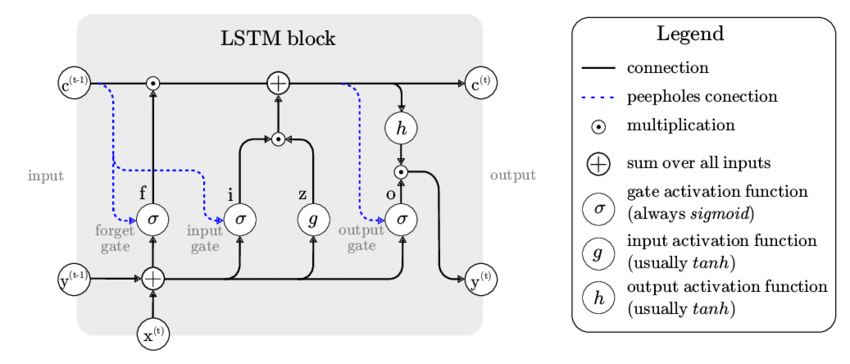

*Van Houdt, Greg & Mosquera, Carlos & Nápoles, Gonzalo. (2020). A Review on the Long Short-Term Memory Model. Artificial Intelligence Review. 53. 10.1007/s10462-020-09838-1.*

En esto caso usamos Una Vanilla LSTM es un modelo LSTM que tiene una sola capa oculta de unidades LSTM, y una capa de salida utilizada para hacer una predicción.

Para el desarrolo del modelo se necesita:
-  Alterar la entrada para poder entranarla con "backpropagation" y generar nuevas entradas.

- La estructura es similar, mantiendo las mismas fechas en entranamiento test y validación sólo que en este modelo se generán las entradas y posteriormente se divide.

- Se obtienen 6 días previos para posteriormente predecir la demanda del séptimo, esto es así porque se eliminan el domingo del conjunto de datos.

- De entrada a la red neuronal con 6 columnas en donde se incluye la cantidad de unidades vendidas en los 6 días anteriores más todas las caracteristicas y de salida la cantidad de unidades vendidas en la fecha actual

- Esos valores se ajustan con backpropagation al igual que nuestra red neuronal. Y finalmente nuestros datos categóricos y númericos enriquecen al modelo.
- Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error.

In [ ]:
## Definición del conjunto de datos

In [ ]:
df_LSTM=df.loc[(df["fecha"]<FechaB)]

In [ ]:
df_LSTM = df_LSTM[df_LSTM['weekday_Sunday']!= 1]


In [ ]:
df_LSTM = df_LSTM.drop(["weekday_Sunday"], axis = 1)


In [ ]:
FechaB

'2019-11-15'

In [ ]:
Nueva_Fecha='2019-11-08'

Para que el conjuto de datos de test pueda generar una predición el modelo necesita los 6 días anteriores a la primera predición de la demanda y luego estas fechas se extraén del conjunto de datos de test

In [ ]:
Nueva_Fecha

'2019-11-08'

In [ ]:
df_estim_LSTM=df.loc[(df["fecha"]>=Nueva_Fecha)&(df["fecha"]<FechaFin)]

In [ ]:
df_estim_LSTM = df_estim_LSTM[df_estim_LSTM['weekday_Sunday']!= 1]


In [ ]:
df_estim_LSTM = df_estim_LSTM.drop(["weekday_Sunday"], axis = 1)


In [ ]:
df_estim_LSTM[df_estim_LSTM['producto']==1].shape

(71, 24)

In [ ]:
PASOS=6
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    print(data.shape)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg

In [ ]:
model_LSTM_val = {}
model_LSTM_test = {}
# For product p id in all products id
for p in products_id:
      ## Generate model for product p


      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)

      print("Generando modelo para producto: {}".format(p))
      #Generacion de datasets
      temp_df = df_LSTM[df_LSTM['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])


      reframed = series_to_supervised(features[:, -1].reshape(-1, 1), PASOS, 1)

      fetures=np.concatenate([features2,features[:, :-1],np.array(reframed)], axis=1)
      fetures = fetures[~np.isnan(fetures).any(axis=1)]
      labels = fetures[:, -1]
      X =fetures[:, :-1]

      # valid
      valid_data = X[X.shape[0]-64:X.shape[0]]
      valid_target=labels[labels.shape[0]-64:labels.shape[0]]

      # train
      training_data = X[0:X.shape[0]-64]
      target_data=labels[0:labels.shape[0]-64]
      x_train = training_data.reshape((training_data.shape[0], 1, training_data.shape[1]))
      val_X = valid_data.reshape((valid_data.shape[0], 1, valid_data.shape[1]))
      #Modelo.
      model = Sequential()
      model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
      model.add(Dense(1))
      model.compile(loss='mae', optimizer='adam')
      history = model.fit(x_train, target_data, epochs=50, batch_size=72, validation_data=(val_X, valid_target), verbose=0, shuffle=False)
      print(val_X.shape)
      # make a prediction con val
      yhat = model.predict(val_X)
      val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
      # invert scaling for forecast
      val_pred=invTransform(scaler,yhat,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0
      val_pred=np.ceil(val_pred)
      val_Y=invTransform(scaler,valid_target,"udsVenta",col_names)
      metricas=final_metric2( val_Y,val_pred)

      df_validaciones.loc[Val_df_Y.index, 'predictions_LSTM'] = np.ceil(val_pred)

      model_product_dict = {'clf': history, 'metrics': metricas}
      model_LSTM_val[p] = model_product_dict




      #make a prediction con test
      Estimar_df2 = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)

      Estimar_df = df_estim_LSTM[df_estim_LSTM['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[col_names]
      features2test=np.array(Estimar_df[cat_columns])

      feat_test = scaler.transform(feat_test_Y.values)

      reframed2 = series_to_supervised(feat_test[:, -1].reshape(-1, 1), PASOS, 1)
      
      fetures_test=np.concatenate([features2test,feat_test[:, :-1],np.array(reframed2)], axis=1)
      fetures_test = fetures_test[~np.isnan(fetures_test).any(axis=1)]
      labels_test = fetures_test[:, -1]
      X_test =fetures_test[:, :-1]  


      final_Test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

      yhat_fin = model.predict(final_Test)

      test_pred=invTransform(scaler,yhat_fin,"udsVenta",col_names)
      test_pred[test_pred < 0] = 0
      test_pred=np.ceil(test_pred)
      TEST_Y=invTransform(scaler,labels_test,"udsVenta",col_names)
      print("### Validaciones Finales###")
      test_metricas=final_metric2( TEST_Y,test_pred)
      print("-----------------------------------------------------")

      df_predictions.loc[df_predictions.producto==p, 'predictions_LSTM'] = np.ceil(test_pred)
      model_product_dict = {'clf': history, 'metrics': test_metricas}
      model_LSTM_test[p] = model_product_dict





Generando modelo para producto: 1
(1317, 1)
(64, 1, 27)
RMSE: 1240.074506330164
rRMSE: 0.42668771521344123
MAE: 755.4375
MAPE: nan
sMAPE: nan
(71, 1)
### Validaciones Finales###
RMSE: 1659.7593199015332
rRMSE: 0.57425310079683
MAE: 1128.0461538461539
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 2
(1196, 1)
(64, 1, 27)
RMSE: 497.40891125913697
rRMSE: 0.2684479645201353
MAE: 389.0
MAPE: nan
sMAPE: nan
(71, 1)
### Validaciones Finales###
RMSE: 446.9500058086001
rRMSE: 0.2674991978045118
MAE: 332.3076923076923
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para producto: 3
(1317, 1)
(64, 1, 27)
RMSE: 580.0083377633463
rRMSE: 0.25022098682755195
MAE: 468.703125
MAPE: nan
sMAPE: nan
(71, 1)
### Validaciones Finales###
RMSE: 471.5520201338424
rRMSE: 0.2553261358870746
MAE: 359.7692307692308
MAPE: nan
sMAPE: nan
-----------------------------------------------------
Generando modelo para p

In [ ]:
metricas_totales_val(model_LSTM_val,"LSTM")

In [ ]:
metricas_totales_pred(model_LSTM_test,"LSTM")

**Conclusiones** Este tipo de Arquitectura aunque es simple se adapta completamente a los datos, lográ entrenarse de una manera bastante precisa y com los datos de test las prediciones son muy buenas. Dado que el batch_size es muy grande en un primer momento se pensaba que podría caer en overfitting pero viendo los resultados en modelo predice la demanda correctamente 

# 10 Conclusiones

In [ ]:
df_metricas_pred.to_csv("/content/gdrive/MyDrive/TFM/3/Metricas_pred_24_05.csv", index = False)


In [ ]:
df_metricas_val.to_csv("/content/gdrive/MyDrive/TFM/3/Metricas_val_24_05.csv", index = False)


In [ ]:
df_predictions.to_csv("/content/gdrive/MyDrive/TFM/3/prediciones_fin_24_05.csv", index = False)


In [ ]:
df_validaciones.to_csv("/content/gdrive/MyDrive/TFM/3/prediciones_val_24_05.csv", index = False)


## Conclusiones Generales

In [3]:
df_metricas_pred=pd.read_csv(ruta+"Metricas_pred_24_05.csv")


In [4]:
conclusiones=df_metricas_pred[["producto","modelo","RMSE","rRMSE"]]

In [5]:
conclusiones.drop_duplicates(inplace=True)

In [6]:
conclusiones=conclusiones.sort_values(by=["producto","rRMSE"])

In [7]:
conclusiones

producto   modelo          RMSE       rRMSE
490         1     LSTM   1659.759320    0.574253
420         1    STCK2   2058.010114    0.712042
70          1      XGB   2122.929565    0.734503
350         1     XGB2   2363.300515    0.817668
0           1  SARIMAX   3618.734626    1.252031
..        ...      ...           ...         ...
489        99    STCK2    184.134524    1.170080
139        99      XGB    210.678720    1.338754
209        99      SVR    219.180256    1.392777
419        99     XGB2    231.501221    1.471070
69         99  SARIMAX  17070.501990  108.474204

[420 rows x 4 columns]

Se elige como métrica de validación el rRMSE estableciendo mejor modelo cuanto menor sea el porcentaje de variación


[Explicación1 ](https://linkinghub.elsevier.com/retrieve/pii/S1364032115013258//) y [Explicación 2](https://www.sciencedirect.com/science/article/abs/pii/S0196890413001118)

RMSE: error cuadrático medio relativo. Este indicador se calcula dividiendo el RMSE entre la media de los datos  la precisión del modelo se considera excelente cuando el RRMSE es del 10%, buena si es del 10% o del 20%, regular si es del 20% o del 30% y mala si es> 30%.

87 Modelos dentro del limite 

In [8]:
conclusiones.loc[conclusiones["rRMSE"]<0.30]

producto modelo        RMSE     rRMSE
491         2   LSTM  446.950006  0.267499
71          2    XGB  491.536930  0.294184
421         2  STCK2  492.767741  0.294921
492         3   LSTM  471.552020  0.255326
493         4   LSTM  767.468135  0.235427
..        ...    ...         ...       ...
556        96   LSTM   46.290222  0.219337
557        97   LSTM   54.629099  0.237391
558        98   LSTM   28.674835  0.167073
488        98  STCK2   48.963880  0.285286
138        98    XGB   50.327084  0.293229

[89 rows x 4 columns]

24 modelos buenos

In [9]:
conclusiones.loc[conclusiones["rRMSE"]<0.20]

producto modelo        RMSE     rRMSE
494         5   LSTM  312.740344  0.160056
424         5  STCK2  365.908774  0.187267
502        17   LSTM  208.405411  0.153566
432        17  STCK2  251.349466  0.185210
82         17    XGB  260.317853  0.191818
505        20   LSTM  158.225253  0.148590
435        20  STCK2  208.372448  0.195683
506        21   LSTM   80.250569  0.099169
436        21  STCK2  134.521317  0.166234
86         21    XGB  147.259896  0.181975
509        26   LSTM  121.815687  0.188242
514        36   LSTM   86.219487  0.199917
516        38   LSTM   82.775600  0.180824
523        49   LSTM  138.634106  0.197970
524        50   LSTM   83.189496  0.198550
531        61   LSTM   73.331282  0.180182
538        72   LSTM   45.021704  0.123290
468        72  STCK2   62.711550  0.171733
118        72    XGB   65.084797  0.178232
539        73   LSTM   41.147016  0.186784
549        87   LSTM   38.398718  0.161245
414        93   XGB2   27.422338  0.160857
558        98   LSTM   28.674835  0.167073

**Indicar como medidas generales que LSTM gana por amplia mayoría a los demás modelos pero tanto el Stacking complejo y el modelo simple XGB tienen modelos igualmente validos**

## Mejores Modelos

In [10]:
best_models=conclusiones.groupby(['producto'], as_index=False)[["modelo",'rRMSE']].min()

En todos los modelos por producto predice la red Neuronal mejor que los otros modelos excepto en el producto 92 que da un error y se observa que es un producto que no tiene ventas. En la actualización del modelo no se tendrá en cuenta

De 69 productos a priori 35 predicen de una manera adecuada con la creación de una red LSTM simple. Es decir que con 35 productos este modelo sería adecuado para la previsión de la demanda en un escenario normal

In [11]:
best_models.loc[best_models["rRMSE"]<0.30].shape

(34, 3)

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
best_models

producto modelo     rRMSE
0          1   LSTM  0.574253
1          2   LSTM  0.267499
2          3   LSTM  0.255326
3          4   LSTM  0.235427
4          5   LSTM  0.160056
5          9   LSTM  0.610647
6         10   LSTM  0.272055
7         11   LSTM  0.436367
8         12   LSTM  0.335309
9         13   LSTM  0.237238
10        14   LSTM  0.396307
11        15   LSTM  0.604534
12        17   LSTM  0.153566
13        18   LSTM  0.379380
14        19   LSTM  0.332682
15        20   LSTM  0.148590
16        21   LSTM  0.099169
17        23   LSTM  0.351638
18        24   LSTM  0.216183
19        26   LSTM  0.188242
20        30   LSTM  0.317142
21        31   LSTM  0.567636
22        32   LSTM  0.327254
23        35   LSTM  0.331423
24        36   LSTM  0.199917
25        37   LSTM  0.301513
26        38   LSTM  0.180824
27        40   LSTM  0.382428
28        42   LSTM  0.310319
29        43   LSTM  0.329066
30        45   LSTM  0.400440
31        46   LSTM  0.319525
32        48   LSTM  0.293543
33        49   LSTM  0.197970
34        50   LSTM  0.198550
35        52   LSTM  0.205505
36        53   LSTM  0.276604
37        55   LSTM  0.279069
38        58   LSTM  0.607270
39        59   LSTM  0.255043
40        60   LSTM  0.214992
41        61   LSTM  0.180182
42        62   LSTM  0.503867
43        63   LSTM  0.393968
44        64   LSTM  0.430469
45        66   LSTM  0.332881
46        67   LSTM  0.236952
47        69   LSTM  0.313550
48        72   LSTM  0.123290
49        73   LSTM  0.186784
50        74   LSTM  0.274819
51        75   LSTM  0.204343
52        78   LSTM  0.337780
53        79   LSTM  0.310756
54        80   LSTM  0.780558
55        81   LSTM  0.811132
56        83   LSTM  0.782846
57        84   LSTM  0.378124
58        85   LSTM  0.312082
59        87   LSTM  0.161245
60        88   LSTM  0.337639
61        89   LSTM  0.244145
62        91   LSTM  0.315197
63        92   LSTM       inf
64        93   LSTM  0.160857
65        94   LSTM  0.200820
66        96   LSTM  0.219337
67        97   LSTM  0.237391
68        98   LSTM  0.167073
69        99   LSTM  0.679838

## Comparación con Previsión de empresa

Se compara erro de la previsión de la empresa con los diferentes modelos

In [ ]:
metricas=pd.read_csv(ruta+"Metricas_pred_24_05.csv")


In [ ]:
metricas

producto   modelo          RMSE     rRMSE           MAE  MAPE       sMAPE
0           1  SARIMAX   3618.734626  1.252031   2668.169231   NaN         NaN
1           2  SARIMAX  15592.474030  9.332082  15433.076923   inf  165.006162
2           3  SARIMAX  15414.683542  8.346421  15257.061538   inf  161.899273
3           4  SARIMAX  14037.802818  4.306217  13844.030769   inf  138.050437
4           5  SARIMAX  15254.587417  7.807097  15149.984615   inf  159.796003
..        ...      ...           ...       ...           ...   ...         ...
555        94     LSTM     36.657458  0.200820     26.200000   NaN         NaN
556        96     LSTM     46.290222  0.219337     35.800000   NaN         NaN
557        97     LSTM     54.629099  0.237391     40.461538   NaN         NaN
558        98     LSTM     28.674835  0.167073     22.430769   inf   42.958753
559        99     LSTM    106.985621  0.679838     76.230769   NaN         NaN

[420 rows x 7 columns]

In [ ]:
metricas.drop_duplicates(inplace=True)

In [ ]:
previsiones=pd.read_csv(ruta+"MODELAR_FINAL.csv")


In [ ]:
previsiones=previsiones[previsiones['weekday_Sunday']!= 1]

In [ ]:
previsiones=previsiones[["fecha","producto","udsVenta","udsPrevisionEmpresa"]]

In [ ]:
previsiones=previsiones.loc[(previsiones["fecha"]>=FechaB)&(previsiones["fecha"]<FechaFin)]

In [ ]:
products_id = previsiones['producto'].drop_duplicates()

In [ ]:
df_metricas_empresa= pd.DataFrame(columns=['producto','RMSE_empresa', 'rRMSE_empresa','MAE_empresa','MAPE_empresa','sMAPE_empresa'])

In [ ]:
diccionario={}
for p in products_id:
 
    print("Generando Costes para producto: {}".format(p))
    x=final_metric2(previsiones.loc[previsiones["producto"]==p,"udsVenta"],previsiones.loc[previsiones["producto"]==p,"udsPrevisionEmpresa"] )
    model_metrics = { 'metrics': x}
    diccionario[p] = model_metrics

Generando Costes para producto: 1
RMSE: 15376.684736714467
rRMSE: 5.320114057595667
MAE: 11917.923076923076
MAPE: inf
sMAPE: 128.34869667491762
Generando Costes para producto: 2
RMSE: 7567.879913464231
rRMSE: 4.5293696825668714
MAE: 6772.753846153846
MAPE: inf
sMAPE: 130.01724871633067
Generando Costes para producto: 3
RMSE: 8574.087266068258
rRMSE: 4.642517637359319
MAE: 7670.969230769231
MAPE: inf
sMAPE: 131.03565709426314
Generando Costes para producto: 4
RMSE: 14832.553539168759
rRMSE: 4.550013356014447
MAE: 13664.984615384616
MAPE: inf
sMAPE: 133.21938970955716
Generando Costes para producto: 5
RMSE: 8991.47475282944
rRMSE: 4.6017184930941335
MAE: 8320.6
MAPE: inf
sMAPE: 131.9821806577833
Generando Costes para producto: 9
RMSE: 6602.725260189043
rRMSE: 4.038630085371775
MAE: 5416.153846153846
MAPE: inf
sMAPE: 133.2961485753904
Generando Costes para producto: 10
RMSE: 6164.681281923041
rRMSE: 4.07538707448916
MAE: 4966.169230769231
MAPE: inf
sMAPE: 136.55083766000675
Generando Cost

In [ ]:
  for i in diccionario:
    row = [i,  diccionario[i]['metrics']['RMSE'],diccionario[i]['metrics']['rRMSE'],diccionario[i]['metrics']['MAE'],diccionario[i]['metrics']['MAPE'],diccionario[i]['metrics']['sMAPE']]
    df_metricas_empresa.loc[len(df_metricas_empresa)] = row

In [ ]:
cmp_metricas=pd.merge(metricas[["producto","modelo","RMSE","rRMSE"]], df_metricas_empresa[["producto","RMSE_empresa","rRMSE_empresa"]], how="left",on="producto")

**Comparación con Previsiones de empresa**

In [ ]:
models = cmp_metricas['modelo'].drop_duplicates()

In [ ]:
for p in models:
 
    print("Generando Costes para producto: {}".format(p))

    cmp1=cmp_metricas.loc[cmp_metricas["modelo"]==p,["producto","rRMSE","rRMSE_empresa"]]
    print("Modelo", p, "es peor que la previsión de empresa en:{} productos".format(cmp1.loc[cmp1["rRMSE"]>cmp1["rRMSE_empresa"]].count()[0]))
    print("---------------------")

Generando Costes para producto: SARIMAX
Modelo SARIMAX es peor que la previsión de empresa en:67 productos
---------------------
Generando Costes para producto: XGB
Modelo XGB es peor que la previsión de empresa en:0 productos
---------------------
Generando Costes para producto: SVR
Modelo SVR es peor que la previsión de empresa en:1 productos
---------------------
Generando Costes para producto: XGB2
Modelo XGB2 es peor que la previsión de empresa en:0 productos
---------------------
Generando Costes para producto: STCK2
Modelo STCK2 es peor que la previsión de empresa en:0 productos
---------------------
Generando Costes para producto: LSTM
Modelo LSTM es peor que la previsión de empresa en:0 productos
---------------------


**Conclusiones** Todos los modelos planteados exceptos el ARIMAX son mejores que la previsión actual que realiza la empresa (excepto en un producto el SVR)

# 11 Calculo de Costes

Se compara los costes que acarrearía seguir con la previsión actual de la empresa contra el mejor modelo 

In [ ]:
costes=pd.read_csv(ruta+"MODELAR_FINAL.csv")


In [ ]:
costes=costes[costes['weekday_Sunday']!= 1]

In [ ]:
costes=costes[["fecha","producto","udsVenta","precio","udsPrevisionEmpresa"]]

In [ ]:
costes=costes.loc[(costes["fecha"]>=FechaB)&(costes["fecha"]<FechaFin)]

In [ ]:
costes.shape

(4550, 5)

In [ ]:
x=pd.merge(costes[["fecha""udsVenta","precio","udsPrevisionEmpresa"]], df_predictions[["predictions_LSTM"]], left_index=True, right_index=True)

In [ ]:
df_costes=x

In [ ]:
x.index=x["fecha"]

In [ ]:
x.head()

fecha  producto  ...  udsPrevisionEmpresa  predictions_LSTM
1600  2019-11-15         1  ...               5288.0            2784.0
1601  2019-11-16         1  ...              21151.0            2178.0
1603  2019-11-18         1  ...               7465.0            6066.0
1604  2019-11-19         1  ...              12317.0            2658.0
1605  2019-11-20         1  ...              36578.0            2617.0

[5 rows x 6 columns]

Antes de calcular los Costes Observamos algunas predicciones (Verde) Frente a las unidas de vendidas(rojo), que el modelo LSTM es claramente superior a las previsiones de la empresa

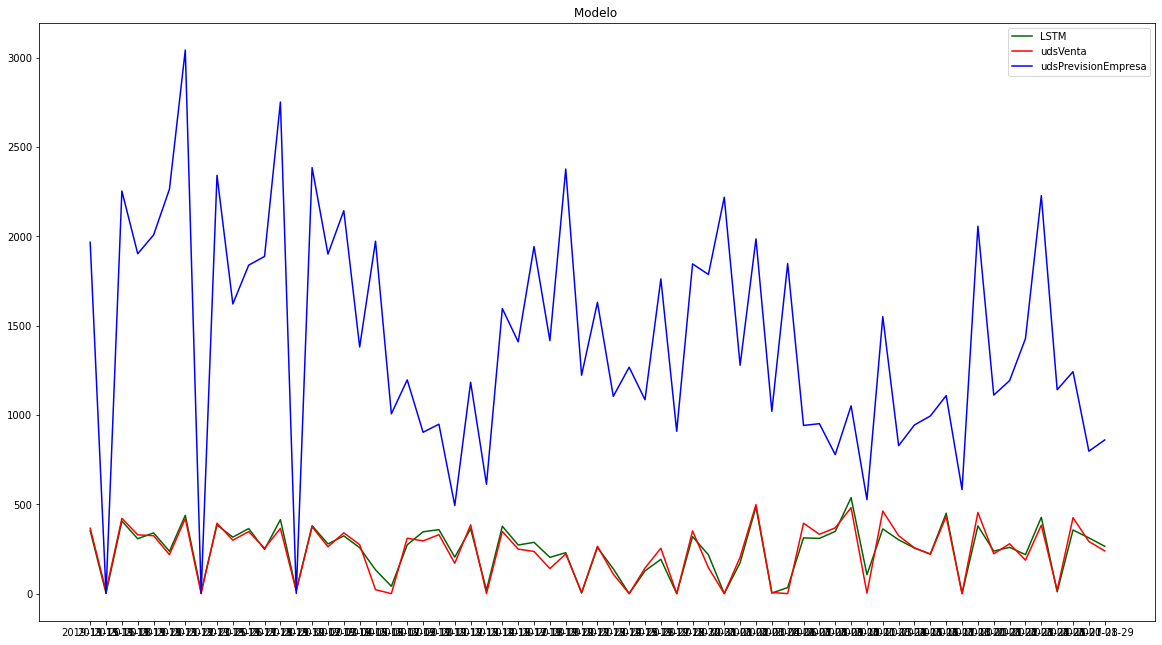

In [ ]:
# Plot
plt.rcParams["figure.figsize"] = (20,11)

plt.plot(x['predictions_LSTM'].loc[x["producto"]==87], color='darkgreen', label='LSTM')
plt.plot(x['udsVenta'].loc[x["producto"]==87], color='red', label='udsVenta')
plt.plot(x['udsPrevisionEmpresa'].loc[x["producto"]==87], color='blue', label='udsPrevisionEmpresa')




plt.title("Modelo ")
plt.legend()
plt.show()

### Conclusion del modelo:

La red LSTM se adapta a toda la variabilidad de la serie temporal debiod a que  LSTM es una gran herramienta para cualquier problema que tenga una secuencia.  En este caso a ser una secuencia semanal y con variables Exógenas y Endogenas de las que aprende el modelo, en varios productos obtenemos una previsión muy acertada para unos datos que el modelo no había ni visto.

Esto se observa en el la figura inferior para el producto 87

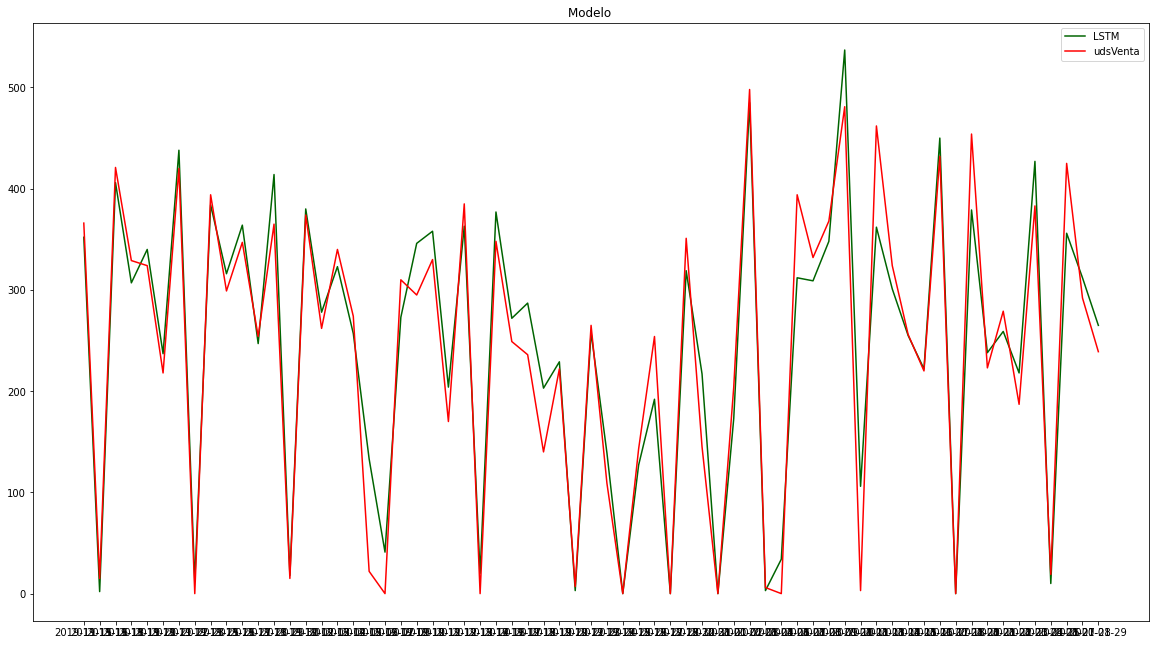

In [ ]:
# Plot
plt.rcParams["figure.figsize"] = (20,11)

plt.plot(x['predictions_LSTM'].loc[x["producto"]==87], color='darkgreen', label='LSTM')
plt.plot(x['udsVenta'].loc[x["producto"]==87], color='red', label='udsVenta')




plt.title("Modelo ")
plt.legend()
plt.show()

Estimamos las unidades en stock para la previsión de la empresa y para la
previsión estimada con nuestro modelo:

Suponemos Leadtime de aprovisionamiento = 1 día
- Stock= stock de seguridad + previsión para ese día
- Stock de seguridad = Factor servicio *RMSE
- **RMSE = Root Mean Squared Error. Entiendo RMSE como la diferencia de las ventas con la previsión. Al ser un RMSE de solo dos datos no existe media ni sumatorio y la raiz cuadrada del cuadrado de la diferencia es la resta**

stock= prevision+1.64*RMSE

  Calculamos el Coste total = Coste stock + coste ventas perdidas
- Cuando el stock es más alto que la venta real, incurrimos en coste de stock.
- Cuando el stock es más bajo que la venta real, incurrimos en coste de stock + coste de
venta perdida.

In [ ]:
df_costes["precio"].replace(0, 3.6140, inplace=True)


In [ ]:
df_Costes_Modelo = pd.DataFrame(index=df_costes.index, data=np.zeros((df_costes.shape[0],)), columns= ['predictions'])


In [ ]:
df_Costes_Modelo["producto"]=df_costes[["producto"]]

In [ ]:
df_Costes_Modelo["fecha"]=df_costes[["fecha"]]

In [ ]:
  for p in products_id: 
    print("Generando Costes para producto: {}".format(p))

    df1=df_costes.loc[df_costes["producto"]==p]
    df1["RMSE_diario"]= df1["predictions_LSTM"] - df1["udsVenta"]
    df1["Stock"]=df1["udsVenta"]+(1.64*df1["RMSE_diario"])
    df1["Coste_almacenaje"]=(df1["precio"]*0.05)*(df1["Stock"])
    df1["Rotura_Stock"]=0 
    df1.loc[df1["RMSE_diario"]<0,"Rotura_Stock"]=abs(df1["RMSE_diario"])
    df1["Coste_venta"]=df1["Rotura_Stock"]*0.15*df1["precio"]
    df1["Coste_Total"]=df1["Coste_venta"]+df1["Coste_almacenaje"]
    print(df1["Coste_Total"].sum())

    df1["RMSE_diario_empresa"]= df1["udsPrevisionEmpresa"] - df1["udsVenta"]
    df1["Stock_empresa"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_empresa"])
    df1["Coste_almacenaje_empresa"]=(df1["precio"]*0.05)*(df1["Stock_empresa"])
    df1["Rotura_Stock_empresa"]=0 
    df1.loc[df1["RMSE_diario_empresa"]<0,"Rotura_Stock_empresa"]=abs(df1["RMSE_diario_empresa"])
    df1["Coste_venta_empresa"]=df1["Rotura_Stock_empresa"]*0.15*df1["precio"]
    df1["Coste_Total_empresa"]=df1["Coste_venta_empresa"]+df1["Coste_almacenaje_empresa"]
    
    print(df1["Coste_Total_empresa"].sum())
    df_Costes_Modelo.loc[df1.index, "CostesModelo"]=df1.loc[:,"Coste_Total"]
    df_Costes_Modelo.loc[df1.index, "CostesEmpresa"]=df1.loc[:,"Coste_Total_empresa"] 


Generando Costes para producto: 1
51918.8732172
252589.99953769997
Generando Costes para producto: 2
28422.387606959997
169403.54985648
Generando Costes para producto: 3
23257.766139299998
139931.93500109998
Generando Costes para producto: 4
44530.03799712
273215.85101694
Generando Costes para producto: 5
16484.38128
110878.927326
Generando Costes para producto: 9
23733.05775776
106143.28075519999
Generando Costes para producto: 10
18691.687169999997
93715.6223796
Generando Costes para producto: 11
21765.237363580003
114304.13457254
Generando Costes para producto: 12
12229.126632
80218.57563359999
Generando Costes para producto: 13
17377.5123576
112079.44569888
Generando Costes para producto: 14
16376.111465180002
81212.09929833999
Generando Costes para producto: 15
6728.841091440001
32487.854897160003
Generando Costes para producto: 17
17886.1682656
110449.1791326
Generando Costes para producto: 18
20371.083076260005
102656.88241428
Generando Costes para producto: 19
18049.43460000000

In [ ]:
df_Costes_Modelo.to_csv("/content/gdrive/MyDrive/TFM/3/costes_24_05.csv", index = False)


In [ ]:
df=pd.read_csv(ruta+"costes_24_05.csv")


In [ ]:
df = df.drop(["predictions"], axis = 1)


In [ ]:
df['CostesModelo'] = df['CostesModelo'].apply(np.ceil)

In [ ]:
df['CostesEmpresa'] = df['CostesEmpresa'].apply(np.ceil)

In [ ]:
df.head(10)

producto       fecha  CostesModelo  CostesEmpresa
0         1  2019-11-15         559.0         1281.0
1         1  2019-11-16         594.0         6070.0
2         1  2019-11-18        1296.0         1699.0
3         1  2019-11-19         627.0         3415.0
4         1  2019-11-20         581.0        10382.0
5         1  2019-11-21         865.0         8056.0
6         1  2019-11-22         502.0         2341.0
7         1  2019-11-23         337.0         8386.0
8         1  2019-11-25        1026.0         1522.0
9         1  2019-11-26         551.0         3057.0

### Conclusiones de Costes

Una vez calculado la previsión de costes con la previsión de empresas frente al escenario propuesto de previsión con el modelo que más se aproxima, se observa en la visualización dinamica inferior como mejora el coste.

Se  gráfica la estimación de costes para cada día y por producto en una gráfica viendo la evolución por escenario, en un gráfico dinámico

Por último se calcula en una tabla el Coste Total por escenario y día. Viendo como nuestra solución mejora por mayoría la previsión actual de la empresa.


In [ ]:
from plotly import tools
from plotly.tools import FigureFactory as FF
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
warnings.filterwarnings("ignore")
import plotly.express as px
init_notebook_mode()
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Output hidden; open in https://colab.research.google.com to view.

In [ ]:



df_long=pd.melt(df.sort_values(['fecha','producto']), id_vars=['fecha',"producto"], value_vars=df.columns[2:4])


lines_chart = px.line(df_long.sort_values(['fecha','producto']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['navy','royalblue'],
                      animation_frame = 'producto')
fig = go.Figure(lines_chart, layout_yaxis_range=[0,7000])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_traces(textposition='top center', textfont_size=11)  
fig.update_layout(height = 400)
fig.show(renderer="colab")


In [ ]:



df_long=pd.melt(df.sort_values(['fecha','producto']), id_vars=['fecha',"producto"], value_vars=df.columns[2:4])


lines_chart = px.line(df_long.sort_values(['fecha','producto']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['navy','royalblue'],
                      animation_frame = 'producto')
fig = go.Figure(lines_chart, layout_yaxis_range=[0,7000])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_traces(textposition='top center', textfont_size=11)  
fig.update_layout(height = 400)
fig.show()

In [ ]:
costes_totales=df.groupby(['fecha'], as_index=False)[["CostesModelo",'CostesEmpresa']].sum()

In [ ]:
pd.set_option('display.max_rows', 65)

In [ ]:
costes_totales["Reduccion_Costes"]=(((costes_totales["CostesModelo"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)

In [ ]:
costes_totales

fecha  CostesModelo  CostesEmpresa  Reduccion_Costes
0   2019-11-15       14613.0        83557.0             -82.0
1   2019-11-16        6998.0        45645.0             -84.0
2   2019-11-18       10605.0        79235.0             -86.0
3   2019-11-19        9467.0        75911.0             -87.0
4   2019-11-20        9498.0        94859.0             -89.0
5   2019-11-21       11886.0       115833.0             -89.0
6   2019-11-22       16642.0       138867.0             -88.0
7   2019-11-23        5712.0        60806.0             -90.0
8   2019-11-25       11111.0        80527.0             -86.0
9   2019-11-26        8625.0        62424.0             -86.0
10  2019-11-27        9354.0        92906.0             -89.0
11  2019-11-28       12149.0        93383.0             -86.0
12  2019-11-29       12227.0       116392.0             -89.0
13  2019-11-30        5820.0        52361.0             -88.0
14  2019-12-02       11526.0        79011.0             -85.0
15  2019-12-03       13833.0        75439.0             -81.0
16  2019-12-04       15053.0       103163.0             -85.0
17  2019-12-05       15535.0        88299.0             -82.0
18  2019-12-06        9609.0        85396.0             -88.0
19  2019-12-07        4801.0        30466.0             -84.0
20  2019-12-09       12550.0        44516.0             -71.0
21  2019-12-10       10843.0        27764.0             -60.0
22  2019-12-11        9718.0        46217.0             -78.0
23  2019-12-12       12142.0        33566.0             -63.0
24  2019-12-13       14240.0        44325.0             -67.0
25  2019-12-14        3867.0        24111.0             -83.0
26  2019-12-16       10137.0        59316.0             -82.0
27  2019-12-17        8965.0        58101.0             -84.0
28  2019-12-18        9876.0        85411.0             -88.0
29  2019-12-19       12217.0       102085.0             -88.0
30  2019-12-20       11159.0        97021.0             -88.0
31  2019-12-21        6479.0        41413.0             -84.0
32  2019-12-23        9657.0        57377.0             -83.0
33  2019-12-24        7961.0        36912.0             -78.0
34  2019-12-25        2143.0        52296.0             -95.0
35  2019-12-26       11452.0        73308.0             -84.0
36  2019-12-27       13343.0        67423.0             -80.0
37  2019-12-28        3831.0        36439.0             -89.0
38  2019-12-30        9693.0        55956.0             -82.0
39  2019-12-31        8866.0        71011.0             -87.0
40  2020-01-01        1343.0        97916.0             -98.0
41  2020-01-02       11717.0        90858.0             -87.0
42  2020-01-03       14066.0        85294.0             -83.0
43  2020-01-04        4983.0        40676.0             -87.0
44  2020-01-06        3987.0        61350.0             -93.0
45  2020-01-07       12808.0        39539.0             -67.0
46  2020-01-08       12796.0        42123.0             -69.0
47  2020-01-09       14986.0        54540.0             -72.0
48  2020-01-10       15841.0        40125.0             -60.0
49  2020-01-11        7293.0        34968.0             -79.0
50  2020-01-13       14274.0        53948.0             -73.0
51  2020-01-14       12912.0        31559.0             -59.0
52  2020-01-15       12805.0        41741.0             -69.0
53  2020-01-16       15432.0        48871.0             -68.0
54  2020-01-17       12903.0        49217.0             -73.0
55  2020-01-18        3803.0        36362.0             -89.0
56  2020-01-20       12148.0        70889.0             -82.0
57  2020-01-21        8404.0        47140.0             -82.0
58  2020-01-22        8907.0        52334.0             -82.0
59  2020-01-23       12314.0        79528.0             -84.0
60  2020-01-24       12831.0        91884.0             -86.0
61  2020-01-25        5445.0        36620.0             -85.0
62  2020-01-27       12966.0        32881.0             -60.0
63  2020-01-28       10588.0        34952

### Reducción de Costes:
Con el modelo generado se reducen los costes  entre un 60% y un 98% diariamente. Una clara mejoría. se logra el objetivo de mejorar la previsión de la empresa.

| Fecha      	| CostesModelo 	| CostesEmpresa 	| Reduccion_Costes 	|
|------------	|--------------	|---------------	|------------------	|
| 15/11/2019 	| 14670.0      	| 83557.0       	| -82.0            	|
| 16/11/2019 	| 6696.0       	| 45645.0       	| -85.0            	|
| 18/11/2019 	| 10167.0      	| 79235.0       	| -87.0            	|
| 19/11/2019 	| 9194.0       	| 75911.0       	| -87.0            	|
| 20/11/2019 	| 9500.0       	| 94859.0       	| -89.0            	|
| 21/11/2019 	| 11841.0      	| 115833.0      	| -89.0            	|
| 22/11/2019 	| 16458.0      	| 138867.0      	| -88.0            	|
| 23/11/2019 	| 5563.0       	| 60806.0       	| -90.0            	|
| 25/11/2019 	| 10619.0      	| 80527.0       	| -86.0            	|
| 26/11/2019 	| 8312.0       	| 62424.0       	| -86.0            	|
| 27/11/2019 	| 9183.0       	| 92906.0       	| -90.0            	|
| 28/11/2019 	| 11819.0      	| 93383.0       	| -87.0            	|
| 29/11/2019 	| 11971.0      	| 116392.0      	| -89.0            	|
| 30/11/2019 	| 5626.0       	| 52361.0       	| -89.0            	|
| 02/12/2019 	| 11236.0      	| 79011.0       	| -85.0            	|
| 03/12/2019 	| 14133.0      	| 75439.0       	| -81.0            	|
| 04/12/2019 	| 15452.0      	| 103163.0      	| -85.0            	|
| 05/12/2019 	| 15421.0      	| 88299.0       	| -82.0            	|
| 06/12/2019 	| 9545.0       	| 85396.0       	| -88.0            	|
| 07/12/2019 	| 4626.0       	| 30466.0       	| -84.0            	|
| 09/12/2019 	| 12667.0      	| 44516.0       	| -71.0            	|
| 10/12/2019 	| 10677.0      	| 27764.0       	| -61.0            	|
| 11/12/2019 	| 9452.0       	| 46217.0       	| -79.0            	|
| 12/12/2019 	| 11688.0      	| 33566.0       	| -65.0            	|
| 13/12/2019 	| 14156.0      	| 44325.0       	| -68.0            	|
| 14/12/2019 	| 3829.0       	| 24111.0       	| -84.0            	|
| 16/12/2019 	| 10061.0      	| 59316.0       	| -83.0            	|
| 17/12/2019 	| 8739.0       	| 58101.0       	| -84.0            	|
| 18/12/2019 	| 9645.0       	| 85411.0       	| -88.0            	|
| 19/12/2019 	| 12077.0      	| 102085.0      	| -88.0            	|
| 20/12/2019 	| 11091.0      	| 97021.0       	| -88.0            	|
| 21/12/2019 	| 6408.0       	| 41413.0       	| -84.0            	|
| 23/12/2019 	| 9662.0       	| 57377.0       	| -83.0            	|
| 24/12/2019 	| 7875.0       	| 36912.0       	| -78.0            	|
| 25/12/2019 	| 2179.0       	| 52296.0       	| -95.0            	|
| 26/12/2019 	| 11276.0      	| 73308.0       	| -84.0            	|
| 27/12/2019 	| 13417.0      	| 67423.0       	| -80.0            	|
| 28/12/2019 	| 3811.0       	| 36439.0       	| -89.0            	|
| 30/12/2019 	| 9884.0       	| 55956.0       	| -82.0            	|
| 31/12/2019 	| 8703.0       	| 71011.0       	| -87.0            	|
| 01/01/2020 	| 1469.0       	| 97916.0       	| -98.0            	|
| 02/01/2020 	| 11667.0      	| 90858.0       	| -87.0            	|
| 03/01/2020 	| 14144.0      	| 85294.0       	| -83.0            	|
| 04/01/2020 	| 4825.0       	| 40676.0       	| -88.0            	|
| 06/01/2020 	| 3568.0       	| 61350.0       	| -94.0            	|
| 07/01/2020 	| 12374.0      	| 39539.0       	| -68.0            	|
| 08/01/2020 	| 12470.0      	| 42123.0       	| -70.0            	|
| 09/01/2020 	| 15346.0      	| 54540.0       	| -71.0            	|
| 10/01/2020 	| 15606.0      	| 40125.0       	| -61.0            	|
| 11/01/2020 	| 6727.0       	| 34968.0       	| -80.0            	|
| 13/01/2020 	| 14051.0      	| 53948.0       	| -73.0            	|
| 14/01/2020 	| 12482.0      	| 31559.0       	| -60.0            	|
| 15/01/2020 	| 13051.0      	| 41741.0       	| -68.0            	|
| 16/01/2020 	| 15014.0      	| 48871.0       	| -69.0            	|
| 17/01/2020 	| 12868.0      	| 49217.0       	| -73.0            	|
| 18/01/2020 	| 3741.0       	| 36362.0       	| -89.0            	|
| 20/01/2020 	| 12135.0      	| 70889.0       	| -82.0            	|
| 21/01/2020 	| 8280.0       	| 47140.0       	| -82.0            	|
| 22/01/2020 	| 8897.0       	| 52334.0       	| -82.0            	|
| 23/01/2020 	| 12178.0      	| 79528.0       	| -84.0            	|
| 24/01/2020 	| 12654.0      	| 91884.0       	| -86.0            	|
| 25/01/2020 	| 5134.0       	| 36620.0       	| -85.0            	|
| 27/01/2020 	| 13293.0      	| 32881.0       	| -59.0            	|
| 28/01/2020 	| 10441.0      	| 34952.0       	| -70.0            	|
| 29/01/2020 	| 8727.0       	| 46295.0       	| -81.0            	|

# 12 Comparación de modelos

In [ ]:
df_predictions=pd.read_csv(ruta+"prediciones_fin_24_05.csv")


In [ ]:
df_predictions.drop_duplicates(inplace=True)

In [ ]:
ventas=pd.read_csv(ruta+"MODELAR_FINAL.csv")


In [ ]:
ventas=ventas[ventas['weekday_Sunday']!= 1]

In [ ]:
ventas=ventas[["fecha","producto","udsVenta"]]

In [ ]:
ventas=ventas.loc[(ventas["fecha"]>=FechaB)&(ventas["fecha"]<FechaFin)]

In [ ]:
ventas.reset_index(inplace=True)

In [ ]:
ventas.tail()

index       fecha  producto  udsVenta
4545  139398  2020-01-24        99       0.0
4546  139399  2020-01-25        99      97.0
4547  139401  2020-01-27        99       0.0
4548  139402  2020-01-28        99       0.0
4549  139403  2020-01-29        99     972.0

In [ ]:
df_predictions.tail()

predictions  producto  ...  predictions_STCK2  predictions_LSTM
4545          0.0        99  ...               27.0              34.0
4546          0.0        99  ...               80.0             164.0
4547          0.0        99  ...                0.0               2.0
4548          0.0        99  ...                9.0              79.0
4549          0.0        99  ...              427.0             974.0

[5 rows x 8 columns]

In [ ]:
df_fin=pd.merge(ventas[["fecha","udsVenta"]], df_predictions, left_index=True, right_index=True)

In [ ]:
df_fin.columns

Index(['fecha', 'udsVenta', 'predictions', 'producto', 'predictions_SMAX',
       'predictions_SVR', 'predictions_XGB', 'predictions_XG2',
       'predictions_STCK2', 'predictions_LSTM'],
      dtype='object')

In [ ]:
from plotly import tools
from plotly.tools import FigureFactory as FF
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
warnings.filterwarnings("ignore")
import plotly.express as px
init_notebook_mode()
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_fin=df_fin[['fecha', 'producto', 'udsVenta', 
       'predictions_SVR', 'predictions_XGB', 'predictions_XG2','predictions_STCK2', 'predictions_LSTM']]

In [ ]:
df_fin.head(5)

fecha  producto  ...  predictions_STCK2  predictions_LSTM
0  2019-11-15         1  ...              316.0            2784.0
1  2019-11-16         1  ...               63.0            2178.0
2  2019-11-18         1  ...             4870.0            6066.0
3  2019-11-19         1  ...              870.0            2658.0
4  2019-11-20         1  ...             2526.0            2617.0

[5 rows x 8 columns]

In [ ]:
df_long=pd.melt(df_fin.sort_values(['fecha','producto']), id_vars=['fecha',"producto"], value_vars=df_fin.columns[2:8])


In [ ]:
df_long[["variable"]].drop_duplicates()

variable
0               udsVenta
4550     predictions_SVR
9100     predictions_XGB
13650    predictions_XG2
18200  predictions_STCK2
22750   predictions_LSTM

In [ ]:

lines_chart = px.line(df_long.sort_values(['fecha','producto']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b'],
                      animation_frame = 'producto')
fig = go.Figure(lines_chart, layout_yaxis_range=[0,7000])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_traces(textposition='top center', textfont_size=9)  
fig.update_layout(height = 600)
fig.show(renderer="colab")


# 13 Mejoras en Futuro

- Profundizar en Redes Recurrentes.
- Buscar hiperparametros para Redes Recurrentes.
- Mejora del Stacking 2 para que pueda competir contra LSTM
- Crear Modelo para esenarios Adversos
- Modelo por categorías

In [ ]:
costes[["fecha","producto"]].duplicated().sum()

0

In [ ]:
costes.shape

(4550, 7)

In [ ]:
df_predictions.shape

(4550, 8)

In [ ]:
costes.tail()

level_0   index       fecha  ...  udsVenta  precio  udsPrevisionEmpresa
4545     4545  139398  2020-01-24  ...       0.0     0.0               2129.0
4546     4546  139399  2020-01-25  ...      97.0     0.0               1446.0
4547     4547  139401  2020-01-27  ...       0.0     0.0                350.0
4548     4548  139402  2020-01-28  ...       0.0     0.0                321.0
4549     4549  139403  2020-01-29  ...     972.0     0.0               1555.0

[5 rows x 7 columns]

In [ ]:
x=pd.merge(costes[["fecha","udsVenta","producto","precio","udsPrevisionEmpresa"]], df_predictions[["predictions_LSTM","predictions_XGB","predictions_XG2","predictions_STCK2"]], left_index=True, right_index=True)

In [ ]:
x["precio"].replace(0, 3.6140, inplace=True)


In [ ]:
df_costes=x

In [ ]:
df_costes.shape

(4550, 9)

In [ ]:
df_costes.index.duplicated().sum()

0

In [ ]:
#Usar el indice normal

#df_costes.index=df_costes["fecha"]

In [ ]:
df_costes.tail()

fecha  udsVenta  ...  predictions_XG2  predictions_STCK2
4545  2020-01-24       0.0  ...            117.0               27.0
4546  2020-01-25      97.0  ...              0.0               80.0
4547  2020-01-27       0.0  ...             61.0                0.0
4548  2020-01-28       0.0  ...            172.0                9.0
4549  2020-01-29     972.0  ...            192.0              427.0

[5 rows x 9 columns]

In [ ]:
df_Costes_Modelo = pd.DataFrame(index=df_costes.index, data=np.zeros((df_costes.shape[0],)), columns= ['predictions'])


In [ ]:
df_Costes_Modelo["producto"]=df_costes[["producto"]]

In [ ]:
df_Costes_Modelo["fecha"]=df_costes[["fecha"]]

In [ ]:
pd.set_option('display.max_rows', 65)

In [ ]:
df1.index.duplicated().sum()

0

In [ ]:
df1[["Coste_Total_empresa"]]

Coste_Total_empresa
fecha                          
2019-11-15           244.783448
2019-11-16           207.197848
2019-11-18           732.326504
2019-11-19            55.298537
2019-11-20           525.482828
2019-11-21            31.175810
2019-11-22           380.554200
2019-11-23           308.794616
2019-11-25           604.846268
2019-11-26            49.631785
2019-11-27           599.179516
2019-11-28            31.175810
2019-11-29           322.722972
2019-11-30           254.758088
2019-12-02           587.658084
2019-12-03            78.666661
2019-12-04           645.149596
2019-12-05           326.396242
2019-12-06           277.135976
2019-12-07           195.589680
2019-12-09           259.304500
2019-12-10            57.770513
2019-12-11           410.441980
2019-12-12            98.394764
2019-12-13            99.276580
2019-12-14           123.078384
2019-12-16           317.439304
2019-12-17            72.012564
2019-12-18           591.604572
2019-12-19           345.541768
2019-12-20           302.571308
2019-12-21           230.573200
2019-12-23           210.790164
2019-12-24            57.491512
2019-12-25           414.887200
2019-12-26           265.614544
2019-12-27           270.862072
2019-12-28           248.339624
2019-12-30           252.033132
2019-12-31           100.758320
2020-01-01           725.756252
2020-01-02           405.295644
2020-01-03           319.759492
2020-01-04           272.640160
2020-01-06           371.620392
2020-01-07            57.491512
2020-01-08           311.165400
2020-01-09           249.973152
2020-01-10           182.846716
2020-01-11           141.314628
2020-01-13           311.165400
2020-01-14            46.851896
2020-01-15           371.620392
2020-01-16           185.571672
2020-01-17           261.429532
2020-01-18           257.822760
2020-01-20           244.783448
2020-01-21            92.503944
2020-01-22           536.780192
2020-01-23           288.050256
2020-01-24           630.924892
2020-01-25           417.301352
2020-01-27           103.721800
2020-01-28            95.127708
2020-01-29           348.411284

In [ ]:

for p in products_id: 
    print("Generando Costes para producto: {}".format(p))

    df1=df_costes.loc[df_costes["producto"]==p]
    #df1.index=df1["fecha"]
    df1["RMSE_diario"]= df1["predictions_LSTM"]-df1["udsVenta"]
    df1["Stock"]=df1["udsVenta"]+(1.64*df1["RMSE_diario"])
    df1["Coste_almacenaje"]=(df1["precio"]*0.05)*(df1["Stock"])
    df1["Rotura_Stock"]=0 
    df1.loc[df1["RMSE_diario"]<0,"Rotura_Stock"]=abs(df1["RMSE_diario"])
    df1["Coste_venta"]=df1["Rotura_Stock"]*0.15*df1["precio"]
    df1["Coste_Total"]=df1["Coste_venta"]+df1["Coste_almacenaje"]
    print(df1["Coste_Total"].sum())

    df1["RMSE_diario_empresa"]= df1["udsPrevisionEmpresa"] - df1["udsVenta"]
    df1["Stock_empresa"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_empresa"])
    df1["Coste_almacenaje_empresa"]=(df1["precio"]*0.05)*(df1["Stock_empresa"])
    df1["Rotura_Stock_empresa"]=0 
    df1.loc[df1["RMSE_diario_empresa"]<0,"Rotura_Stock_empresa"]=abs(df1["RMSE_diario_empresa"])
    df1["Coste_venta_empresa"]=df1["Rotura_Stock_empresa"]*0.15*df1["precio"]
    df1["Coste_Total_empresa"]=df1["Coste_venta_empresa"]+df1["Coste_almacenaje_empresa"]
    
    print(df1["Coste_Total_empresa"].sum())


    df1["RMSE_diario_XGB"]= df1["predictions_XGB"] - df1["udsVenta"]
    df1["Stock_XGB"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_XGB"])
    df1["Coste_almacenaje_XGB"]=(df1["precio"]*0.05)*(df1["Stock_XGB"])
    df1["Rotura_Stock_XGB"]=0 
    df1.loc[df1["RMSE_diario_XGB"]<0,"Rotura_Stock_XGB"]=abs(df1["RMSE_diario_XGB"])
    df1["Coste_venta_XGB"]=df1["Rotura_Stock_XGB"]*0.15*df1["precio"]
    df1["Coste_Total_XGB"]=df1["Coste_venta_XGB"]+df1["Coste_almacenaje_XGB"]
    print(df1["Coste_Total_XGB"].sum())

    df1["RMSE_diario_STCK2"]= df1["predictions_STCK2"] - df1["udsVenta"]
    df1["Stock_STCK2"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_STCK2"])
    df1["Coste_almacenaje_STCK2"]=(df1["precio"]*0.05)*(df1["Stock_STCK2"])
    df1["Rotura_Stock_STCK2"]=0 
    df1.loc[df1["RMSE_diario_STCK2"]<0,"Rotura_Stock_STCK2"]=abs(df1["RMSE_diario_STCK2"])
    df1["Coste_venta_STCK2"]=df1["Rotura_Stock_STCK2"]*0.15*df1["precio"]
    df1["Coste_Total_STCK2"]=df1["Coste_venta_STCK2"]+df1["Coste_almacenaje_STCK2"]
    print(df1["Coste_Total_STCK2"].sum())

    df1["RMSE_diario_XGB2"]= df1["predictions_XG2"] - df1["udsVenta"]
    df1["Stock_XGB2"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_XGB2"])
    df1["Coste_almacenaje_XGB2"]=(df1["precio"]*0.05)*(df1["Stock_XGB2"])
    df1["Rotura_Stock_XGB2"]=0 
    df1.loc[df1["RMSE_diario_XGB2"]<0,"Rotura_Stock_XGB2"]=abs(df1["RMSE_diario_XGB2"])
    df1["Coste_venta_XGB2"]=df1["Rotura_Stock_XGB2"]*0.15*df1["precio"]
    df1["Coste_Total_XGB2"]=df1["Coste_venta_XGB2"]+df1["Coste_almacenaje_XGB2"]
    print(df1["Coste_Total_XGB2"].sum())

    df_Costes_Modelo.loc[df1.index, "CostesModelo"]=df1.loc[:,"Coste_Total"]
    df_Costes_Modelo.loc[df1.index, "CostesEmpresa"]=df1.loc[:,"Coste_Total_empresa"] 
    df_Costes_Modelo.loc[df1.index, "Coste_Total_XGB"]=df1.loc[:,"Coste_Total_XGB"] 
    df_Costes_Modelo.loc[df1.index, "Coste_Total_STCK2"]=df1.loc[:,"Coste_Total_STCK2"] 
    df_Costes_Modelo.loc[df1.index, "Coste_Total_XGB2"]=df1.loc[:,"Coste_Total_XGB2"] 



Generando Costes para producto: 1
51918.8732172
252589.99953769997
53531.0002183
51166.61624140001
60475.637442
Generando Costes para producto: 2
28422.387606959997
169403.54985648
29410.84149984
29280.07994688
33075.11013624
Generando Costes para producto: 3
23257.766139299998
139931.93500109998
25634.1604365
23831.4244608
26351.210952
Generando Costes para producto: 4
44530.03799712
273215.85101694
50055.16088196001
47111.46204258
55436.00785631999
Generando Costes para producto: 5
16484.38128
110878.927326
17059.378571999998
16887.397266
17423.238509999996
Generando Costes para producto: 9
23733.05775776
106143.28075519999
30293.99585056
26665.445077440003
30816.94409248
Generando Costes para producto: 10
18691.687169999997
93715.6223796
20076.650724000003
19809.108618
21492.714906
Generando Costes para producto: 11
21765.237363580003
114304.13457254
24670.938995300006
22607.70191382
24664.386950980002
Generando Costes para producto: 12
12229.126632
80218.57563359999
11879.101655999

In [ ]:
df_Costes_Modelo.loc[df_Costes_Modelo["producto"]==1].sum()

predictions                                                          0
producto                                                            65
fecha                2019-11-152019-11-162019-11-182019-11-192019-1...
CostesModelo                                                   51918.9
CostesEmpresa                                                   252590
Coste_Total_XGB                                                  53531
Coste_Total_STCK2                                              51166.6
Coste_Total_XGB2                                               60475.6
dtype: object

In [ ]:
df_Costes_Modelo = df_Costes_Modelo.drop(["predictions"], axis = 1)


In [ ]:
df_Costes_Modelo['CostesModelo'] = df_Costes_Modelo['CostesModelo'].apply(np.ceil)

In [ ]:
df_Costes_Modelo['CostesEmpresa'] = df_Costes_Modelo['CostesEmpresa'].apply(np.ceil)
df_Costes_Modelo['Coste_Total_XGB'] = df_Costes_Modelo['Coste_Total_XGB'].apply(np.ceil)
df_Costes_Modelo['Coste_Total_STCK2'] = df_Costes_Modelo['Coste_Total_STCK2'].apply(np.ceil)
df_Costes_Modelo['Coste_Total_XGB2'] = df_Costes_Modelo['Coste_Total_XGB2'].apply(np.ceil)

In [ ]:
df_Costes_Modelo.to_csv("/content/gdrive/MyDrive/TFM/3/costes_Total.csv", index = False)


In [ ]:
df=pd.read_csv(ruta+"costes_Total.csv")


In [ ]:
from plotly import tools
from plotly.tools import FigureFactory as FF
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
warnings.filterwarnings("ignore")
import plotly.express as px
init_notebook_mode()
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df.columns[2:7]

Index(['CostesModelo', 'CostesEmpresa', 'Coste_Total_XGB', 'Coste_Total_STCK2',
       'Coste_Total_XGB2'],
      dtype='object')

In [ ]:
df.head(10)

producto       fecha  ...  Coste_Total_STCK2  Coste_Total_XGB2
0         1  2019-11-15  ...              829.0             904.0
1         1  2019-11-16  ...              115.0             464.0
2         1  2019-11-18  ...              951.0            1043.0
3         1  2019-11-19  ...              309.0             407.0
4         1  2019-11-20  ...              554.0             748.0
5         1  2019-11-21  ...              843.0             893.0
6         1  2019-11-22  ...              752.0             397.0
7         1  2019-11-23  ...              264.0             302.0
8         1  2019-11-25  ...              937.0             967.0
9         1  2019-11-26  ...              304.0             851.0

[10 rows x 7 columns]

In [ ]:



df_long=pd.melt(df.sort_values(['fecha','producto']), id_vars=['fecha',"producto"], value_vars=df.columns[2:7])


lines_chart = px.line(df_long.sort_values(['fecha','producto']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['navy','royalblue','red','green','orange'],
                      animation_frame = 'producto')
fig = go.Figure(lines_chart, layout_yaxis_range=[0,7000])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_traces(textposition='top center', textfont_size=11)  
fig.update_layout(height = 400)
fig.show(renderer="colab")


In [ ]:
costes_totales=df.groupby(['fecha'], as_index=False)[["CostesModelo",'CostesEmpresa','Coste_Total_XGB', 'Coste_Total_STCK2',
       'Coste_Total_XGB2']].sum()

In [ ]:
costes_totales["Reduccion_Costes_LSTM"]=(((costes_totales["CostesModelo"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)
costes_totales["Reduccion_Costes_XGB"]=(((costes_totales["Coste_Total_XGB"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)
costes_totales["Reduccion_Costes_STCK2"]=(((costes_totales["Coste_Total_STCK2"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)
costes_totales["Reduccion_Costes_XGB2"]=(((costes_totales["Coste_Total_XGB2"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)

In [ ]:
costes_totales.columns[6:10]

Index(['Reduccion_Costes_LSTM', 'Reduccion_Costes_XGB',
       'Reduccion_Costes_STCK2', 'Reduccion_Costes_XGB2'],
      dtype='object')

In [ ]:

df_long=pd.melt(costes_totales.sort_values(['fecha']), id_vars=['fecha'], value_vars=costes_totales.columns[6:10])


lines_chart = px.line(df_long.sort_values(['fecha']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['navy','royalblue','red','green'],
                      )
fig = go.Figure(lines_chart, layout_yaxis_range=[-100,0])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_layout(height = 400)
fig.show(renderer="colab")
